In [2]:
# Test imports from the new environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import gc
import time
import json

# Import HMM library
try:
    from hmmlearn import hmm
    hmm_available = True
except ImportError:
    hmm_available = False

# Print versions and availability
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"HMM library available: {hmm_available}")
print("All libraries imported successfully!")

NumPy version: 2.2.5
Pandas version: 2.2.3
HMM library available: True
All libraries imported successfully!


In [2]:
import os
import zipfile
import glob

# Path to your zip file
zip_path = "/Users/bhavishiavenkat/Downloads/Audios and Excels (3).zip"
# or the shorter relative path if it's in your Jupyter directory
# zip_path = "Audios and Excels (3).zip"

# Create directory for extracted files
os.makedirs('audio_files', exist_ok=True)

# Extract the zip file
print(f"Extracting {zip_path}...")
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('audio_files')
    print("Extraction successful!")
    
    # List the extracted files
    files = os.listdir('audio_files')
    print(f"Extracted {len(files)} files/directories")
    for i, file in enumerate(files[:10]):
        print(f"{i+1}. {file}")
    if len(files) > 10:
        print(f"... and {len(files) - 10} more")
        
    # Look for audio files
    audio_extensions = ['.wav', '.mp3', '.ogg', '.flac', '.m4a']
    audio_files = []
    
    for ext in audio_extensions:
        audio_files.extend(glob.glob(f'audio_files/**/*{ext}', recursive=True))
    
    print(f"\nFound {len(audio_files)} audio files:")
    for i, file in enumerate(audio_files[:10]):
        print(f"{i+1}. {os.path.basename(file)}")
    
    if len(audio_files) > 10:
        print(f"... and {len(audio_files) - 10} more files")
        
except Exception as e:
    print(f"Error extracting zip file: {e}")
    print("\nAlternative approach:")
    print("1. Extract the zip file manually on your computer")
    print("2. Create a folder named 'audio_files' in your Jupyter directory")
    print("3. Copy the extracted audio files into this folder")
    print("4. Then you can continue with the audio processing notebook")

Extracting /Users/bhavishiavenkat/Downloads/Audios and Excels (3).zip...
Extraction successful!
Extracted 1 files/directories
1. Audios and excels

Found 3904 audio files:
1. 278_s19.mp3
2. 142_s21.mp3
3. 169_s28.mp3
4. 253_s10.mp3
5. 243_s10.mp3
6. 268_s19.mp3
7. 266_s8.mp3
8. 154_s2.mp3
9. 261_s1.mp3
10. 142_s35.mp3
... and 3894 more files


In [4]:
!pip install librosa

  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached soundfile-0.13.1-py2.py3-none-macosx_11_0_arm64.whl.metadata (16 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
Using cached librosa-0.11.0-py3-none-any.whl (260 kB)
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 17.9 MB/s eta 0:00:0000:0100:01
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached idna-3.10-p

In [5]:
import os
import zipfile
import librosa
import numpy as np

# Extract the zip file if not already extracted
def extract_zip_file(zip_path="Audios and Excels (3).zip", extract_to="./extracted_audio_data"):
    """Extract the zip file containing audio and Excel files"""
    if not os.path.exists(extract_to):
        print(f"Creating directory: {extract_to}")
        os.makedirs(extract_to)
        
    print(f"Extracting {zip_path} to {extract_to}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete.")
    
    # List extracted files
    files = os.listdir(extract_to)
    print(f"Extracted {len(files)} files.")
    return extract_to

def load_and_normalize(path, sr=16000, trim_silence=True):
    """
    Load an audio file at sr and normalize amplitude.
    Optionally trims leading/trailing silence.
    
    Returns:
        audio: 1D numpy array of float32 samples
        sr: sample rate (16000)
    """
    # 1. Load audio
    audio, _ = librosa.load(path, sr=sr)
    
    # 2. Normalize to [-1, 1]
    peak = np.max(np.abs(audio)) or 1.0
    audio = audio / peak
    
    # 3. Trim silence (optional)
    if trim_silence:
        audio, _ = librosa.effects.trim(audio)
        
    return audio, sr

# Find an audio file in the specified directory
def find_audio_file(directory):
    """Find the first audio file in the specified directory"""
    audio_extensions = ['.mp3', '.wav', '.ogg', '.flac', '.aac']
    
    for file in os.listdir(directory):
        if any(file.lower().endswith(ext) for ext in audio_extensions):
            return os.path.join(directory, file)
    
    # If no files found directly, search in subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in audio_extensions):
                return os.path.join(root, file)
    
    return None

# Main execution
try:
    # Step 1: Extract the zip file
    extract_dir = extract_zip_file()
    
    # Step 2: Find an audio file
    test_path = find_audio_file(extract_dir)
    
    if test_path:
        print(f"Found audio file: {test_path}")
        
        # Step 3: Test the load_and_normalize function
        audio, sr = load_and_normalize(test_path)
        print(f"Loaded {os.path.basename(test_path)}: {audio.shape[0]} samples at {sr} Hz")
        print(f"Min value: {audio.min():.4f}, Max value: {audio.max():.4f}")
        print("✅ Audio Preprocessing done")
        
        # Print a sample of the first few values
        print("\nFirst 10 audio samples:")
        print(audio[:10])
    else:
        print("No audio files found in the extracted directory.")
        # List some files to help diagnose
        print("Sample of files in the extracted directory:")
        for root, dirs, files in os.walk(extract_dir):
            for file in files[:10]:  # Show first 10 files
                print(os.path.join(root, file))
            break  # Only show files in the top directory
        
except Exception as e:
    print(f"An error occurred: {e}")

Extracting Audios and Excels (3).zip to ./extracted_audio_data...
Extraction complete.
Extracted 1 files.
Found audio file: ./extracted_audio_data/Audios and excels/Cleaned_Audios/278_s19.mp3
Loaded 278_s19.mp3: 173969 samples at 16000 Hz
Min value: -0.9572, Max value: 1.0000
✅ Audio Preprocessing done

First 10 audio samples:
[-0.13414909 -0.21559045 -0.20664687 -0.24326983 -0.23505993 -0.22672938
 -0.24948815 -0.2750191  -0.27509788 -0.31871924]


In [6]:
import os

# Let's check what's in the extracted_audio_data directory
base_dir = "./extracted_audio_data"
print(f"Contents of {base_dir}:")
if os.path.exists(base_dir):
    for item in os.listdir(base_dir):
        item_path = os.path.join(base_dir, item)
        if os.path.isdir(item_path):
            print(f"  📁 {item} (directory)")
            # List a few items in this directory
            try:
                subdir_items = os.listdir(item_path)
                for subitem in subdir_items[:5]:  # Show first 5 items
                    print(f"    - {subitem}")
                if len(subdir_items) > 5:
                    print(f"    - ... and {len(subdir_items)-5} more items")
            except Exception as e:
                print(f"    Error listing directory: {e}")
        else:
            print(f"  📄 {item} (file)")
else:
    print(f"  Directory not found!")

# Also check if there's a direct 'Audios and excels' directory with different capitalization
for possible_dir in ['Audios and excels', 'Audios and Excels', 'audios and excels']:
    check_path = os.path.join(base_dir, possible_dir)
    if os.path.exists(check_path):
        print(f"\nFound directory: {check_path}")
        subdirs = os.listdir(check_path)
        print(f"Subdirectories: {subdirs}")

Contents of ./extracted_audio_data:
  📁 Audios and excels (directory)
    - Cleaned_Audios
    - Cleaned_Excels

Found directory: ./extracted_audio_data/Audios and excels
Subdirectories: ['Cleaned_Audios', 'Cleaned_Excels']

Found directory: ./extracted_audio_data/Audios and Excels
Subdirectories: ['Cleaned_Audios', 'Cleaned_Excels']

Found directory: ./extracted_audio_data/audios and excels
Subdirectories: ['Cleaned_Audios', 'Cleaned_Excels']


In [7]:
# Run this in a cell
!pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


In [8]:
# Run in a cell to install necessary libraries
!pip install librosa numpy pandas scikit-learn matplotlib hmmlearn
!pip install torch  # or tensorflow if you prefer

  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 19.0 MB/s eta 0:00:0000:0100:01
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [torch]32m7/8 [torch]]x]


In [9]:
# Run this in a cell to install all required libraries
!pip install librosa numpy pandas scikit-learn matplotlib seaborn hmmlearn torch tqdm scipy joblib openpyxl xlrd

  Using cached xlrd-2.0.1-py2.py3-none-any.whl.metadata (3.4 kB)
Using cached xlrd-2.0.1-py2.py3-none-any.whl (96 kB)


In [10]:
import os
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split

# Define paths
base_dir = "./extracted_audio_data/Audios and excels"
audio_dir = os.path.join(base_dir, "Cleaned_Audios")
excel_dir = os.path.join(base_dir, "Cleaned_Excels")

# Get all audio files
def get_audio_files():
    """Get all audio files in the directory recursively"""
    audio_extensions = ['.mp3', '.wav', '.ogg', '.flac', '.m4a']
    audio_files = []
    
    for ext in audio_extensions:
        # Using recursive=True to search in all subdirectories
        audio_files.extend(glob.glob(os.path.join(base_dir, f"**/*{ext}"), recursive=True))
    
    print(f"Found {len(audio_files)} total audio files")
    return audio_files

# Get Excel files
def get_excel_files():
    """Get all Excel files"""
    excel_files = []
    for ext in ['.xlsx', '.xls', '.csv']:
        excel_files.extend(glob.glob(os.path.join(excel_dir, f"*{ext}")))
    
    print(f"Found {len(excel_files)} Excel/CSV files")
    return excel_files

# Create a mapping based on the actual structure of your files
def create_mapping_from_excel(excel_files, audio_files):
    """
    Create a mapping between audio files and clarity labels
    """
    all_mappings = []
    
    # Extract base names of audio files for easier matching
    audio_basenames = [os.path.basename(f) for f in audio_files]
    
    for excel_file in excel_files:
        try:
            if excel_file.endswith('.csv'):
                df = pd.read_csv(excel_file)
            else:
                df = pd.read_excel(excel_file)
            
            # Based on the output shown, we have 'File Name' and 'Clarity' columns
            if 'File Name' in df.columns and 'Clarity' in df.columns:
                # Create mapping
                mapping = df[['File Name', 'Clarity']].copy()
                mapping.columns = ['filename', 'clarity_label']
                
                # Clean up filenames to ensure they have extensions
                mapping['filename'] = mapping['filename'].apply(
                    lambda x: f"{x}.mp3" if not str(x).endswith(('.mp3', '.wav', '.ogg', '.flac', '.m4a')) else x
                )
                
                # Clean up clarity labels - strip whitespace
                mapping['clarity_label'] = mapping['clarity_label'].str.strip()
                
                all_mappings.append(mapping)
            else:
                print(f"Warning: Required columns not found in {os.path.basename(excel_file)}")
        except Exception as e:
            print(f"Error processing {os.path.basename(excel_file)}: {e}")
    
    if all_mappings:
        final_mapping = pd.concat(all_mappings, ignore_index=True)
        print(f"Created mapping with {len(final_mapping)} entries")
        
        # Check which audio files from the mapping actually exist
        found_files = []
        for idx, row in final_mapping.iterrows():
            filename = row['filename']
            # Try different ways to match the file
            # 1. Direct match
            if filename in audio_basenames:
                found_files.append(idx)
            else:
                # 2. Try matching by the numeric part (e.g., 184_s1)
                base_name = os.path.splitext(filename)[0]  # Remove extension
                matches = [f for f in audio_basenames if base_name in f]
                if matches:
                    # Update the filename to match the actual file
                    final_mapping.at[idx, 'filename'] = matches[0]
                    found_files.append(idx)
        
        print(f"Found {len(found_files)} matching audio files out of {len(final_mapping)} entries")
        
        # Keep only entries with matching audio files
        final_mapping = final_mapping.loc[found_files].reset_index(drop=True)
        
        return final_mapping
    else:
        print("Could not create mapping from any Excel files")
        return None

# Main execution
audio_files = get_audio_files()
excel_files = get_excel_files()

# Create the mapping
mapping_df = create_mapping_from_excel(excel_files, audio_files)

if mapping_df is not None and len(mapping_df) > 0:
    # Print unique values after cleaning
    print("\nUnique clarity labels after cleaning:", mapping_df['clarity_label'].unique())
    
    # Convert labels to categorical
    label_mapping = {label: i for i, label in enumerate(sorted(mapping_df['clarity_label'].unique()))}
    mapping_df['clarity_label_num'] = mapping_df['clarity_label'].map(label_mapping)
    print(f"Label mapping: {label_mapping}")
    
    # Check class distribution
    value_counts = mapping_df['clarity_label'].value_counts()
    print("\nClass distribution:")
    print(value_counts)
    
    # Filter out classes with too few samples
    min_samples_per_class = 10  # Adjust as needed
    valid_classes = value_counts[value_counts >= min_samples_per_class].index.tolist()
    
    if len(valid_classes) < len(value_counts):
        print(f"\nRemoving classes with fewer than {min_samples_per_class} samples...")
        filtered_df = mapping_df[mapping_df['clarity_label'].isin(valid_classes)]
        print(f"Reduced from {len(mapping_df)} to {len(filtered_df)} samples")
        mapping_df = filtered_df
    
    # Only proceed with train/test split if we have enough data
    if len(mapping_df) >= 20:  # Arbitrary threshold, adjust as needed
        # Split the data
        train_df, temp_df = train_test_split(
            mapping_df, 
            test_size=0.3, 
            stratify=mapping_df['clarity_label_num'],
            random_state=42
        )
        
        val_df, test_df = train_test_split(
            temp_df, 
            test_size=0.5, 
            stratify=temp_df['clarity_label_num'],
            random_state=42
        )
        
        print(f"Train set: {len(train_df)} samples")
        print(f"Validation set: {len(val_df)} samples")
        print(f"Test set: {len(test_df)} samples")
        
        # Final check of class distribution in splits
        print("\nClass distribution in train set:")
        print(train_df['clarity_label'].value_counts())
        
        print("\nClass distribution in validation set:")
        print(val_df['clarity_label'].value_counts())
        
        print("\nClass distribution in test set:")
        print(test_df['clarity_label'].value_counts())
        
        # Save the splits (dropping the numeric column to keep it simple)
        os.makedirs("data_splits", exist_ok=True)
        train_df.drop('clarity_label_num', axis=1).to_csv("data_splits/train.csv", index=False)
        val_df.drop('clarity_label_num', axis=1).to_csv("data_splits/validation.csv", index=False)
        test_df.drop('clarity_label_num', axis=1).to_csv("data_splits/test.csv", index=False)
        
        print("\nData splits saved to data_splits/ directory")
    else:
        print(f"Not enough data for splitting ({len(mapping_df)} entries)")
else:
    print("Could not create data splits due to mapping issues")

Found 3904 total audio files
Found 140 Excel/CSV files
Created mapping with 3874 entries
Found 3837 matching audio files out of 3874 entries

Unique clarity labels after cleaning: ['Low' 'Medium' 'High']
Label mapping: {'High': 0, 'Low': 1, 'Medium': 2}

Class distribution:
clarity_label
Low       1812
Medium    1419
High       606
Name: count, dtype: int64
Train set: 2685 samples
Validation set: 576 samples
Test set: 576 samples

Class distribution in train set:
clarity_label
Low       1268
Medium     993
High       424
Name: count, dtype: int64

Class distribution in validation set:
clarity_label
Low       272
Medium    213
High       91
Name: count, dtype: int64

Class distribution in test set:
clarity_label
Low       272
Medium    213
High       91
Name: count, dtype: int64

Data splits saved to data_splits/ directory


Testing preprocessing on: ./extracted_audio_data/Audios and excels/Cleaned_Audios/278_s19.mp3


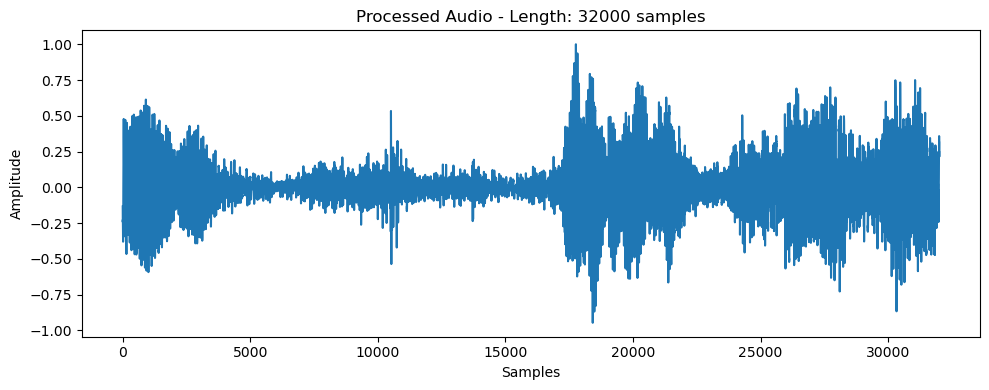

Processed audio shape: (32000,)
Min value: -0.9476, Max value: 1.0000
Duration (seconds): 2.0
Audio preprocessing successful!


In [6]:
# Define audio processing functions directly in the notebook
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt

def load_audio(file_path, sr=16000):
    """Load an audio file at specified sample rate"""
    y, _ = librosa.load(file_path, sr=sr)
    return y

def normalize_audio(y):
    """Normalize audio amplitude"""
    if np.max(np.abs(y)) > 0:
        return y / np.max(np.abs(y))
    return y

def trim_silence(y, top_db=20):
    """Trim leading and trailing silence"""
    trimmed_y, _ = librosa.effects.trim(y, top_db=top_db)
    return trimmed_y

def standardize_length(y, sr, target_duration_sec, method='pad_clip'):
    """Standardize audio to a fixed duration"""
    target_length = int(sr * target_duration_sec)
    
    if method == 'pad_clip':
        if len(y) < target_length:
            return np.pad(y, (0, target_length - len(y)))
        elif len(y) > target_length:
            return y[:target_length]
        else:
            return y
    elif method == 'resample':
        return librosa.resample(
            y=y,
            orig_sr=len(y),
            target_sr=target_length
        )
    else:
        raise ValueError(f"Unknown method: {method}")

def preprocess_audio(file_path, sr=16000, target_duration_sec=2.0, method='pad_clip'):
    """Complete audio preprocessing pipeline"""
    # Load audio
    y = load_audio(file_path, sr=sr)
    
    # Trim silence
    y = trim_silence(y)
    
    # Normalize
    y = normalize_audio(y)
    
    # Standardize length
    y = standardize_length(y, sr, target_duration_sec, method=method)
    
    return y

# Test on a single file
def test_preprocessing():
    # Find an audio file
    audio_dir = "./extracted_audio_data/Audios and excels/Cleaned_Audios"
    
    audio_files = []
    for root, _, files in os.walk(audio_dir):
        for file in files:
            if file.endswith(('.mp3', '.wav', '.ogg', '.flac', '.m4a')):
                audio_files.append(os.path.join(root, file))
                break
        if audio_files:
            break
    
    if not audio_files:
        print("No audio files found!")
        return
    
    test_file = audio_files[0]
    print(f"Testing preprocessing on: {test_file}")
    
    # Preprocess audio
    processed_audio = preprocess_audio(test_file, target_duration_sec=2.0)
    
    # Plot the processed audio
    plt.figure(figsize=(10, 4))
    plt.plot(processed_audio)
    plt.title(f"Processed Audio - Length: {len(processed_audio)} samples")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
    
    print(f"Processed audio shape: {processed_audio.shape}")
    print(f"Min value: {processed_audio.min():.4f}, Max value: {processed_audio.max():.4f}")
    print(f"Duration (seconds): 2.0")
    print("Audio preprocessing successful!")

# Run the test
test_preprocessing()

Testing feature extraction on: ./extracted_audio_data/Audios and excels/Cleaned_Audios/278_s19.mp3
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40

Extracted features:
- Number of time slices: 20
- Features per time slice: 40
- Total feature dimensions: 800


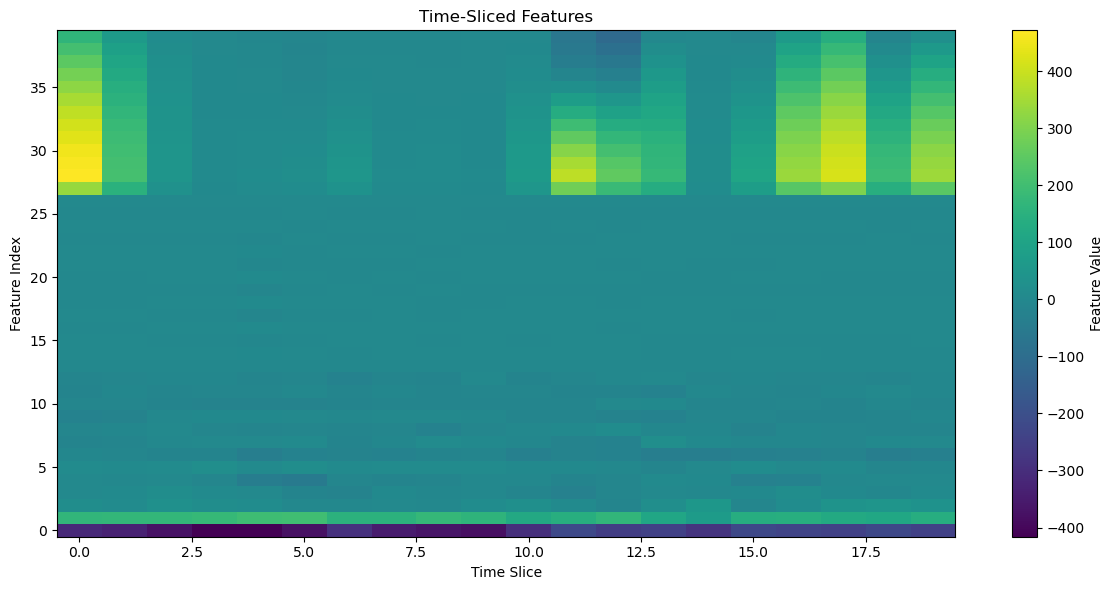


Feature extraction successful!


In [8]:
# Time-Slicing Feature Extraction
import numpy as np
import librosa
from scipy.fftpack import dct
from tqdm import tqdm

class TimeSlicingFeatureExtractor:
    def __init__(self, 
                 sr=16000, 
                 time_window_ms=100,
                 n_mfcc=13,
                 lpc_order=14,
                 dct_length=13):
        """
        Initialize feature extractor for time-sliced audio
        
        Args:
            sr: Sampling rate
            time_window_ms: Time window size in milliseconds
            n_mfcc: Number of MFCC coefficients
            lpc_order: Order of LPC analysis
            dct_length: Number of DCT coefficients
        """
        self.sr = sr
        self.time_window_ms = time_window_ms
        self.n_mfcc = n_mfcc
        self.lpc_order = lpc_order
        self.dct_length = dct_length
        
        # Calculate number of samples per window
        self.samples_per_window = int(sr * time_window_ms / 1000)
        
        # Calculate total feature dimension per window
        self.features_per_window = n_mfcc + lpc_order + dct_length
        
        print(f"Time-slicing configuration:")
        print(f"- Time window: {time_window_ms}ms")
        print(f"- Samples per window: {self.samples_per_window}")
        print(f"- Features per window: {self.features_per_window}")
    
    def extract_mfcc(self, segment):
        """Extract MFCC features from an audio segment"""
        # Ensure segment is long enough for MFCC extraction
        min_length = 512  # Minimum length for typical n_fft
        if len(segment) < min_length:
            segment = np.pad(segment, (0, min_length - len(segment)))
        
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(
            y=segment, 
            sr=self.sr, 
            n_mfcc=self.n_mfcc,
            n_fft=min(512, len(segment)),
            hop_length=min(128, len(segment)//4)
        )
        
        # Take the mean across frames if multiple frames
        if mfccs.shape[1] > 0:
            return np.mean(mfccs, axis=1)
        else:
            # Fallback if no frames
            return np.zeros(self.n_mfcc)
    
    def extract_lpc(self, segment):
        """Extract Linear Prediction Coefficients from an audio segment"""
        # Ensure segment has sufficient length for LPC
        if len(segment) <= self.lpc_order:
            segment = np.pad(segment, (0, self.lpc_order + 1 - len(segment)))
        
        # Calculate LPC coefficients
        lpc = librosa.lpc(segment, order=self.lpc_order)
        
        # Return coefficients (skip the first one which is always 1)
        return lpc[1:]
    
    def extract_dct(self, segment):
        """Extract DCT coefficients from power spectrum"""
        # Calculate power spectrum
        n_fft = min(512, len(segment))
        if len(segment) < n_fft:
            segment = np.pad(segment, (0, n_fft - len(segment)))
        
        # Get magnitude spectrogram
        S = np.abs(librosa.stft(segment, n_fft=n_fft))
        
        # Convert to power spectrogram
        power = S**2
        
        # Average over frames
        if power.shape[1] > 0:
            mean_power = np.mean(power, axis=1)
        else:
            mean_power = power.flatten()
        
        # Apply DCT
        dct_coef = dct(mean_power, type=2, norm='ortho')
        
        # Take the first dct_length coefficients
        return dct_coef[:self.dct_length]
    
    def extract_features_from_time_slices(self, audio):
        """
        Extract features from each time slice of the audio
        
        Args:
            audio: Preprocessed audio signal
            
        Returns:
            features_sequence: Sequence of feature vectors (n_time_slices x features_per_window)
        """
        # Calculate number of time slices
        n_time_slices = len(audio) // self.samples_per_window
        
        # Initialize array to store features
        features_sequence = np.zeros((n_time_slices, self.features_per_window))
        
        # Process each time slice
        for i in range(n_time_slices):
            # Extract time slice
            start = i * self.samples_per_window
            end = start + self.samples_per_window
            segment = audio[start:end]
            
            # Extract features
            mfcc_features = self.extract_mfcc(segment)
            lpc_features = self.extract_lpc(segment)
            dct_features = self.extract_dct(segment)
            
            # Concatenate features
            all_features = np.concatenate([mfcc_features, lpc_features, dct_features])
            
            # Store in sequence
            features_sequence[i] = all_features
        
        return features_sequence
    
    def flatten_features(self, features_sequence):
        """Flatten the sequence of features into a single vector"""
        return features_sequence.flatten()

# Test the feature extraction on a preprocessed audio file
def test_feature_extraction():
    # First preprocess an audio file
    audio_dir = "./extracted_audio_data/Audios and excels/Cleaned_Audios"
    
    # Find an audio file
    audio_files = []
    for root, _, files in os.walk(audio_dir):
        for file in files:
            if file.endswith(('.mp3', '.wav', '.ogg', '.flac', '.m4a')):
                audio_files.append(os.path.join(root, file))
                break
        if audio_files:
            break
    
    if not audio_files:
        print("No audio files found!")
        return
    
    test_file = audio_files[0]
    print(f"Testing feature extraction on: {test_file}")
    
    # Preprocess audio
    processed_audio = preprocess_audio(test_file, target_duration_sec=2.0)
    
    # Initialize feature extractor
    feature_extractor = TimeSlicingFeatureExtractor(
        sr=16000,
        time_window_ms=100,
        n_mfcc=13,
        lpc_order=14,
        dct_length=13
    )
    
    # Extract features from time slices
    features_sequence = feature_extractor.extract_features_from_time_slices(processed_audio)
    
    # Also create flattened version
    flattened_features = feature_extractor.flatten_features(features_sequence)
    
    # Print information about the extracted features
    print(f"\nExtracted features:")
    print(f"- Number of time slices: {features_sequence.shape[0]}")
    print(f"- Features per time slice: {features_sequence.shape[1]}")
    print(f"- Total feature dimensions: {flattened_features.shape[0]}")
    
    # Visualize the feature sequence
    plt.figure(figsize=(12, 6))
    plt.imshow(features_sequence.T, aspect='auto', origin='lower')
    plt.colorbar(label='Feature Value')
    plt.title('Time-Sliced Features')
    plt.xlabel('Time Slice')
    plt.ylabel('Feature Index')
    plt.tight_layout()
    plt.show()
    
    print("\nFeature extraction successful!")
    return features_sequence, flattened_features

# Run the test
features_sequence, flattened_features = test_feature_extraction()

Testing feature processing on: ./extracted_audio_data/Audios and excels/Cleaned_Audios/278_s19.mp3
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40

Feature processing options:
1. Sequential standardized features shape: (20, 40)
PCA with 20 components explains 100.00% of variance
2. Sequential with PCA reduction shape: (20, 20)
3. Flattened standardized features shape: (800,)


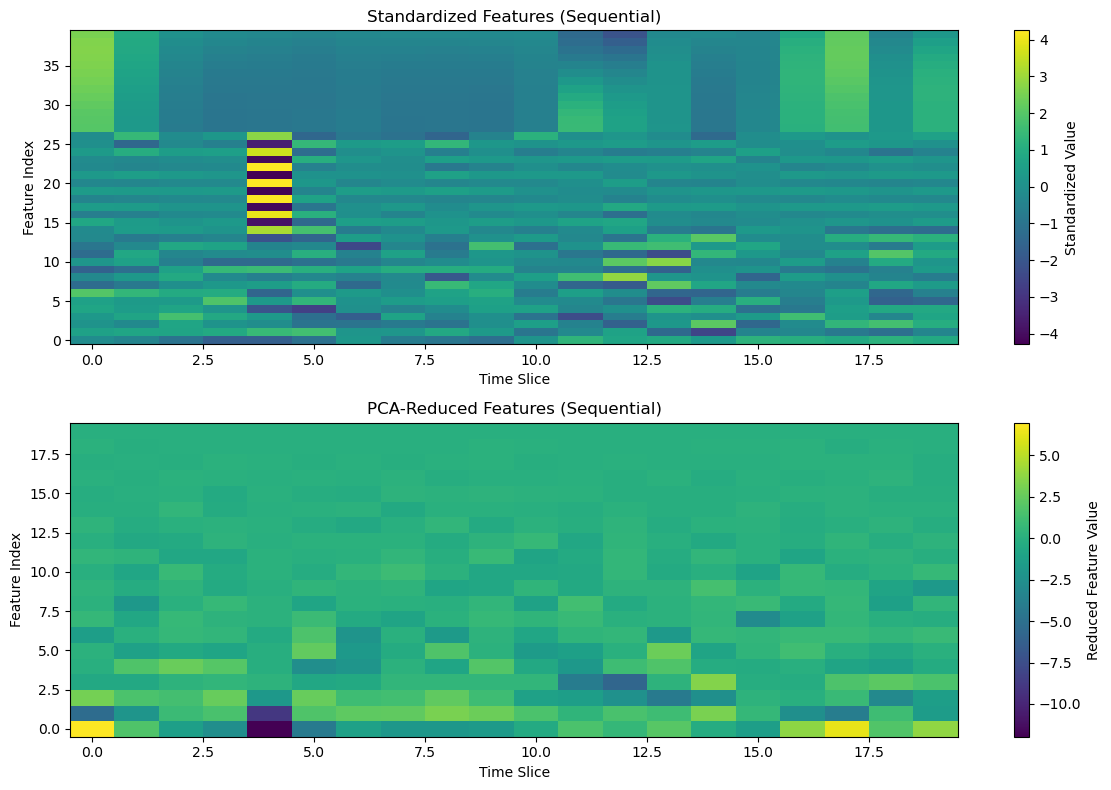


Feature processing successful!


In [10]:
# Feature Processing for Time-Sliced Features - Fixed Version
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

def process_features(features_sequence, flatten=True, standardize=True, reduce_features=False, reduction_method='pca', n_components=None):
    """
    Process extracted features
    
    Args:
        features_sequence: Sequence of features from time slicing (n_slices x n_features)
        flatten: Whether to flatten the features into a single vector
        standardize: Whether to standardize the features
        reduce_features: Whether to apply feature reduction
        reduction_method: Method for feature reduction ('pca' or 'select_k_best')
        n_components: Number of components/features to keep after reduction
        
    Returns:
        Processed features
    """
    # Copy to avoid modifying the original
    features = features_sequence.copy()
    
    # Standardize features
    if standardize:
        # Standardize each feature across time slices
        scaler = StandardScaler()
        # Reshape to (n_samples, n_features) where n_samples = n_time_slices
        features = scaler.fit_transform(features)
    
    # Apply feature reduction if requested (for sequential representation)
    if reduce_features and not flatten:
        if n_components is None:
            # Default: reduce to 20 dimensions or half if already smaller
            n_components = min(20, features.shape[1] // 2)
        
        # Apply reduction method
        if reduction_method == 'pca':
            reducer = PCA(n_components=n_components)
            features = reducer.fit_transform(features)
            # Print variance explained
            print(f"PCA with {n_components} components explains {sum(reducer.explained_variance_ratio_)*100:.2f}% of variance")
        elif reduction_method == 'select_k_best':
            # For select_k_best, we need class labels which aren't available here
            # This would typically be done during the actual training phase
            print(f"Note: SelectKBest requires labels and will be applied during actual training.")
    
    # Flatten if needed
    if flatten:
        original_shape = features.shape
        features = features.flatten()
        
        # Apply feature reduction on flattened features if requested
        if reduce_features:
            if n_components is None:
                # Default: reduce to 100 dimensions or half if already smaller
                n_components = min(100, len(features) // 2)
            
            # For PCA on flattened features, we need to reshape it to have at least
            # as many samples as n_components
            if reduction_method == 'pca':
                # Reshape to make it work with PCA
                # Need to have at least n_components samples
                reshaped_features = features.reshape(-1, 1)
                reducer = PCA(n_components=min(n_components, 1))
                features = reducer.fit_transform(reshaped_features).flatten()
                print(f"Warning: PCA on flattened features is limited to 1 component due to reshaping requirements.")
                print(f"For better dimensionality reduction, apply PCA before flattening.")
            elif reduction_method == 'select_k_best':
                print(f"Note: SelectKBest requires labels and will be applied during actual training.")
    
    return features

# Test the feature processing - Fixed Version
def test_feature_processing():
    # First, extract features from an audio file
    # Find an audio file
    audio_dir = "./extracted_audio_data/Audios and excels/Cleaned_Audios"
    
    audio_files = []
    for root, _, files in os.walk(audio_dir):
        for file in files:
            if file.endswith(('.mp3', '.wav', '.ogg', '.flac', '.m4a')):
                audio_files.append(os.path.join(root, file))
                break
        if audio_files:
            break
    
    if not audio_files:
        print("No audio files found!")
        return
    
    test_file = audio_files[0]
    print(f"Testing feature processing on: {test_file}")
    
    # Preprocess audio
    processed_audio = preprocess_audio(test_file, target_duration_sec=2.0)
    
    # Extract features
    feature_extractor = TimeSlicingFeatureExtractor(
        sr=16000,
        time_window_ms=100,
        n_mfcc=13,
        lpc_order=14,
        dct_length=13
    )
    features_sequence = feature_extractor.extract_features_from_time_slices(processed_audio)
    
    # Process features
    print("\nFeature processing options:")
    
    # 1. Sequential features (not flattened, but standardized)
    seq_standardized = process_features(
        features_sequence, 
        flatten=False, 
        standardize=True, 
        reduce_features=False
    )
    print(f"1. Sequential standardized features shape: {seq_standardized.shape}")
    
    # 2. Sequential features with dimensionality reduction
    seq_reduced = process_features(
        features_sequence, 
        flatten=False, 
        standardize=True, 
        reduce_features=True,
        reduction_method='pca',
        n_components=20  # Reduce features to 20 components
    )
    print(f"2. Sequential with PCA reduction shape: {seq_reduced.shape}")
    
    # 3. Flattened features (standardized)
    flat_standardized = process_features(
        features_sequence, 
        flatten=True, 
        standardize=True, 
        reduce_features=False
    )
    print(f"3. Flattened standardized features shape: {flat_standardized.shape}")
    
    # Visualize the sequential features before and after reduction
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.imshow(seq_standardized.T, aspect='auto', origin='lower')
    plt.colorbar(label='Standardized Value')
    plt.title('Standardized Features (Sequential)')
    plt.xlabel('Time Slice')
    plt.ylabel('Feature Index')
    
    plt.subplot(2, 1, 2)
    plt.imshow(seq_reduced.T, aspect='auto', origin='lower')
    plt.colorbar(label='Reduced Feature Value')
    plt.title('PCA-Reduced Features (Sequential)')
    plt.xlabel('Time Slice')
    plt.ylabel('Feature Index')
    
    plt.tight_layout()
    plt.show()
    
    print("\nFeature processing successful!")
    
    return seq_standardized, seq_reduced, flat_standardized

# Run the test
seq_features, seq_reduced, flat_features = test_feature_processing()

In [13]:
# Check if data splits are ready
import os
import pandas as pd

# Define paths to data splits
train_split = "data_splits/train.csv"
val_split = "data_splits/validation.csv"
test_split = "data_splits/test.csv"

# Check if data_splits directory exists
if not os.path.exists("data_splits"):
    print("Error: data_splits directory does not exist.")
    print("You need to run the data splitting code first.")
else:
    # Check if files exist
    files_exist = all(os.path.exists(file) for file in [train_split, val_split, test_split])
    
    if not files_exist:
        print("Error: One or more data split files are missing.")
        print("Missing files:")
        for file in [train_split, val_split, test_split]:
            if not os.path.exists(file):
                print(f"  - {file}")
        print("You need to run the data splitting code first.")
    else:
        # Load the files and check content
        try:
            train_df = pd.read_csv(train_split)
            val_df = pd.read_csv(val_split)
            test_df = pd.read_csv(test_split)
            
            # Check if the files have the expected columns
            expected_columns = ['filename', 'clarity_label']
            all_columns_present = all(
                all(col in df.columns for col in expected_columns)
                for df in [train_df, val_df, test_df]
            )
            
            if not all_columns_present:
                print("Error: Data split files don't have the expected columns.")
                for file, df in zip(['train', 'validation', 'test'], [train_df, val_df, test_df]):
                    print(f"  - {file} columns: {list(df.columns)}")
            else:
                # Print summary of the data
                print("Data splits are ready!")
                print(f"Training set: {len(train_df)} samples")
                print(f"Validation set: {len(val_df)} samples")
                print(f"Test set: {len(test_df)} samples")
                
                # Show class distribution
                print("\nClass distribution in training set:")
                print(train_df['clarity_label'].value_counts())
                
                print("\nClass distribution in validation set:")
                print(val_df['clarity_label'].value_counts())
                
                print("\nClass distribution in test set:")
                print(test_df['clarity_label'].value_counts())
                
        except Exception as e:
            print(f"Error loading data split files: {e}")
            print("The files may be corrupted or have incorrect format.")

Data splits are ready!
Training set: 2685 samples
Validation set: 576 samples
Test set: 576 samples

Class distribution in training set:
clarity_label
Low       1268
Medium     993
High       424
Name: count, dtype: int64

Class distribution in validation set:
clarity_label
Low       272
Medium    213
High       91
Name: count, dtype: int64

Class distribution in test set:
clarity_label
Low       272
Medium    213
High       91
Name: count, dtype: int64


Preparing training dataset...
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:   0%|                       | 6/2685 [00:02<17:58,  2.49it/s]

Error processing 102_s12.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:   2%|▎                     | 43/2685 [00:04<02:05, 21.03it/s]

Error processing 107_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:   3%|▋                     | 90/2685 [00:06<01:51, 23.29it/s]

Error processing 108_s43.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:   8%|█▋                   | 211/2685 [00:12<01:48, 22.90it/s]

Error processing 108_s31.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  11%|██▎                  | 290/2685 [00:15<01:36, 24.89it/s]

Error processing 108_s50.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  11%|██▎                  | 300/2685 [00:16<01:36, 24.73it/s]

Error processing 106_s13.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  12%|██▌                  | 321/2685 [00:17<01:41, 23.40it/s]

Error processing 107_s18.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  19%|███▉                 | 499/2685 [00:25<01:41, 21.44it/s]

Error processing 108_s26.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  24%|████▉                | 638/2685 [00:31<01:36, 21.26it/s]

Error processing 102_s8.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  26%|█████▌               | 709/2685 [00:35<01:22, 23.87it/s]

Error processing 105_s21.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  33%|██████▉              | 891/2685 [00:44<01:14, 24.02it/s]

Error processing 107_s25.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  34%|███████▏             | 915/2685 [00:45<01:22, 21.54it/s]

Error processing 102_s17.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarnin

Error processing 108_s52.mp3: 
Error processing 108_s40.mp3: 
Error processing 108_s15.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  36%|███████▋             | 975/2685 [00:49<02:08, 13.35it/s]

Error processing 108_s21.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  37%|███████▊             | 998/2685 [00:50<01:24, 19.95it/s]

Error processing 107_s27.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  38%|███████▌            | 1008/2685 [00:50<01:19, 21.17it/s]

Error processing 106_s17.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  38%|███████▋            | 1024/2685 [00:51<01:10, 23.44it/s]

Error processing 108_s10.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  40%|███████▉            | 1061/2685 [00:53<01:03, 25.50it/s]

Error processing 106_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  40%|███████▉            | 1071/2685 [00:53<01:03, 25.58it/s]

Error processing 106_s14.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  44%|████████▋           | 1174/2685 [00:59<01:05, 22.98it/s]

Error processing 108_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  45%|████████▉           | 1196/2685 [01:00<01:07, 21.91it/s]

Error processing 107_s15.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  46%|█████████▎          | 1248/2685 [01:03<00:57, 24.87it/s]

Error processing 108_s23.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  47%|█████████▎          | 1254/2685 [01:03<01:02, 23.06it/s]

Error processing 108_s36.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  47%|█████████▍          | 1272/2685 [01:04<01:29, 15.71it/s]

Error processing 107_s26.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing 107_s31.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  51%|██████████          | 1358/2685 [01:10<01:03, 20.86it/s]

Error processing 105_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  51%|██████████▎         | 1379/2685 [01:11<00:59, 21.84it/s]

Error processing 107_s13.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarnin

Error processing 108_s17.mp3: 
Error processing 107_s30.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in l

Error processing 108_s47.mp3: 
Error processing 108_s34.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  53%|██████████▌         | 1424/2685 [01:12<00:51, 24.59it/s]

Error processing 102_s11.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  54%|██████████▊         | 1454/2685 [01:14<00:54, 22.77it/s]

Error processing 108_s41.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  55%|██████████▉         | 1464/2685 [01:14<00:49, 24.68it/s]

Error processing 107_s9.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarnin

Error processing 106_s19.mp3: 
Error processing 102_s14.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  56%|███████████▏        | 1507/2685 [01:16<00:48, 24.08it/s]

Error processing 107_s24.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  57%|███████████▍        | 1528/2685 [01:17<00:49, 23.15it/s]

Error processing 108_s35.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  58%|███████████▌        | 1544/2685 [01:18<00:51, 21.99it/s]

Error processing 108_s8.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  58%|███████████▌        | 1557/2685 [01:19<00:48, 23.36it/s]

Error processing 108_s51.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  60%|████████████        | 1617/2685 [01:22<00:47, 22.67it/s]

Error processing 108_s27.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  61%|████████████▏       | 1633/2685 [01:22<00:47, 22.31it/s]

Error processing 108_s54.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  61%|████████████▏       | 1643/2685 [01:23<00:43, 24.02it/s]

Error processing 107_s12.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  64%|████████████▊       | 1728/2685 [01:27<00:40, 23.36it/s]

Error processing 107_s10.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  65%|█████████████       | 1753/2685 [01:28<00:43, 21.43it/s]

Error processing 102_s19.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  66%|█████████████▏      | 1763/2685 [01:28<00:40, 22.68it/s]

Error processing 106_s18.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  67%|█████████████▎      | 1789/2685 [01:30<00:45, 19.82it/s]

Error processing 107_s23.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  67%|█████████████▎      | 1795/2685 [01:30<00:41, 21.25it/s]

Error processing 108_s9.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  67%|█████████████▍      | 1801/2685 [01:30<00:44, 19.78it/s]

Error processing 105_s22.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  69%|█████████████▊      | 1859/2685 [01:33<00:35, 23.30it/s]

Error processing 102_s15.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  72%|██████████████▎     | 1926/2685 [01:36<00:31, 24.39it/s]

Error processing 108_s53.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  73%|██████████████▌     | 1948/2685 [01:37<00:33, 21.86it/s]

Error processing 108_s32.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarnin

Error processing 102_s16.mp3: 
Error processing 107_s21.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  76%|███████████████▏    | 2035/2685 [01:41<00:26, 24.38it/s]

Error processing 107_s16.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  76%|███████████████▏    | 2047/2685 [01:42<00:26, 23.90it/s]

Error processing 108_s49.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  77%|███████████████▍    | 2067/2685 [01:43<00:33, 18.54it/s]

Error processing 108_s13.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  79%|███████████████▋    | 2114/2685 [01:45<00:26, 21.76it/s]

Error processing 108_s38.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  82%|████████████████▎   | 2192/2685 [01:49<00:21, 22.76it/s]

Error processing 106_s16.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  82%|████████████████▍   | 2210/2685 [01:50<00:20, 23.17it/s]

Error processing 108_s14.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  83%|████████████████▋   | 2235/2685 [01:51<00:17, 25.81it/s]

Error processing 107_s11.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  84%|████████████████▊   | 2253/2685 [01:52<00:19, 22.33it/s]

Error processing 108_s16.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  86%|█████████████████▏  | 2308/2685 [01:54<00:15, 23.75it/s]

Error processing 107_s22.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  89%|█████████████████▊  | 2391/2685 [01:58<00:15, 19.54it/s]

Error processing 108_s39.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  89%|█████████████████▊  | 2397/2685 [01:59<00:13, 20.87it/s]

Error processing 102_s13.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  90%|█████████████████▉  | 2413/2685 [02:00<00:14, 19.41it/s]

Error processing 108_s46.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  91%|██████████████████▎ | 2456/2685 [02:02<00:10, 21.12it/s]

Error processing 108_s25.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  92%|██████████████████▍ | 2473/2685 [02:03<00:10, 20.28it/s]

Error processing 102_s9.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  94%|██████████████████▊ | 2530/2685 [02:06<00:06, 24.06it/s]

Error processing 106_s20.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  95%|██████████████████▉ | 2549/2685 [02:06<00:05, 23.90it/s]

Error processing 108_s44.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  95%|███████████████████ | 2558/2685 [02:07<00:05, 23.10it/s]

Error processing 108_s45.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  98%|███████████████████▌| 2622/2685 [02:10<00:02, 24.40it/s]

Error processing 105_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  98%|███████████████████▋| 2637/2685 [02:10<00:02, 20.68it/s]

Error processing 108_s29.mp3: 


Preparing dataset: 100%|████████████████████| 2685/2685 [02:13<00:00, 20.19it/s]


Preparing validation dataset...
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  16%|███▋                   | 91/576 [00:03<00:21, 23.00it/s]

Error processing 108_s30.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  32%|██████▉               | 182/576 [00:08<00:17, 22.98it/s]

Error processing 106_s12.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  40%|████████▊             | 231/576 [00:10<00:14, 23.62it/s]

Error processing 102_s18.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarnin

Error processing 102_s10.mp3: 
Error processing 107_s29.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  49%|██████████▊           | 284/576 [00:12<00:12, 23.65it/s]

Error processing 107_s28.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  80%|█████████████████▍    | 458/576 [00:20<00:05, 22.99it/s]

Error processing 105_s23.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Preparing dataset:  83%|██████████████████▏   | 477/576 [00:21<00:04, 24.41it/s]

Error processing 108_s11.mp3: 


/var/folders/xq/y08wppy17hs2rpm59cz0d_hc0000gp/T/ipykernel_65144/2193458401.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniforge/base/envs/hmm_env/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  92%|████████████████████▏ | 529/576 [00:23<00:01, 23.95it/s]

Error processing 108_s42.mp3: 


Preparing dataset: 100%|██████████████████████| 576/576 [00:26<00:00, 22.08it/s]


Training set: 2610 samples
Validation set: 567 samples

Training class distribution:
  Low: 1213 samples
  Medium: 977 samples
  High: 420 samples

Validation class distribution:
  Low: 268 samples
  Medium: 208 samples
  High: 91 samples

Training HMM model with duplication balancing...
Using 5 states and 2 mixtures
Unique classes: ['High' 'Low' 'Medium']

Balancing dataset by duplication:
Original class distribution: {np.str_('High'): np.int64(420), np.str_('Low'): np.int64(1213), np.str_('Medium'): np.int64(977)}
Target count per class: 1213
Class High: Duplicating samples 3 times to reach target
Class Medium: Duplicating samples 2 times to reach target
Balanced class distribution: {np.str_('High'): np.int64(1213), np.str_('Low'): np.int64(1213), np.str_('Medium'): np.int64(1213)}

Training HMM for class: High
  Using 1213 sequences


         1 -1245118.72789413             +nan
         2 -1000517.50065002 +244601.22724411
         3 -954271.98148158  +46245.51916845
         4 -944057.33715968  +10214.64432190
         5 -938284.93489978   +5772.40225990
         6 -932407.47730629   +5877.45759349
         7 -926744.45121514   +5663.02609115
         8 -921563.16182837   +5181.28938677
         9 -917976.45105184   +3586.71077653
        10 -915778.30784395   +2198.14320789



Training HMM for class: Low
  Using 1213 sequences


         1 -1238681.15642462             +nan
         2 -940860.79784909 +297820.35857553
         3 -893859.28309807  +47001.51475102
         4 -881671.10543330  +12188.17766478
         5 -874363.85572486   +7307.24970844
         6 -868346.39670294   +6017.45902192
         7 -862997.08109945   +5349.31560349
         8 -858060.87508666   +4936.20601278
         9 -853762.58752332   +4298.28756334
        10 -850540.91072194   +3221.67680138



Training HMM for class: Medium
  Using 1213 sequences


         1 -1315125.61747749             +nan
         2 -1014044.94988782 +301080.66758968
         3 -949808.29113850  +64236.65874932
         4 -938061.36551426  +11746.92562423
         5 -931153.19558052   +6908.16993374
         6 -924285.16620404   +6868.02937648
         7 -917003.51881397   +7281.64739007
         8 -911216.86889738   +5786.64991659
         9 -908283.53538722   +2933.33351015
        10 -906692.38558612   +1591.14980110


Training completed in 31.43 seconds

Evaluating on validation set...
Accuracy: 0.5097

Classification Report:
              precision    recall  f1-score   support

        High       0.27      0.34      0.30        91
         Low       0.67      0.59      0.63       268
      Medium       0.46      0.48      0.47       208

    accuracy                           0.51       567
   macro avg       0.47      0.47      0.47       567
weighted avg       0.53      0.51      0.52       567


Confusion Matrix:
[[ 31  20  40]
 [ 33 159  76]
 [ 49  60  99]]


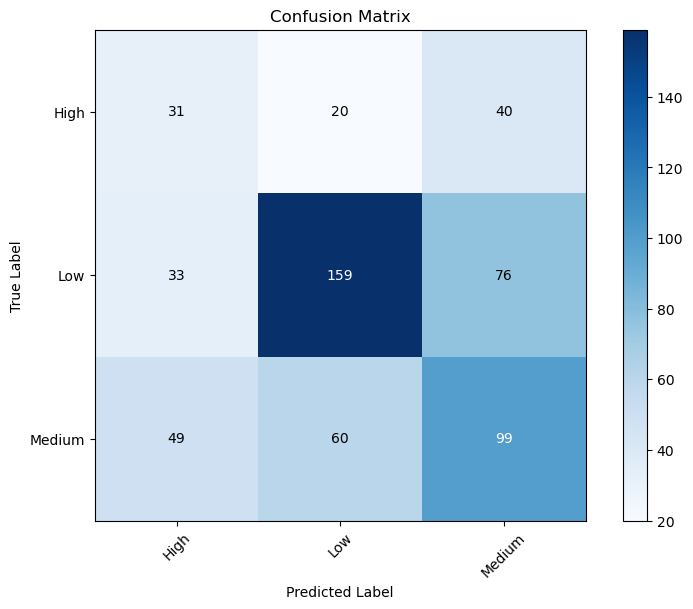

In [14]:
# HMM Model with Duplication for Class Balancing
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from collections import Counter

class BalancedHMMClarityClassifier:
    def __init__(self, n_states=5, n_mixtures=2, covariance_type='diag', random_state=42):
        """
        HMM-based classifier for clarity assessment with class balancing
        
        Args:
            n_states: Number of hidden states
            n_mixtures: Number of mixture components
            covariance_type: Type of covariance matrix ('diag', 'full', 'tied', 'spherical')
            random_state: Random seed
        """
        self.n_states = n_states
        self.n_mixtures = n_mixtures
        self.covariance_type = covariance_type
        self.random_state = random_state
        self.models = {}  # Dictionary to store HMM models for each class
        self.classes = None
    
    def fit(self, X_sequences, y):
        """
        Train HMM models for each clarity class with balancing
        
        Args:
            X_sequences: List of feature sequences (n_samples, n_time_slices, n_features)
            y: List of clarity labels
        """
        self.classes = np.unique(y)
        print(f"Unique classes: {self.classes}")
        
        # Balance dataset by duplicating samples
        X_balanced, y_balanced = self._balance_dataset_by_duplication(X_sequences, y)
        
        # Train one HMM per class using the balanced dataset
        for label in self.classes:
            print(f"\nTraining HMM for class: {label}")
            
            # Get sequences for this class
            class_indices = [i for i, l in enumerate(y_balanced) if l == label]
            class_sequences = [X_balanced[i] for i in class_indices]
            
            print(f"  Using {len(class_sequences)} sequences")
            
            # Check that we have sufficient data
            if len(class_sequences) < 10:
                print(f"Warning: Very few samples ({len(class_sequences)}) for class {label}")
                
            # Create HMM model
            model = hmm.GMMHMM(
                n_components=self.n_states,
                n_mix=self.n_mixtures,
                covariance_type=self.covariance_type,
                random_state=self.random_state,
                verbose=True
            )
            
            # Prepare data for fitting
            X_concat = np.vstack(class_sequences)
            lengths = [len(x) for x in class_sequences]
            
            # Fit model
            model.fit(X_concat, lengths=lengths)
            
            # Store model
            self.models[label] = model
    
    def _balance_dataset_by_duplication(self, X_sequences, y):
        """
        Balance dataset by duplicating samples from minority classes
        
        Args:
            X_sequences: List of feature sequences
            y: List of clarity labels
            
        Returns:
            X_balanced: Balanced list of feature sequences
            y_balanced: Balanced list of labels
        """
        print("\nBalancing dataset by duplication:")
        
        # Count samples per class
        class_counts = {}
        for label in self.classes:
            class_counts[label] = np.sum(np.array(y) == label)
        
        print(f"Original class distribution: {class_counts}")
        
        # Find the maximum count (or use a fixed target)
        max_count = max(class_counts.values())
        target_count_per_class = max_count
        print(f"Target count per class: {target_count_per_class}")
        
        # Create balanced dataset
        X_balanced = []
        y_balanced = []
        
        for label in self.classes:
            # Get indices of samples from this class
            indices = np.where(np.array(y) == label)[0]
            current_count = len(indices)
            
            # Calculate how many times to duplicate
            n_duplications = int(np.ceil(target_count_per_class / current_count))
            
            # Add original samples
            for idx in indices:
                X_balanced.append(X_sequences[idx])
                y_balanced.append(label)
            
            # Add duplicated samples if needed
            if n_duplications > 1:
                print(f"Class {label}: Duplicating samples {n_duplications} times to reach target")
                # Keep duplicating until we reach the target
                duplicate_count = current_count
                duplicate_indices = list(indices)  # Copy to avoid modifying the original
                
                while duplicate_count < target_count_per_class:
                    # Choose a random sample to duplicate
                    idx = duplicate_indices[np.random.randint(len(duplicate_indices))]
                    X_balanced.append(X_sequences[idx])
                    y_balanced.append(label)
                    duplicate_count += 1
        
        # Verify the new distribution
        balanced_counts = {}
        for label in self.classes:
            balanced_counts[label] = np.sum(np.array(y_balanced) == label)
        
        print(f"Balanced class distribution: {balanced_counts}")
        
        return X_balanced, y_balanced
    
    def predict(self, X_sequences):
        """
        Predict clarity labels for new sequences
        
        Args:
            X_sequences: List of feature sequences
            
        Returns:
            Predicted clarity labels
        """
        if not self.models:
            raise ValueError("Model not trained yet. Call fit() first.")
        
        predictions = []
        
        for X in X_sequences:
            scores = {}
            
            # Calculate log likelihood for each class
            for label, model in self.models.items():
                scores[label] = model.score(X)
            
            # Predict the class with highest likelihood
            predicted_label = max(scores, key=scores.get)
            predictions.append(predicted_label)
        
        return np.array(predictions)
    
    def predict_proba(self, X_sequences):
        """
        Predict probability of each class for new sequences
        
        Args:
            X_sequences: List of feature sequences
            
        Returns:
            Probability array (n_samples, n_classes)
        """
        if not self.models:
            raise ValueError("Model not trained yet. Call fit() first.")
        
        n_samples = len(X_sequences)
        probas = np.zeros((n_samples, len(self.classes)))
        
        # Map classes to indices
        class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        for i, X in enumerate(X_sequences):
            scores = []
            
            # Calculate log likelihood for each class
            for label in self.classes:
                scores.append(self.models[label].score(X))
            
            # Convert log likelihoods to probabilities
            scores = np.array(scores)
            scores = scores - np.max(scores)  # Numerical stability
            probs = np.exp(scores) / np.sum(np.exp(scores))
            
            for j, label in enumerate(self.classes):
                probas[i, class_to_idx[label]] = probs[j]
        
        return probas

# Function to prepare dataset for HMM
def prepare_dataset_for_hmm(data_split_file, audio_dir, sr=16000, duration_sec=2.0, 
                           time_window_ms=100, standardize=True, reduce_features=False,
                           max_samples_per_class=None, verbose=True):
    """
    Prepare dataset for HMM training
    
    Args:
        data_split_file: CSV file with filenames and labels
        audio_dir: Directory containing audio files
        sr: Sampling rate
        duration_sec: Target duration in seconds
        time_window_ms: Time window in milliseconds
        standardize: Whether to standardize features
        reduce_features: Whether to apply feature reduction
        max_samples_per_class: Maximum number of samples to use per class (for testing)
        verbose: Whether to print progress
        
    Returns:
        X_sequences: Feature sequences
        y: Labels
    """
    # Load data split
    df = pd.read_csv(data_split_file)
    
    # Limit samples per class if specified (for testing)
    if max_samples_per_class is not None:
        samples_per_class = {}
        filtered_indices = []
        
        for i, row in df.iterrows():
            label = row['clarity_label']
            current_count = samples_per_class.get(label, 0)
            
            if current_count < max_samples_per_class:
                filtered_indices.append(i)
                samples_per_class[label] = current_count + 1
        
        df = df.iloc[filtered_indices].reset_index(drop=True)
        if verbose:
            print(f"Limited to {max_samples_per_class} samples per class.")
            print(f"Using {len(df)} samples in total.")
    
    # Initialize feature extractor
    feature_extractor = TimeSlicingFeatureExtractor(
        sr=sr,
        time_window_ms=time_window_ms,
        n_mfcc=13,
        lpc_order=14,
        dct_length=13
    )
    
    # Process each audio file
    X_sequences = []
    y = []
    
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Preparing dataset"):
        try:
            # Find the audio file
            filename = row['filename']
            file_path = os.path.join(audio_dir, filename)
            
            # Search recursively if not found directly
            if not os.path.exists(file_path):
                found = False
                for root, _, files in os.walk(audio_dir):
                    for file in files:
                        if file == filename:
                            file_path = os.path.join(root, file)
                            found = True
                            break
                    if found:
                        break
                
                if not found:
                    if verbose:
                        print(f"Warning: Could not find {filename}")
                    continue
            
            # Preprocess audio
            processed_audio = preprocess_audio(
                file_path, 
                sr=sr, 
                target_duration_sec=duration_sec
            )
            
            # Extract features
            features_sequence = feature_extractor.extract_features_from_time_slices(processed_audio)
            
            # Process features
            processed_features = process_features(
                features_sequence,
                flatten=False,  # Keep sequential for HMM
                standardize=standardize,
                reduce_features=reduce_features
            )
            
            # Add to dataset
            X_sequences.append(processed_features)
            y.append(row['clarity_label'])
            
        except Exception as e:
            if verbose:
                print(f"Error processing {row.get('filename', 'unknown')}: {e}")
    
    return X_sequences, np.array(y)

# Function to train and evaluate the balanced HMM model
def train_and_evaluate_hmm_with_duplication(train_split, val_split, audio_dir, 
                                            n_states=5, n_mixtures=2,
                                            max_samples_per_class=None):
    """
    Train and evaluate HMM model with duplication for class balancing
    
    Args:
        train_split: CSV file with training data
        val_split: CSV file with validation data
        audio_dir: Directory containing audio files
        n_states: Number of hidden states
        n_mixtures: Number of mixture components
        max_samples_per_class: Maximum samples per class (for testing)
        
    Returns:
        Trained HMM model
    """
    print("Preparing training dataset...")
    X_train, y_train = prepare_dataset_for_hmm(
        train_split, audio_dir, 
        max_samples_per_class=max_samples_per_class
    )
    
    print("Preparing validation dataset...")
    X_val, y_val = prepare_dataset_for_hmm(
        val_split, audio_dir,
        max_samples_per_class=max_samples_per_class
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples")
    
    # Display class distribution
    train_class_counts = Counter(y_train)
    val_class_counts = Counter(y_val)
    
    print("\nTraining class distribution:")
    for cls, count in train_class_counts.items():
        print(f"  {cls}: {count} samples")
    
    print("\nValidation class distribution:")
    for cls, count in val_class_counts.items():
        print(f"  {cls}: {count} samples")
    
    # Initialize and train balanced HMM model
    print(f"\nTraining HMM model with duplication balancing...")
    print(f"Using {n_states} states and {n_mixtures} mixtures")
    
    start_time = time.time()
    
    model = BalancedHMMClarityClassifier(
        n_states=n_states,
        n_mixtures=n_mixtures,
        covariance_type='diag',
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    # Evaluate on validation set
    print("\nEvaluating on validation set...")
    y_pred = model.predict(X_val)
    
    # Print evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    print("\nClassification Report:")
    report = classification_report(y_val, y_pred)
    print(report)
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_val, y_pred)
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Add labels
    classes = np.unique(y_val)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return model

# Main execution
if __name__ == "__main__":
    # Paths to data splits
    train_split = "data_splits/train.csv"
    val_split = "data_splits/validation.csv"
    audio_dir = "./extracted_audio_data/Audios and excels/Cleaned_Audios"
    
    # For initial testing, limit samples
    max_samples = None  # Set to a number for testing, None for full dataset
    
    # Train and evaluate HMM model with duplication
    hmm_model = train_and_evaluate_hmm_with_duplication(
        train_split, val_split, audio_dir,
        n_states=5,
        n_mixtures=2,
        max_samples_per_class=max_samples
    )

Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40
Processing training data...


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:   0%|                         | 7/2685 [00:00<01:57, 22.75it/s]

Error loading 102_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:   2%|▍                       | 43/2685 [00:02<02:02, 21.51it/s]

Error loading 107_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:   3%|▊                       | 91/2685 [00:04<02:15, 19.20it/s]

Error loading 108_s43.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:   8%|█▊                     | 213/2685 [00:10<01:50, 22.45it/s]

Error loading 108_s31.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  11%|██▍                    | 289/2685 [00:14<01:40, 23.82it/s]

Error loading 108_s50.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  11%|██▌                    | 302/2685 [00:15<01:38, 24.07it/s]

Error loading 106_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  12%|██▋                    | 321/2685 [00:15<01:41, 23.20it/s]

Error loading 107_s18.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  19%|████▎                  | 499/2685 [00:23<01:33, 23.27it/s]

Error loading 108_s26.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  24%|█████▍                 | 640/2685 [00:30<01:30, 22.58it/s]

Error loading 102_s8.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  26%|██████                 | 710/2685 [00:33<01:27, 22.66it/s]

Error loading 105_s21.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  33%|███████▋               | 893/2685 [00:42<01:12, 24.89it/s]

Error loading 107_s25.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  34%|███████▊               | 917/2685 [00:43<01:16, 23.24it/s]

Error loading 102_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading 108_s52.mp3: 
Error loading 108_s40.mp3: 
Error loading 108_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  36%|████████▎              | 975/2685 [00:45<01:22, 20.78it/s]

Error loading 108_s21.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  37%|████████▌              | 997/2685 [00:46<01:12, 23.30it/s]

Error loading 107_s27.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  38%|████████▎             | 1007/2685 [00:47<01:16, 21.96it/s]

Error loading 106_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  38%|████████▍             | 1023/2685 [00:48<01:10, 23.58it/s]

Error loading 108_s10.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  40%|████████▋             | 1063/2685 [00:49<01:06, 24.33it/s]

Error loading 106_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  40%|████████▊             | 1070/2685 [00:50<01:04, 24.86it/s]

Error loading 106_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  44%|█████████▋            | 1175/2685 [00:54<01:01, 24.50it/s]

Error loading 108_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  45%|█████████▊            | 1196/2685 [00:55<01:09, 21.32it/s]

Error loading 107_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  46%|██████████▏           | 1247/2685 [00:58<00:59, 23.98it/s]

Error loading 108_s23.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  47%|██████████▎           | 1253/2685 [00:58<01:00, 23.76it/s]

Error loading 108_s36.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  47%|██████████▍           | 1274/2685 [00:59<01:03, 22.09it/s]

Error loading 107_s26.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  49%|██████████▊           | 1326/2685 [01:02<01:05, 20.83it/s]

Error loading 107_s31.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  51%|███████████▏          | 1361/2685 [01:04<01:03, 20.95it/s]

Error loading 105_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  51%|███████████▎          | 1377/2685 [01:05<01:03, 20.53it/s]

Error loading 107_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading 108_s17.mp3: 
Error loading 107_s30.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading 108_s47.mp3: 
Error loading 108_s34.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  53%|███████████▋          | 1423/2685 [01:07<01:02, 20.35it/s]

Error loading 102_s11.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  54%|███████████▉          | 1456/2685 [01:09<01:08, 18.02it/s]

Error loading 108_s41.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  54%|███████████▉          | 1463/2685 [01:10<01:00, 20.09it/s]

Error loading 107_s9.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  56%|████████████▎         | 1501/2685 [01:12<00:48, 24.55it/s]

Error loading 106_s19.mp3: 
Error loading 102_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  56%|████████████▎         | 1505/2685 [01:12<00:45, 26.07it/s]

Error loading 107_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  57%|████████████▌         | 1530/2685 [01:13<00:49, 23.32it/s]

Error loading 108_s35.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  57%|████████████▋         | 1543/2685 [01:14<00:49, 23.08it/s]

Error loading 108_s8.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  58%|████████████▋         | 1555/2685 [01:14<00:49, 22.89it/s]

Error loading 108_s51.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  60%|█████████████▏        | 1617/2685 [01:17<00:49, 21.66it/s]

Error loading 108_s27.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  61%|█████████████▍        | 1635/2685 [01:18<00:49, 21.39it/s]

Error loading 108_s54.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  61%|█████████████▍        | 1644/2685 [01:18<00:47, 21.91it/s]

Error loading 107_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  64%|██████████████▏       | 1728/2685 [01:22<00:41, 23.04it/s]

Error loading 107_s10.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  65%|██████████████▎       | 1753/2685 [01:24<00:40, 23.29it/s]

Error loading 102_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  66%|██████████████▍       | 1763/2685 [01:24<00:37, 24.51it/s]

Error loading 106_s18.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  67%|██████████████▋       | 1790/2685 [01:25<00:40, 22.15it/s]

Error loading 107_s23.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  67%|██████████████▋       | 1796/2685 [01:26<00:38, 23.11it/s]

Error loading 108_s9.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  67%|██████████████▊       | 1805/2685 [01:26<00:36, 24.23it/s]

Error loading 105_s22.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  69%|███████████████▏      | 1859/2685 [01:28<00:36, 22.40it/s]

Error loading 102_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  72%|███████████████▊      | 1928/2685 [01:32<00:37, 20.43it/s]

Error loading 108_s53.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  73%|███████████████▉      | 1948/2685 [01:33<00:33, 22.07it/s]

Error loading 108_s32.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  75%|████████████████▌     | 2019/2685 [01:37<00:27, 24.29it/s]

Error loading 102_s16.mp3: 
Error loading 107_s21.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  76%|████████████████▋     | 2035/2685 [01:37<00:27, 23.94it/s]

Error loading 107_s16.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  76%|████████████████▊     | 2045/2685 [01:38<00:27, 23.36it/s]

Error loading 108_s49.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  77%|████████████████▉     | 2067/2685 [01:39<00:27, 22.12it/s]

Error loading 108_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  79%|█████████████████▎    | 2114/2685 [01:41<00:27, 20.64it/s]

Error loading 108_s38.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  82%|█████████████████▉    | 2192/2685 [01:45<00:22, 22.05it/s]

Error loading 106_s16.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  82%|██████████████████    | 2210/2685 [01:46<00:21, 22.11it/s]

Error loading 108_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  83%|██████████████████▎   | 2235/2685 [01:47<00:19, 22.65it/s]

Error loading 107_s11.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  84%|██████████████████▍   | 2253/2685 [01:48<00:20, 21.47it/s]

Error loading 108_s16.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  86%|██████████████████▉   | 2308/2685 [01:51<00:16, 23.10it/s]

Error loading 107_s22.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading 108_s39.mp3: 
Error loading 102_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  90%|███████████████████▊  | 2414/2685 [01:57<00:12, 22.29it/s]

Error loading 108_s46.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  92%|████████████████████▏ | 2459/2685 [01:59<00:10, 21.03it/s]

Error loading 108_s25.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  92%|████████████████████▎ | 2474/2685 [02:00<00:09, 22.04it/s]

Error loading 102_s9.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  94%|████████████████████▋ | 2528/2685 [02:02<00:07, 21.35it/s]

Error loading 106_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  95%|████████████████████▉ | 2550/2685 [02:03<00:06, 21.68it/s]

Error loading 108_s44.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  95%|████████████████████▉ | 2557/2685 [02:04<00:05, 22.68it/s]

Error loading 108_s45.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  98%|█████████████████████▍| 2622/2685 [02:07<00:02, 23.86it/s]

Error loading 105_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  98%|█████████████████████▌| 2637/2685 [02:07<00:02, 23.14it/s]

Error loading 108_s29.mp3: 


Processing data: 100%|██████████████████████| 2685/2685 [02:10<00:00, 20.60it/s]


Processing validation data...


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  16%|███▉                     | 90/576 [00:04<00:23, 20.41it/s]

Error loading 108_s30.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  32%|███████▌                | 182/576 [00:08<00:18, 21.77it/s]

Error loading 106_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  40%|█████████▋              | 231/576 [00:10<00:14, 23.18it/s]

Error loading 102_s18.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  46%|██████████▉             | 263/576 [00:12<00:10, 28.94it/s]

Error loading 102_s10.mp3: 
Error loading 107_s29.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  50%|███████████▉            | 286/576 [00:13<00:13, 22.14it/s]

Error loading 107_s28.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  80%|███████████████████▏    | 459/576 [00:22<00:05, 21.51it/s]

Error loading 105_s23.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  83%|███████████████████▉    | 478/576 [00:22<00:04, 23.13it/s]

Error loading 108_s11.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  92%|██████████████████████  | 530/576 [00:25<00:01, 24.48it/s]

Error loading 108_s42.mp3: 


Processing data: 100%|████████████████████████| 576/576 [00:27<00:00, 21.07it/s]

Training set: 2610 samples, 80 features
Validation set: 567 samples, 80 features
Original class distribution:
Counter({np.str_('Low'): 1213, np.str_('Medium'): 977, np.str_('High'): 420})
Label mapping:
  High -> 0
  Low -> 1
  Medium -> 2

Applying SMOTE oversampling...
Resampled class distribution:
Counter({np.int64(1): 1213, np.int64(2): 1213, np.int64(0): 1213})

Training XGBoost model...
[0]	validation_0-mlogloss:1.08247	validation_1-mlogloss:1.08789
[1]	validation_0-mlogloss:1.06834	validation_1-mlogloss:1.07827
[2]	validation_0-mlogloss:1.05511	validation_1-mlogloss:1.07047
[3]	validation_0-mlogloss:1.04263	validation_1-mlogloss:1.06397
[4]	validation_0-mlogloss:1.03156	validation_1-mlogloss:1.05740
[5]	validation_0-mlogloss:1.02035	validation_1-mlogloss:1.05266
[6]	validation_0-mlogloss:1.01018	validation_1-mlogloss:1.04851
[7]	validation_0-mlogloss:0.99856	validation_1-mlogloss:1.04340


[8]	validation_0-mlogloss:0.98780	validation_1-mlogloss:1.03801
[9]	validation_0-mlogloss:0.97913	validation_1-mlogloss:1.03272
[10]	validation_0-mlogloss:0.96956	validation_1-mlogloss:1.02965
[11]	validation_0-mlogloss:0.96029	validation_1-mlogloss:1.02512
[12]	validation_0-mlogloss:0.95164	validation_1-mlogloss:1.02208
[13]	validation_0-mlogloss:0.94338	validation_1-mlogloss:1.01901
[14]	validation_0-mlogloss:0.93517	validation_1-mlogloss:1.01747
[15]	validation_0-mlogloss:0.92756	validation_1-mlogloss:1.01512
[16]	validation_0-mlogloss:0.92022	validation_1-mlogloss:1.01268
[17]	validation_0-mlogloss:0.91212	validation_1-mlogloss:1.01104
[18]	validation_0-mlogloss:0.90530	validation_1-mlogloss:1.00891
[19]	validation_0-mlogloss:0.89842	validation_1-mlogloss:1.00922
[20]	validation_0-mlogloss:0.89092	validation_1-mlogloss:1.00782
[21]	validation_0-mlogloss:0.88450	validation_1-mlogloss:1.00709
[22]	validation_0-mlogloss:0.87791	validation_1-mlogloss:1.00641
[23]	validation_0-mlogloss:

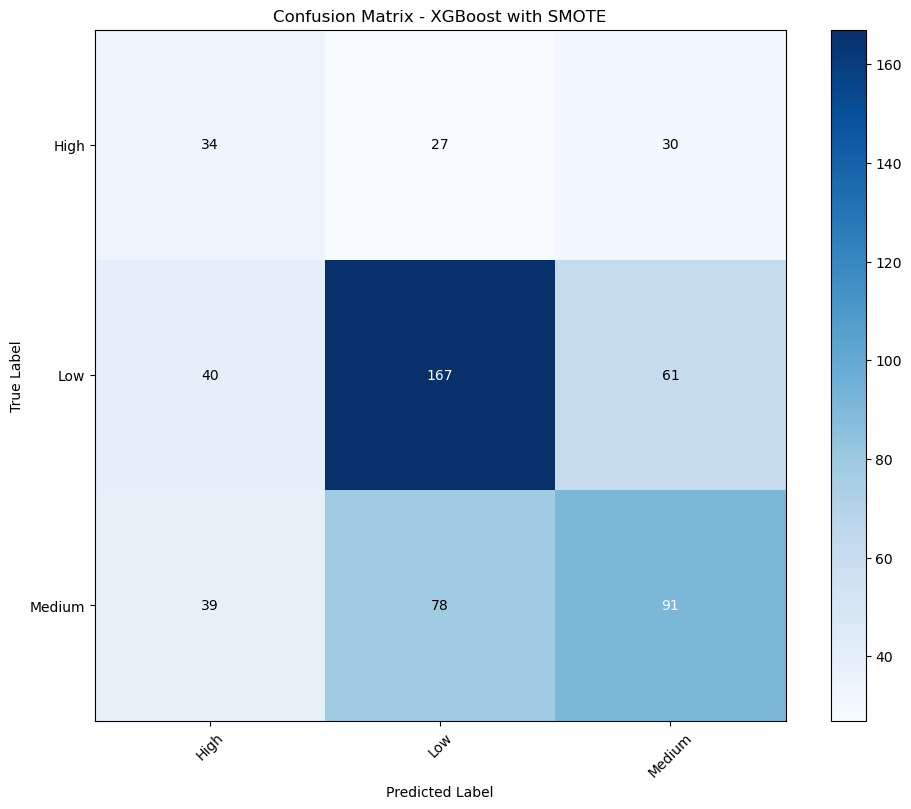

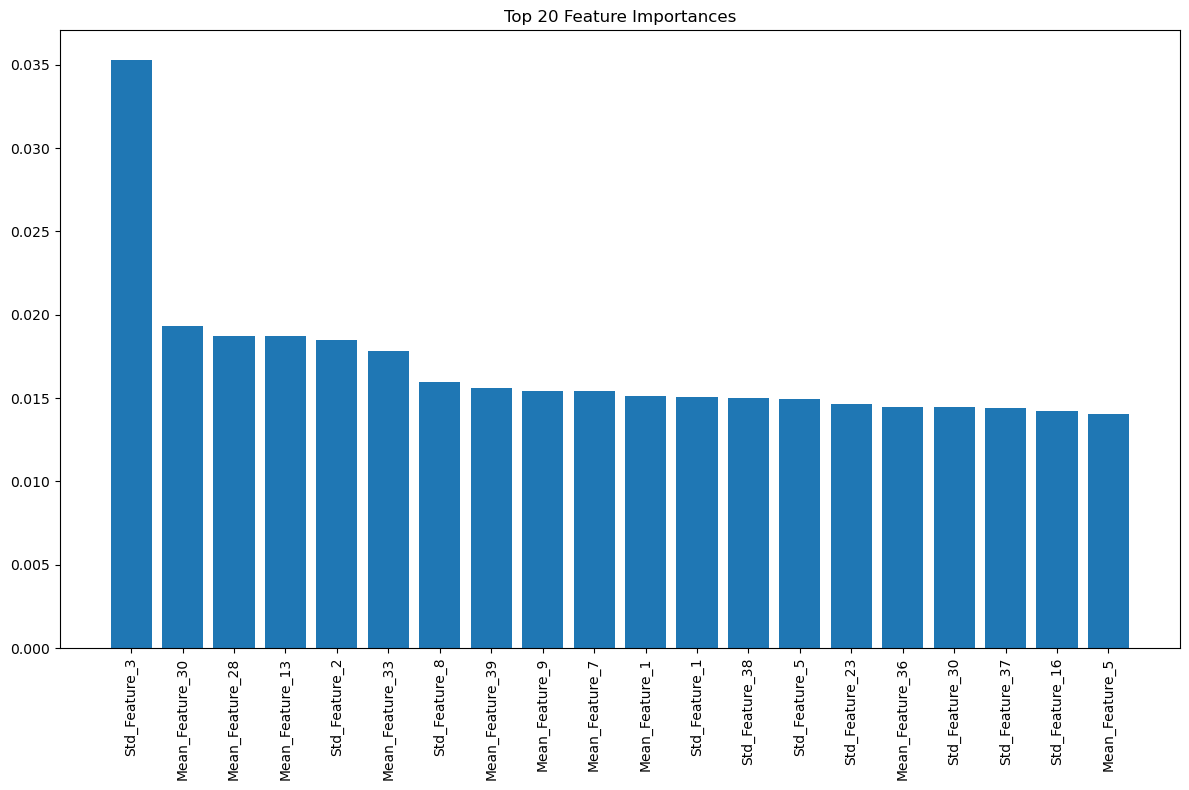

Model saved to 'xgboost_clarity_model.pkl'
Loading and processing test data...


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:   6%|█▍                       | 32/576 [00:01<00:19, 28.57it/s]

Error loading 107_s20.mp3: 
Error loading 108_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  16%|████                     | 93/576 [00:04<00:19, 25.28it/s]

Error loading 108_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  35%|████████▎               | 199/576 [00:08<00:14, 26.50it/s]

Error loading 108_s37.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  39%|█████████▎              | 224/576 [00:09<00:13, 26.57it/s]

Error loading 108_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  53%|████████████▊           | 307/576 [00:13<00:10, 26.69it/s]

Error loading 108_s48.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  55%|█████████████▏          | 317/576 [00:14<00:10, 25.50it/s]

Error loading 108_s28.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  61%|██████████████▊         | 354/576 [00:15<00:08, 25.20it/s]

Error loading 107_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  79%|███████████████████     | 456/576 [00:20<00:04, 24.74it/s]

Error loading 102_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  81%|███████████████████▌    | 468/576 [00:21<00:04, 25.32it/s]

Error loading 107_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  84%|████████████████████    | 481/576 [00:21<00:03, 25.94it/s]

Error loading 108_s22.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  85%|████████████████████▍   | 491/576 [00:22<00:03, 27.33it/s]

Error loading 105_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  87%|████████████████████▉   | 503/576 [00:22<00:02, 26.30it/s]

Error loading 108_s33.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  94%|██████████████████████▋ | 543/576 [00:24<00:01, 26.72it/s]

Error loading 108_s18.mp3: 


Processing data: 100%|████████████████████████| 576/576 [00:25<00:00, 22.46it/s]



Test Accuracy: 0.4858

Test Classification Report:
              precision    recall  f1-score   support

        High       0.22      0.27      0.24        90
         Low       0.61      0.62      0.61       263
      Medium       0.47      0.42      0.44       209

    accuracy                           0.49       562
   macro avg       0.43      0.43      0.43       562
weighted avg       0.49      0.49      0.49       562


Test Confusion Matrix:
[[ 24  28  38]
 [ 39 162  62]
 [ 48  74  87]]


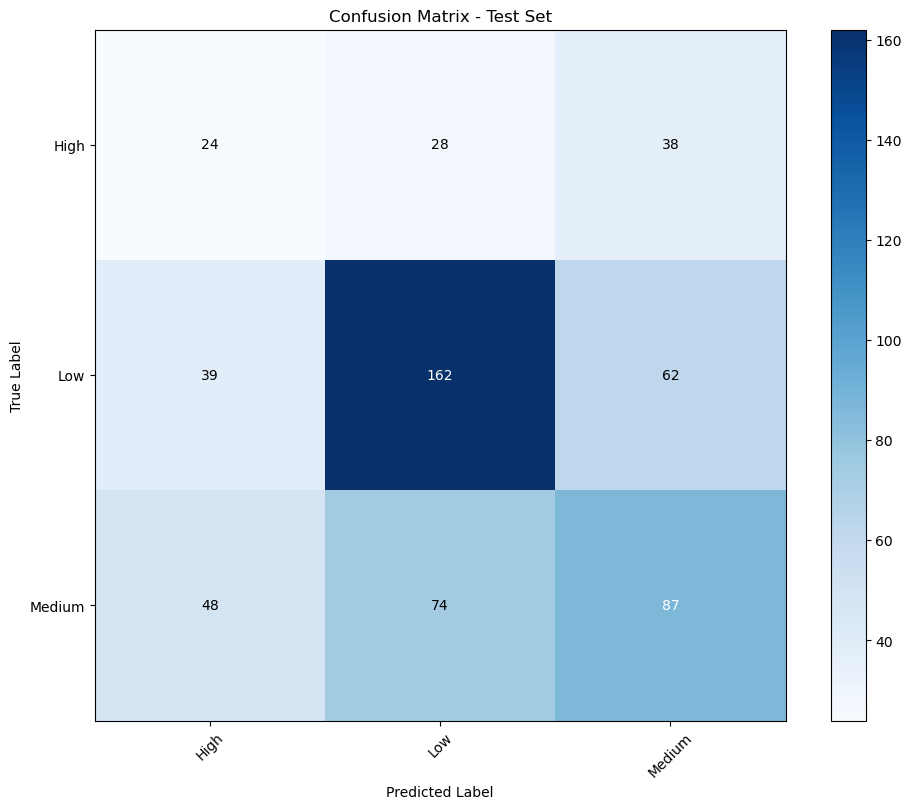

Final model accuracy on validation set: 0.5150
Final model accuracy on test set: 0.4858


In [18]:
# XGBoost + SMOTE with Time-Sliced Features (Fixed Version)
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

def load_and_process_data(data_split_file, audio_dir, feature_extractor):
    """
    Load and process data using existing time-sliced feature extraction
    
    Args:
        data_split_file: Path to CSV file with filenames and labels
        audio_dir: Directory containing audio files
        feature_extractor: TimeSlicingFeatureExtractor instance
        
    Returns:
        X_features: Processed features ready for XGBoost
        y_labels: Class labels
    """
    # Load data split
    df = pd.read_csv(data_split_file)
    
    # Initialize lists for features and labels
    X_features = []
    y_labels = []
    
    # Process each audio file
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Processing data"):
        try:
            # Get filename and label
            filename = row['filename']
            label = row['clarity_label']
            
            # Find audio file
            file_path = os.path.join(audio_dir, filename)
            
            # Search recursively if needed
            if not os.path.exists(file_path):
                found = False
                for root, _, files in os.walk(audio_dir):
                    for file in files:
                        if file == filename:
                            file_path = os.path.join(root, file)
                            found = True
                            break
                    if found:
                        break
                        
                if not found:
                    continue
            
            # Preprocess audio
            processed_audio = preprocess_audio(file_path, sr=16000, target_duration_sec=2.0)
            if processed_audio is None:
                continue
                
            # Extract time-sliced features using your existing extractor
            features_sequence = feature_extractor.extract_features_from_time_slices(processed_audio)
            
            # Process the sequence for XGBoost - we'll use two approaches:
            
            # Approach 1: Use statistics of each feature across time
            feature_means = np.mean(features_sequence, axis=0)  # Mean over time
            feature_stds = np.std(features_sequence, axis=0)    # Std over time
            feature_stats = np.concatenate([feature_means, feature_stds])
            
            # Add to dataset
            X_features.append(feature_stats)
            y_labels.append(label)
            
        except Exception as e:
            print(f"Error processing {filename if 'filename' in locals() else 'unknown'}: {e}")
    
    return np.array(X_features), np.array(y_labels)

def train_xgboost_with_smote(X_train, y_train, X_val, y_val):
    """
    Train XGBoost classifier with SMOTE oversampling
    
    Args:
        X_train: Training features
        y_train: Training labels
        X_val: Validation features
        y_val: Validation labels
        
    Returns:
        Trained model, scaler, and evaluation metrics
    """
    print("Original class distribution:")
    print(Counter(y_train))
    
    # Encode class labels (important for XGBoost)
    label_encoder = LabelEncoder()
    label_encoder.fit(np.concatenate([y_train, y_val]))  # Fit on all labels
    
    y_train_encoded = label_encoder.transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    
    print("Label mapping:")
    for i, label in enumerate(label_encoder.classes_):
        print(f"  {label} -> {i}")
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Apply SMOTE oversampling
    print("\nApplying SMOTE oversampling...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_encoded)
    
    print("Resampled class distribution:")
    print(Counter(y_train_resampled))
    
    # Train XGBoost model
    print("\nTraining XGBoost model...")
    model = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    )
    
    # Create evaluation set
    eval_set = [(X_train_resampled, y_train_resampled), (X_val_scaled, y_val_encoded)]
    
    # Fit model
    model.fit(
        X_train_resampled, 
        y_train_resampled,
        eval_set=eval_set,
        verbose=True
    )
    
    # Make predictions
    y_pred_encoded = model.predict(X_val_scaled)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    
    # Evaluate
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    
    print(f"\nXGBoost Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - XGBoost with SMOTE')
    plt.colorbar()
    
    # Add labels
    classes = np.unique(y_val)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Generate feature importance visualization
    # Create feature names
    feature_names = []
    for i in range(40):  # 40 features per time slice
        feature_names.append(f"Mean_Feature_{i}")
    for i in range(40):
        feature_names.append(f"Std_Feature_{i}")
    
    # Get feature importance
    importance = model.feature_importances_
    
    # Sort features by importance
    indices = np.argsort(importance)[::-1]
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    plt.title('Top 20 Feature Importances')
    plt.bar(range(20), importance[indices[:20]])
    plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Save model and scaler
    model_package = {
        'model': model,
        'scaler': scaler,
        'label_encoder': label_encoder,
        'accuracy': accuracy,
        'report': report,
        'feature_names': feature_names
    }
    
    with open('xgboost_clarity_model.pkl', 'wb') as f:
        pickle.dump(model_package, f)
    
    print("Model saved to 'xgboost_clarity_model.pkl'")
    
    return model, scaler, label_encoder, accuracy, report

def evaluate_on_test(model, scaler, label_encoder, test_split, audio_dir, feature_extractor):
    """
    Evaluate the trained model on test set
    
    Args:
        model: Trained XGBoost model
        scaler: Fitted scaler
        label_encoder: Fitted label encoder
        test_split: Path to test CSV file
        audio_dir: Directory with audio files
        feature_extractor: TimeSlicingFeatureExtractor instance
        
    Returns:
        Test accuracy and report
    """
    # Load and process test data
    print("Loading and processing test data...")
    X_test, y_test = load_and_process_data(test_split, audio_dir, feature_extractor)
    
    # Scale features
    X_test_scaled = scaler.transform(X_test)
    
    # Make predictions
    y_pred_encoded = model.predict(X_test_scaled)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nTest Classification Report:")
    print(report)
    
    print("\nTest Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Test Set')
    plt.colorbar()
    
    # Add labels
    classes = np.unique(y_test)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy, report

# Run the complete pipeline
# Assume preprocess_audio is defined as in your existing code
# Assume TimeSlicingFeatureExtractor is your existing class

# Create feature extractor instance
feature_extractor = TimeSlicingFeatureExtractor(
    sr=16000,
    time_window_ms=100,
    n_mfcc=13,
    lpc_order=14,
    dct_length=13
)

# Set paths
train_split = "data_splits/train.csv"
val_split = "data_splits/validation.csv"
test_split = "data_splits/test.csv"
audio_dir = "./extracted_audio_data/Audios and excels/Cleaned_Audios"

# Process data using your existing time slicing
print("Processing training data...")
X_train, y_train = load_and_process_data(train_split, audio_dir, feature_extractor)

print("Processing validation data...")
X_val, y_val = load_and_process_data(val_split, audio_dir, feature_extractor)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]} samples, {X_val.shape[1]} features")

# Train model with SMOTE
model, scaler, label_encoder, accuracy, report = train_xgboost_with_smote(X_train, y_train, X_val, y_val)

# Evaluate on test set
test_accuracy, test_report = evaluate_on_test(model, scaler, label_encoder, test_split, audio_dir, feature_extractor)

print(f"Final model accuracy on validation set: {accuracy:.4f}")
print(f"Final model accuracy on test set: {test_accuracy:.4f}")

Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40
Processing training data...


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:   0%|                         | 6/2685 [00:00<02:01, 22.10it/s]

Error loading 102_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:   2%|▍                       | 43/2685 [00:02<01:54, 23.00it/s]

Error loading 107_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:   3%|▊                       | 92/2685 [00:04<01:41, 25.51it/s]

Error loading 108_s43.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:   8%|█▊                     | 213/2685 [00:09<01:40, 24.58it/s]

Error loading 108_s31.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  11%|██▍                    | 289/2685 [00:12<01:33, 25.67it/s]

Error loading 108_s50.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  11%|██▌                    | 302/2685 [00:13<01:35, 25.03it/s]

Error loading 106_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  12%|██▊                    | 324/2685 [00:14<01:40, 23.51it/s]

Error loading 107_s18.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  19%|████▎                  | 499/2685 [00:21<01:30, 24.28it/s]

Error loading 108_s26.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  24%|█████▍                 | 640/2685 [00:28<01:28, 23.07it/s]

Error loading 102_s8.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  26%|██████                 | 710/2685 [00:31<01:23, 23.59it/s]

Error loading 105_s21.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  33%|███████▋               | 893/2685 [00:39<01:07, 26.48it/s]

Error loading 107_s25.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  34%|███████▊               | 915/2685 [00:40<01:11, 24.89it/s]

Error loading 102_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading 108_s52.mp3: 
Error loading 108_s40.mp3: 
Error loading 108_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  36%|████████▎              | 975/2685 [00:43<01:16, 22.23it/s]

Error loading 108_s21.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  37%|████████▌              | 997/2685 [00:43<01:07, 24.98it/s]

Error loading 107_s27.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  38%|████████▎             | 1007/2685 [00:44<01:11, 23.51it/s]

Error loading 106_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  38%|████████▍             | 1023/2685 [00:45<01:04, 25.94it/s]

Error loading 108_s10.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  40%|████████▋             | 1063/2685 [00:46<01:04, 25.02it/s]

Error loading 106_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  40%|████████▊             | 1070/2685 [00:47<01:00, 26.50it/s]

Error loading 106_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  44%|█████████▋            | 1176/2685 [00:51<01:02, 24.11it/s]

Error loading 108_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  45%|█████████▊            | 1198/2685 [00:52<01:03, 23.40it/s]

Error loading 107_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  46%|██████████▏           | 1247/2685 [00:54<00:54, 26.30it/s]

Error loading 108_s23.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  47%|██████████▎           | 1253/2685 [00:55<00:57, 24.81it/s]

Error loading 108_s36.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  47%|██████████▍           | 1275/2685 [00:56<01:00, 23.49it/s]

Error loading 107_s26.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  49%|██████████▊           | 1327/2685 [00:58<01:09, 19.46it/s]

Error loading 107_s31.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  51%|███████████▏          | 1361/2685 [01:00<00:58, 22.61it/s]

Error loading 105_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  51%|███████████▎          | 1377/2685 [01:00<00:53, 24.50it/s]

Error loading 107_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  52%|███████████▍          | 1402/2685 [01:02<00:54, 23.74it/s]

Error loading 108_s17.mp3: 
Error loading 107_s30.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  53%|███████████▌          | 1413/2685 [01:02<00:46, 27.22it/s]

Error loading 108_s47.mp3: 
Error loading 108_s34.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  53%|███████████▋          | 1423/2685 [01:02<00:48, 25.77it/s]

Error loading 102_s11.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  54%|███████████▉          | 1454/2685 [01:04<00:52, 23.26it/s]

Error loading 108_s41.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  55%|███████████▉          | 1464/2685 [01:04<00:49, 24.52it/s]

Error loading 107_s9.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading 106_s19.mp3: 
Error loading 102_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  56%|████████████▎         | 1506/2685 [01:06<00:42, 27.98it/s]

Error loading 107_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  57%|████████████▌         | 1531/2685 [01:07<00:47, 24.54it/s]

Error loading 108_s35.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  58%|████████████▋         | 1544/2685 [01:08<00:46, 24.79it/s]

Error loading 108_s8.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  58%|████████████▊         | 1557/2685 [01:08<00:46, 24.02it/s]

Error loading 108_s51.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  60%|█████████████▏        | 1617/2685 [01:11<00:42, 24.84it/s]

Error loading 108_s27.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  61%|█████████████▍        | 1633/2685 [01:12<00:43, 24.09it/s]

Error loading 108_s54.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  61%|█████████████▍        | 1643/2685 [01:12<00:42, 24.43it/s]

Error loading 107_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  64%|██████████████▏       | 1728/2685 [01:16<00:38, 24.63it/s]

Error loading 107_s10.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  65%|██████████████▎       | 1753/2685 [01:17<00:36, 25.28it/s]

Error loading 102_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  66%|██████████████▍       | 1763/2685 [01:17<00:36, 25.36it/s]

Error loading 106_s18.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  67%|██████████████▋       | 1791/2685 [01:18<00:38, 23.31it/s]

Error loading 107_s23.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  67%|██████████████▋       | 1798/2685 [01:19<00:37, 23.89it/s]

Error loading 108_s9.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  67%|██████████████▊       | 1805/2685 [01:19<00:35, 24.54it/s]

Error loading 105_s22.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  69%|███████████████▏      | 1859/2685 [01:21<00:35, 23.01it/s]

Error loading 102_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  72%|███████████████▊      | 1926/2685 [01:24<00:30, 25.11it/s]

Error loading 108_s53.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  73%|███████████████▉      | 1948/2685 [01:25<00:31, 23.23it/s]

Error loading 108_s32.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading 102_s16.mp3: 
Error loading 107_s21.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  76%|████████████████▋     | 2036/2685 [01:29<00:26, 24.10it/s]

Error loading 107_s16.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  76%|████████████████▊     | 2046/2685 [01:30<00:26, 24.07it/s]

Error loading 108_s49.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  77%|████████████████▉     | 2067/2685 [01:31<00:27, 22.67it/s]

Error loading 108_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  79%|█████████████████▎    | 2116/2685 [01:33<00:24, 22.78it/s]

Error loading 108_s38.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  82%|█████████████████▉    | 2190/2685 [01:36<00:20, 23.83it/s]

Error loading 106_s16.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  82%|██████████████████    | 2212/2685 [01:37<00:20, 23.44it/s]

Error loading 108_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  83%|██████████████████▎   | 2234/2685 [01:38<00:17, 26.44it/s]

Error loading 107_s11.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  84%|██████████████████▍   | 2252/2685 [01:39<00:18, 23.71it/s]

Error loading 108_s16.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  86%|██████████████████▉   | 2307/2685 [01:41<00:14, 25.63it/s]

Error loading 107_s22.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading 108_s39.mp3: 
Error loading 102_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  90%|███████████████████▊  | 2414/2685 [01:46<00:11, 24.29it/s]

Error loading 108_s46.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  92%|████████████████████▏ | 2457/2685 [01:48<00:09, 24.92it/s]

Error loading 108_s25.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  92%|████████████████████▎ | 2476/2685 [01:49<00:08, 24.79it/s]

Error loading 102_s9.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  94%|████████████████████▋ | 2528/2685 [01:51<00:06, 24.01it/s]

Error loading 106_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  95%|████████████████████▉ | 2550/2685 [01:52<00:05, 23.31it/s]

Error loading 108_s44.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  95%|████████████████████▉ | 2557/2685 [01:52<00:05, 24.47it/s]

Error loading 108_s45.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  98%|█████████████████████▍| 2621/2685 [01:55<00:02, 23.90it/s]

Error loading 105_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  98%|█████████████████████▌| 2636/2685 [01:56<00:02, 23.38it/s]

Error loading 108_s29.mp3: 


Processing data: 100%|██████████████████████| 2685/2685 [01:58<00:00, 22.65it/s]


Processing validation data...


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  16%|███▉                     | 91/576 [00:03<00:20, 23.97it/s]

Error loading 108_s30.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  32%|███████▋                | 183/576 [00:08<00:16, 23.86it/s]

Error loading 106_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  40%|█████████▋              | 232/576 [00:10<00:14, 23.42it/s]

Error loading 102_s18.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  46%|███████████             | 264/576 [00:11<00:11, 28.11it/s]

Error loading 102_s10.mp3: 
Error loading 107_s29.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  50%|███████████▉            | 286/576 [00:13<00:12, 23.21it/s]

Error loading 107_s28.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  80%|███████████████████     | 458/576 [00:20<00:05, 23.36it/s]

Error loading 105_s23.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  83%|███████████████████▉    | 477/576 [00:21<00:03, 24.92it/s]

Error loading 108_s11.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  92%|██████████████████████  | 529/576 [00:23<00:01, 26.98it/s]

Error loading 108_s42.mp3: 


Processing data: 100%|████████████████████████| 576/576 [00:26<00:00, 22.12it/s]


Training set: 2610 samples, 800 features
Validation set: 567 samples, 800 features
Original class distribution:
Counter({np.str_('Low'): 1213, np.str_('Medium'): 977, np.str_('High'): 420})
Label mapping:
  High -> 0
  Low -> 1
  Medium -> 2

Applying SMOTE oversampling...
Resampled class distribution:
Counter({np.int64(1): 1213, np.int64(2): 1213, np.int64(0): 1213})

Training XGBoost model...
[0]	validation_0-mlogloss:1.07116	validation_1-mlogloss:1.09304
[1]	validation_0-mlogloss:1.04462	validation_1-mlogloss:1.08799
[2]	validation_0-mlogloss:1.01963	validation_1-mlogloss:1.08343
[3]	validation_0-mlogloss:0.99746	validation_1-mlogloss:1.08079
[4]	validation_0-mlogloss:0.97770	validation_1-mlogloss:1.07631
[5]	validation_0-mlogloss:0.95830	validation_1-mlogloss:1.06824
[6]	validation_0-mlogloss:0.93629	validation_1-mlogloss:1.06399
[7]	validation_0-mlogloss:0.91754	validation_1-mlogloss:1.06248
[8]	validation_0-mlogloss:0.90267	validation_1-mlogloss:1.06204
[9]	validation_0-mlogloss:

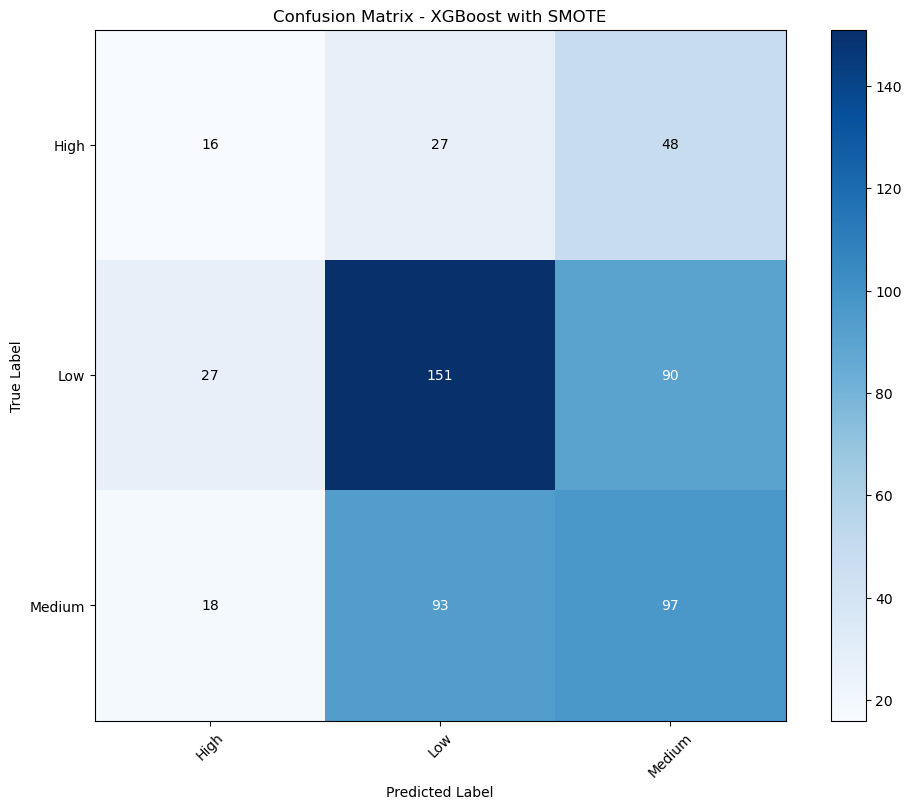

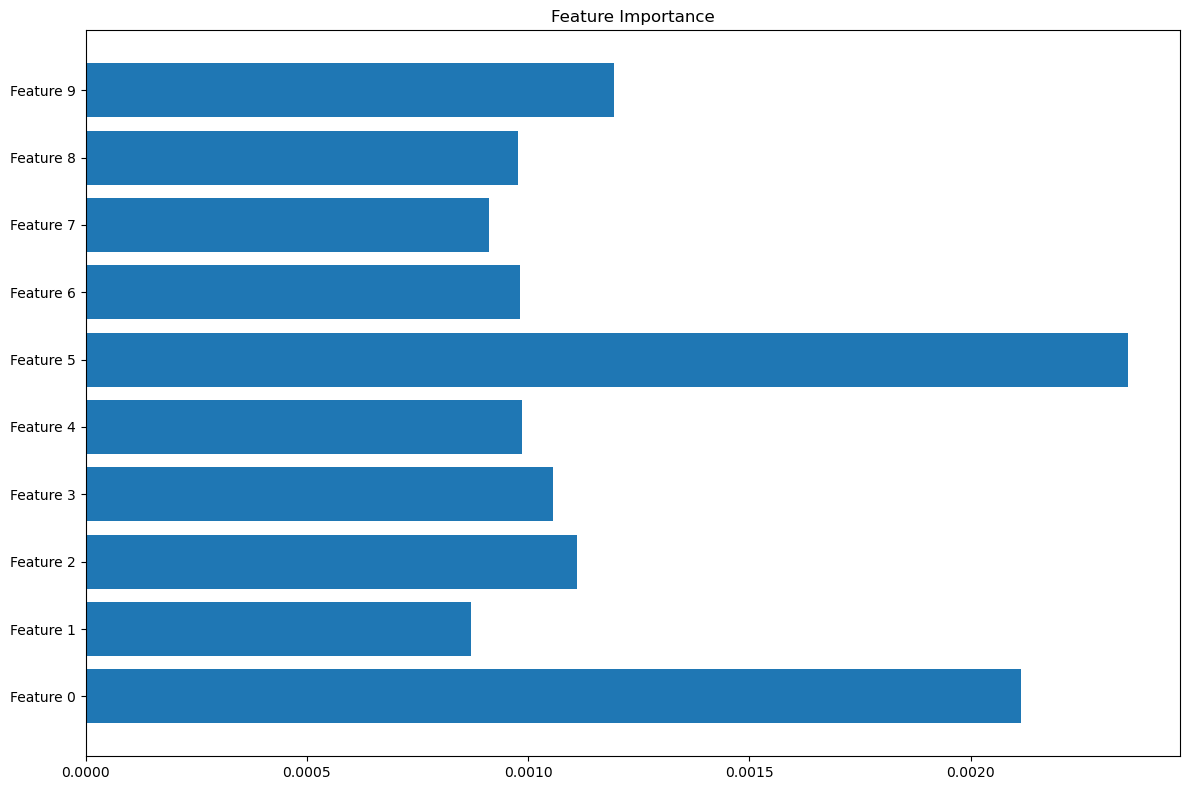

Model saved to 'xgboost_clarity_model.pkl'
Loading and processing test data...


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:   6%|█▍                       | 32/576 [00:01<00:20, 26.71it/s]

Error loading 107_s20.mp3: 
Error loading 108_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  16%|███▉                     | 92/576 [00:04<00:19, 24.51it/s]

Error loading 108_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  34%|████████▎               | 198/576 [00:09<00:14, 25.90it/s]

Error loading 108_s37.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  39%|█████████▎              | 223/576 [00:10<00:15, 23.52it/s]

Error loading 108_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  53%|████████████▊           | 307/576 [00:14<00:11, 23.55it/s]

Error loading 108_s48.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  55%|█████████████▎          | 319/576 [00:15<00:13, 18.50it/s]

Error loading 108_s28.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  61%|██████████████▋         | 353/576 [00:18<00:11, 19.80it/s]

Error loading 107_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  79%|██████████████████▉     | 455/576 [00:22<00:05, 23.35it/s]

Error loading 102_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  81%|███████████████████▍    | 467/576 [00:23<00:04, 23.05it/s]

Error loading 107_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  83%|███████████████████▉    | 479/576 [00:23<00:04, 21.45it/s]

Error loading 108_s22.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  85%|████████████████████▌   | 492/576 [00:24<00:03, 22.63it/s]

Error loading 105_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  87%|████████████████████▉   | 501/576 [00:24<00:03, 22.45it/s]

Error loading 108_s33.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Processing data:  94%|██████████████████████▌ | 541/576 [00:26<00:01, 24.47it/s]

Error loading 108_s18.mp3: 


Processing data: 100%|████████████████████████| 576/576 [00:28<00:00, 20.30it/s]



Test Accuracy: 0.4537

Test Classification Report:
              precision    recall  f1-score   support

        High       0.20      0.16      0.17        90
         Low       0.53      0.58      0.55       263
      Medium       0.44      0.43      0.43       209

    accuracy                           0.45       562
   macro avg       0.39      0.39      0.39       562
weighted avg       0.44      0.45      0.45       562


Test Confusion Matrix:
[[ 14  43  33]
 [ 29 152  82]
 [ 28  92  89]]


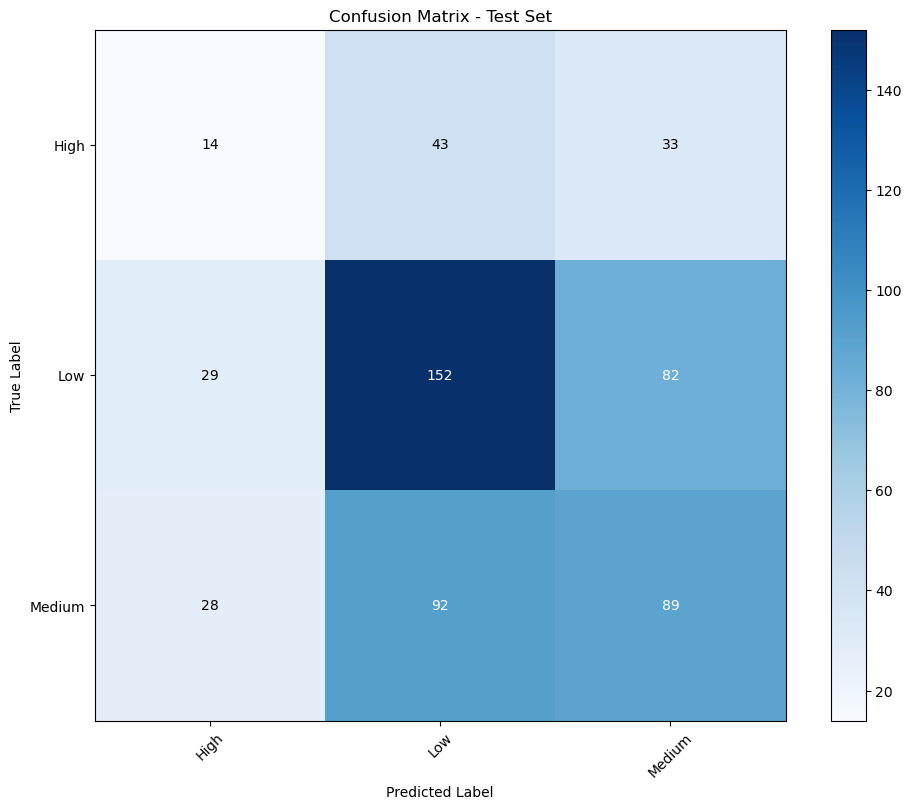

Final model accuracy on validation set: 0.4656
Final model accuracy on test set: 0.4537


In [19]:
# XGBoost + SMOTE implementation that uses your existing time-sliced features
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

def prepare_features_from_timeslices(data_split_file, audio_dir, feature_extractor, process_func):
    """
    Prepare features for XGBoost using your existing time-sliced extraction and processing
    
    Args:
        data_split_file: Path to CSV file with filenames and labels
        audio_dir: Directory containing audio files
        feature_extractor: Your TimeSlicingFeatureExtractor instance
        process_func: Your process_features function for feature processing
        
    Returns:
        X_features: Processed features ready for XGBoost
        y_labels: Class labels
    """
    # Load data split
    df = pd.read_csv(data_split_file)
    
    # Initialize lists for features and labels
    X_features = []
    y_labels = []
    
    # Process each audio file
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Processing data"):
        try:
            # Get filename and label
            filename = row['filename']
            label = row['clarity_label']
            
            # Find audio file
            file_path = os.path.join(audio_dir, filename)
            
            # Search recursively if needed
            if not os.path.exists(file_path):
                found = False
                for root, _, files in os.walk(audio_dir):
                    for file in files:
                        if file == filename:
                            file_path = os.path.join(root, file)
                            found = True
                            break
                    if found:
                        break
                        
                if not found:
                    continue
            
            # Preprocess audio
            processed_audio = preprocess_audio(file_path, sr=16000, target_duration_sec=2.0)
            if processed_audio is None:
                continue
                
            # Extract time-sliced features using your existing extractor
            features_sequence = feature_extractor.extract_features_from_time_slices(processed_audio)
            
            # Process features using your existing process_features function
            # Option 1: Keep sequential
            # processed_features = process_func(features_sequence, flatten=False, standardize=True)
            
            # Option 2: Use PCA reduction
            # processed_features = process_func(features_sequence, flatten=False, standardize=True, 
            #                                 reduce_features=True, reduction_method='pca', n_components=20)
            
            # Option 3: Flatten (best for XGBoost)
            processed_features = process_func(features_sequence, flatten=True, standardize=True)
            
            # Add to dataset
            X_features.append(processed_features)
            y_labels.append(label)
            
        except Exception as e:
            print(f"Error processing {filename if 'filename' in locals() else 'unknown'}: {e}")
    
    return np.array(X_features), np.array(y_labels)

def train_xgboost_with_smote(X_train, y_train, X_val, y_val):
    """
    Train XGBoost classifier with SMOTE oversampling
    
    Args:
        X_train: Training features
        y_train: Training labels
        X_val: Validation features
        y_val: Validation labels
        
    Returns:
        Trained model, label encoder, and evaluation metrics
    """
    print("Original class distribution:")
    print(Counter(y_train))
    
    # Encode class labels (important for XGBoost)
    label_encoder = LabelEncoder()
    label_encoder.fit(np.concatenate([y_train, y_val]))  # Fit on all labels
    
    y_train_encoded = label_encoder.transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    
    print("Label mapping:")
    for i, label in enumerate(label_encoder.classes_):
        print(f"  {label} -> {i}")
    
    # Apply SMOTE oversampling
    print("\nApplying SMOTE oversampling...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
    
    print("Resampled class distribution:")
    print(Counter(y_train_resampled))
    
    # Train XGBoost model
    print("\nTraining XGBoost model...")
    model = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    )
    
    # Create evaluation set
    eval_set = [(X_train_resampled, y_train_resampled), (X_val, y_val_encoded)]
    
    # Fit model
    model.fit(
        X_train_resampled, 
        y_train_resampled,
        eval_set=eval_set,
        verbose=True
    )
    
    # Make predictions
    y_pred_encoded = model.predict(X_val)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    
    # Evaluate
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    
    print(f"\nXGBoost Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - XGBoost with SMOTE')
    plt.colorbar()
    
    # Add labels
    classes = np.unique(y_val)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Feature importance
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importance')
    plt.barh(range(10), model.feature_importances_[:10])
    plt.yticks(range(10), [f"Feature {i}" for i in range(10)])
    plt.tight_layout()
    plt.show()
    
    # Save model and label encoder
    model_package = {
        'model': model,
        'label_encoder': label_encoder,
        'accuracy': accuracy,
        'report': report
    }
    
    with open('xgboost_clarity_model.pkl', 'wb') as f:
        pickle.dump(model_package, f)
    
    print("Model saved to 'xgboost_clarity_model.pkl'")
    
    return model, label_encoder, accuracy, report

def evaluate_on_test(model, label_encoder, test_split, audio_dir, feature_extractor, process_func):
    """
    Evaluate the trained model on test set
    
    Args:
        model: Trained XGBoost model
        label_encoder: Fitted label encoder
        test_split: Path to test CSV file
        audio_dir: Directory with audio files
        feature_extractor: Your TimeSlicingFeatureExtractor instance
        process_func: Your process_features function
        
    Returns:
        Test accuracy and report
    """
    # Load and process test data
    print("Loading and processing test data...")
    X_test, y_test = prepare_features_from_timeslices(
        test_split, audio_dir, feature_extractor, process_func
    )
    
    # Make predictions
    y_pred_encoded = model.predict(X_test)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nTest Classification Report:")
    print(report)
    
    print("\nTest Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Test Set')
    plt.colorbar()
    
    # Add labels
    classes = np.unique(y_test)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy, report

# Run the complete pipeline
# Set paths
train_split = "data_splits/train.csv"
val_split = "data_splits/validation.csv"
test_split = "data_splits/test.csv"
audio_dir = "./extracted_audio_data/Audios and excels/Cleaned_Audios"

# Create feature extractor instance - using your existing class
feature_extractor = TimeSlicingFeatureExtractor(
    sr=16000,
    time_window_ms=100,
    n_mfcc=13,
    lpc_order=14,
    dct_length=13
)

# Process data using your existing feature extraction and processing
print("Processing training data...")
X_train, y_train = prepare_features_from_timeslices(
    train_split, audio_dir, feature_extractor, process_features
)

print("Processing validation data...")
X_val, y_val = prepare_features_from_timeslices(
    val_split, audio_dir, feature_extractor, process_features
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]} samples, {X_val.shape[1]} features")

# Train model with SMOTE
model, label_encoder, accuracy, report = train_xgboost_with_smote(X_train, y_train, X_val, y_val)

# Evaluate on test set
test_accuracy, test_report = evaluate_on_test(
    model, label_encoder, test_split, audio_dir, 
    feature_extractor, process_features
)

print(f"Final model accuracy on validation set: {accuracy:.4f}")
print(f"Final model accuracy on test set: {test_accuracy:.4f}")

In [24]:
!pip install tensorflow

  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached markdown-3.8-py3-none-any.whl.metadata (5.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.0.9-py3-none-any.whl.metadata (322 bytes)
  Using cached markdown_it_py-3.0.0-py3-

=== Data Preparation ===
Preparing training dataset...
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   0%|                       | 6/2685 [00:00<02:06, 21.11it/s]

Error loading 102_s12.mp3: 
Error processing 102_s12.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   2%|▎                     | 43/2685 [00:02<01:53, 23.19it/s]

Error loading 107_s17.mp3: 
Error processing 107_s17.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   3%|▋                     | 90/2685 [00:04<01:46, 24.27it/s]

Error loading 108_s43.mp3: 
Error processing 108_s43.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   8%|█▋                   | 211/2685 [00:10<01:47, 23.07it/s]

Error loading 108_s31.mp3: 
Error processing 108_s31.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  11%|██▎                  | 290/2685 [00:13<01:39, 24.02it/s]

Error loading 108_s50.mp3: 
Error processing 108_s50.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  11%|██▎                  | 300/2685 [00:14<01:36, 24.60it/s]

Error loading 106_s13.mp3: 
Error processing 106_s13.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  12%|██▌                  | 321/2685 [00:15<01:41, 23.20it/s]

Error loading 107_s18.mp3: 
Error processing 107_s18.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  19%|███▉                 | 499/2685 [00:23<01:34, 23.19it/s]

Error loading 108_s26.mp3: 
Error processing 108_s26.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  24%|█████                | 640/2685 [00:29<01:30, 22.58it/s]

Error loading 102_s8.mp3: 
Error processing 102_s8.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  26%|█████▌               | 710/2685 [00:32<01:27, 22.67it/s]

Error loading 105_s21.mp3: 
Error processing 105_s21.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  33%|██████▉              | 894/2685 [00:41<01:14, 24.17it/s]

Error loading 107_s25.mp3: 
Error processing 107_s25.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  34%|███████▏             | 916/2685 [00:42<01:13, 24.09it/s]

Error loading 102_s17.mp3: 
Error processing 102_s17.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading 108_s52.mp3: 
Error processing 108_s52.mp3: object of type 'NoneType' has no len()
Error loading 108_s40.mp3: 
Error processing 108_s40.mp3: object of type 'NoneType' has no len()
Error loading 108_s15.mp3: 
Error processing 108_s15.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  36%|███████▋             | 976/2685 [00:45<01:20, 21.35it/s]

Error loading 108_s21.mp3: 
Error processing 108_s21.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  37%|███████▊             | 998/2685 [00:46<01:15, 22.45it/s]

Error loading 107_s27.mp3: 
Error processing 107_s27.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  38%|███████▌            | 1007/2685 [00:46<01:16, 21.81it/s]

Error loading 106_s17.mp3: 
Error processing 106_s17.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  38%|███████▌            | 1023/2685 [00:47<01:08, 24.28it/s]

Error loading 108_s10.mp3: 
Error processing 108_s10.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  40%|███████▉            | 1063/2685 [00:48<01:07, 24.04it/s]

Error loading 106_s15.mp3: 
Error processing 106_s15.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  40%|███████▉            | 1070/2685 [00:49<01:04, 25.09it/s]

Error loading 106_s14.mp3: 
Error processing 106_s14.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  44%|████████▊           | 1175/2685 [00:54<01:02, 24.04it/s]

Error loading 108_s12.mp3: 
Error processing 108_s12.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  45%|████████▉           | 1197/2685 [00:55<01:05, 22.88it/s]

Error loading 107_s15.mp3: 
Error processing 107_s15.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  46%|█████████▎          | 1248/2685 [00:57<00:59, 24.03it/s]

Error loading 108_s23.mp3: 
Error processing 108_s23.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  47%|█████████▎          | 1254/2685 [00:57<01:02, 22.73it/s]

Error loading 108_s36.mp3: 
Error processing 108_s36.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  47%|█████████▍          | 1275/2685 [00:58<01:01, 22.79it/s]

Error loading 107_s26.mp3: 
Error processing 107_s26.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  49%|█████████▉          | 1327/2685 [01:01<01:12, 18.70it/s]

Error loading 107_s31.mp3: 
Error processing 107_s31.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  51%|██████████▏         | 1361/2685 [01:02<00:59, 22.12it/s]

Error loading 105_s19.mp3: 
Error processing 105_s19.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  51%|██████████▎         | 1379/2685 [01:03<00:57, 22.65it/s]

Error loading 107_s13.mp3: 
Error processing 107_s13.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading 108_s17.mp3: 
Error processing 108_s17.mp3: object of type 'NoneType' has no len()
Error loading 107_s30.mp3: 
Error processing 107_s30.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  53%|██████████▌         | 1413/2685 [01:05<00:47, 26.53it/s]

Error loading 108_s47.mp3: 
Error processing 108_s47.mp3: object of type 'NoneType' has no len()
Error loading 108_s34.mp3: 
Error processing 108_s34.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  53%|██████████▌         | 1423/2685 [01:05<00:48, 25.87it/s]

Error loading 102_s11.mp3: 
Error processing 102_s11.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  54%|██████████▊         | 1454/2685 [01:07<00:55, 22.06it/s]

Error loading 108_s41.mp3: 
Error processing 108_s41.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  55%|██████████▉         | 1464/2685 [01:07<00:50, 24.35it/s]

Error loading 107_s9.mp3: 
Error processing 107_s9.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  56%|███████████▏        | 1501/2685 [01:09<00:47, 24.68it/s]

Error loading 106_s19.mp3: 
Error processing 106_s19.mp3: object of type 'NoneType' has no len()
Error loading 102_s14.mp3: 
Error processing 102_s14.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  56%|███████████▏        | 1505/2685 [01:09<00:44, 26.24it/s]

Error loading 107_s24.mp3: 
Error processing 107_s24.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  57%|███████████▍        | 1530/2685 [01:10<00:49, 23.38it/s]

Error loading 108_s35.mp3: 
Error processing 108_s35.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  57%|███████████▍        | 1542/2685 [01:10<00:48, 23.38it/s]

Error loading 108_s8.mp3: 
Error processing 108_s8.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  58%|███████████▌        | 1555/2685 [01:11<00:47, 23.93it/s]

Error loading 108_s51.mp3: 
Error processing 108_s51.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  60%|████████████        | 1618/2685 [01:14<00:44, 23.95it/s]

Error loading 108_s27.mp3: 
Error processing 108_s27.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  61%|████████████▏       | 1634/2685 [01:15<00:45, 23.06it/s]

Error loading 108_s54.mp3: 
Error processing 108_s54.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  61%|████████████▏       | 1644/2685 [01:15<00:43, 23.78it/s]

Error loading 107_s12.mp3: 
Error processing 107_s12.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  64%|████████████▊       | 1726/2685 [01:19<00:40, 23.65it/s]

Error loading 107_s10.mp3: 
Error processing 107_s10.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  65%|█████████████       | 1754/2685 [01:20<00:39, 23.51it/s]

Error loading 102_s19.mp3: 
Error processing 102_s19.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  66%|█████████████▏      | 1764/2685 [01:21<00:37, 24.43it/s]

Error loading 106_s18.mp3: 
Error processing 106_s18.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  67%|█████████████▎      | 1791/2685 [01:22<00:40, 22.05it/s]

Error loading 107_s23.mp3: 
Error processing 107_s23.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  67%|█████████████▍      | 1798/2685 [01:22<00:38, 23.28it/s]

Error loading 108_s9.mp3: 
Error processing 108_s9.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  67%|█████████████▍      | 1805/2685 [01:22<00:36, 24.24it/s]

Error loading 105_s22.mp3: 
Error processing 105_s22.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  69%|█████████████▊      | 1859/2685 [01:25<00:38, 21.68it/s]

Error loading 102_s15.mp3: 
Error processing 102_s15.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  72%|██████████████▎     | 1926/2685 [01:28<00:32, 23.56it/s]

Error loading 108_s53.mp3: 
Error processing 108_s53.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  73%|██████████████▌     | 1948/2685 [01:29<00:32, 22.85it/s]

Error loading 108_s32.mp3: 
Error processing 108_s32.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  75%|███████████████     | 2019/2685 [01:33<00:30, 21.63it/s]

Error loading 102_s16.mp3: 
Error processing 102_s16.mp3: object of type 'NoneType' has no len()
Error loading 107_s21.mp3: 
Error processing 107_s21.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  76%|███████████████▏    | 2035/2685 [01:34<00:27, 23.50it/s]

Error loading 107_s16.mp3: 
Error processing 107_s16.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  76%|███████████████▏    | 2045/2685 [01:34<00:26, 23.94it/s]

Error loading 108_s49.mp3: 
Error processing 108_s49.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  77%|███████████████▍    | 2067/2685 [01:35<00:27, 22.38it/s]

Error loading 108_s13.mp3: 
Error processing 108_s13.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  79%|███████████████▊    | 2116/2685 [01:37<00:25, 22.05it/s]

Error loading 108_s38.mp3: 
Error processing 108_s38.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  82%|████████████████▎   | 2192/2685 [01:41<00:21, 23.43it/s]

Error loading 106_s16.mp3: 
Error processing 106_s16.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  82%|████████████████▍   | 2210/2685 [01:42<00:21, 22.53it/s]

Error loading 108_s14.mp3: 
Error processing 108_s14.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  83%|████████████████▋   | 2235/2685 [01:43<00:18, 24.28it/s]

Error loading 107_s11.mp3: 
Error processing 107_s11.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  84%|████████████████▊   | 2253/2685 [01:44<00:20, 21.11it/s]

Error loading 108_s16.mp3: 
Error processing 108_s16.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  86%|█████████████████▏  | 2308/2685 [01:46<00:15, 23.63it/s]

Error loading 107_s22.mp3: 
Error processing 107_s22.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading 108_s39.mp3: 
Error processing 108_s39.mp3: object of type 'NoneType' has no len()
Error loading 102_s13.mp3: 
Error processing 102_s13.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  90%|█████████████████▉  | 2412/2685 [01:51<00:11, 23.93it/s]

Error loading 108_s46.mp3: 
Error processing 108_s46.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  92%|██████████████████▎ | 2458/2685 [01:53<00:09, 24.30it/s]

Error loading 108_s25.mp3: 
Error processing 108_s25.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  92%|██████████████████▍ | 2474/2685 [01:54<00:08, 24.46it/s]

Error loading 102_s9.mp3: 
Error processing 102_s9.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  94%|██████████████████▊ | 2529/2685 [01:56<00:06, 23.96it/s]

Error loading 106_s20.mp3: 
Error processing 106_s20.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  95%|██████████████████▉ | 2550/2685 [01:57<00:05, 22.93it/s]

Error loading 108_s44.mp3: 
Error processing 108_s44.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  95%|███████████████████ | 2557/2685 [01:57<00:05, 23.74it/s]

Error loading 108_s45.mp3: 
Error processing 108_s45.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  98%|███████████████████▌| 2621/2685 [02:00<00:02, 24.16it/s]

Error loading 105_s20.mp3: 
Error processing 105_s20.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  98%|███████████████████▋| 2639/2685 [02:01<00:01, 23.16it/s]

Error loading 108_s29.mp3: 
Error processing 108_s29.mp3: object of type 'NoneType' has no len()


Preparing dataset: 100%|████████████████████| 2685/2685 [02:03<00:00, 21.71it/s]


Preparing validation dataset...
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  16%|███▋                   | 91/576 [00:04<00:21, 22.48it/s]

Error loading 108_s30.mp3: 
Error processing 108_s30.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  32%|██████▉               | 182/576 [00:08<00:17, 22.33it/s]

Error loading 106_s12.mp3: 
Error processing 106_s12.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  40%|████████▊             | 230/576 [00:10<00:15, 22.42it/s]

Error loading 102_s18.mp3: 
Error processing 102_s18.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading 102_s10.mp3: 
Error processing 102_s10.mp3: object of type 'NoneType' has no len()
Error loading 107_s29.mp3: 
Error processing 107_s29.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  50%|██████████▉           | 286/576 [00:13<00:12, 22.31it/s]

Error loading 107_s28.mp3: 
Error processing 107_s28.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  80%|█████████████████▌    | 459/576 [00:21<00:05, 22.54it/s]

Error loading 105_s23.mp3: 
Error processing 105_s23.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  83%|██████████████████▎   | 478/576 [00:22<00:04, 22.50it/s]

Error loading 108_s11.mp3: 
Error processing 108_s11.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  92%|████████████████████▏ | 530/576 [00:24<00:01, 23.05it/s]

Error loading 108_s42.mp3: 
Error processing 108_s42.mp3: object of type 'NoneType' has no len()


Preparing dataset: 100%|██████████████████████| 576/576 [00:27<00:00, 21.25it/s]


Preparing test dataset...
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   6%|█▎                     | 32/576 [00:01<00:20, 26.97it/s]

Error loading 107_s20.mp3: 
Error processing 107_s20.mp3: object of type 'NoneType' has no len()
Error loading 108_s24.mp3: 
Error processing 108_s24.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  16%|███▋                   | 93/576 [00:04<00:20, 23.23it/s]

Error loading 108_s19.mp3: 
Error processing 108_s19.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  35%|███████▌              | 199/576 [00:09<00:15, 24.14it/s]

Error loading 108_s37.mp3: 
Error processing 108_s37.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  39%|████████▌             | 224/576 [00:10<00:14, 24.17it/s]

Error loading 108_s20.mp3: 
Error processing 108_s20.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  53%|███████████▊          | 308/576 [00:14<00:10, 24.52it/s]

Error loading 108_s48.mp3: 
Error processing 108_s48.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  55%|████████████          | 317/576 [00:15<00:10, 23.75it/s]

Error loading 108_s28.mp3: 
Error processing 108_s28.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  61%|█████████████▌        | 354/576 [00:16<00:09, 24.47it/s]

Error loading 107_s14.mp3: 
Error processing 107_s14.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  79%|█████████████████▍    | 455/576 [00:21<00:05, 22.79it/s]

Error loading 102_s20.mp3: 
Error processing 102_s20.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  81%|█████████████████▊    | 467/576 [00:21<00:04, 23.22it/s]

Error loading 107_s19.mp3: 
Error processing 107_s19.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  83%|██████████████████▎   | 479/576 [00:22<00:04, 23.82it/s]

Error loading 108_s22.mp3: 
Error processing 108_s22.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  85%|██████████████████▊   | 492/576 [00:23<00:03, 25.31it/s]

Error loading 105_s24.mp3: 
Error processing 105_s24.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  88%|███████████████████▎  | 504/576 [00:23<00:03, 23.60it/s]

Error loading 108_s33.mp3: 
Error processing 108_s33.mp3: object of type 'NoneType' has no len()


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  94%|████████████████████▋ | 541/576 [00:25<00:01, 24.61it/s]

Error loading 108_s18.mp3: 
Error processing 108_s18.mp3: object of type 'NoneType' has no len()


Preparing dataset: 100%|██████████████████████| 576/576 [00:26<00:00, 21.50it/s]


Sorting MFCC features...
Training set: 2610 samples
Validation set: 567 samples
Test set: 562 samples

Training class distribution:
  Low: 1213 samples
  Medium: 977 samples
  High: 420 samples

Maximum sequence length: 20 time slices

Padded shapes:
  Training: (2610, 20, 40)
  Validation: (567, 20, 40)
  Test: (562, 20, 40)

=== Model Training ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 40)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 20, 256)   │    173,056 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 20, 128)   │    164,352 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 20, 128)   │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 20, 128)   │          0 │ dropout_1[0][0],  │
│ (Attention)         │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 20, 256)   │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ concatenate[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        195 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 354,051 (1.35 MB)

 Trainable params: 354,051 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: np.float64(2.0714285714285716), 1: np.float64(0.717230008244023), 2: np.float64(0.8904810644831116)}

Training LSTM model...
Epoch 1/100
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4127 - loss: 1.0851
Epoch 1: val_accuracy improved from -inf to 0.28924, saving model to best_lstm_clarity_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.4122 - loss: 1.0853 - val_accuracy: 0.2892 - val_loss: 1.1128 - learning_rate: 0.0010
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4458 - loss: 1.0686
Epoch 2: val_accuracy improved from 0.28924 to 0.47266, saving model to best_lstm_clarity_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.4457 - loss: 1.0686 - val_accuracy: 0.4727 - val_loss: 1.0218 - learning_rate: 0.0010
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4955 - loss: 1.0537
Epoch 3: val_accuracy did not improve from 0.47266
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.4953 - loss: 1.0537 - val_accuracy: 0.3704 - val_loss: 1.0854 - learning_rate: 0.0010
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4975 - loss: 1.0112
Epoch 4: val_accuracy did not improve from 0.47266
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.4972 - loss: 1.0115 - val_accuracy: 0.4339 - val_loss: 1.0760 - learning_rate: 0.0010
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5332 - loss: 1.0028
Epoch 5: val_accuracy did not improve from 0.47266
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5330 - loss: 1.0030 - val_accuracy: 0.4109 - val_loss: 1.0831 - learning_rate: 0.0010
Epoch 6/100
81/82 ━━━━━━━━━━━

82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5979 - loss: 0.8847 - val_accuracy: 0.4744 - val_loss: 1.0535 - learning_rate: 5.0000e-04
Epoch 9/100
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6965 - loss: 0.7094
Epoch 9: val_accuracy did not improve from 0.47443
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6961 - loss: 0.7096 - val_accuracy: 0.3986 - val_loss: 1.1710 - learning_rate: 5.0000e-04
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7419 - loss: 0.6051
Epoch 10: val_accuracy did not improve from 0.47443
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7417 - loss: 0.6053 - val_accuracy: 0.3968 - val_loss: 1.3177 - learning_rate: 5.0000e-04
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7631 - loss: 0.5409
Epoch 11: val_accuracy did not improve from 0.47443
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.7632 - loss: 0.5407 - val_accuracy: 0.4198 - val_loss: 1.2935 - learning_rate: 5.0000e-04
Epoch 12/

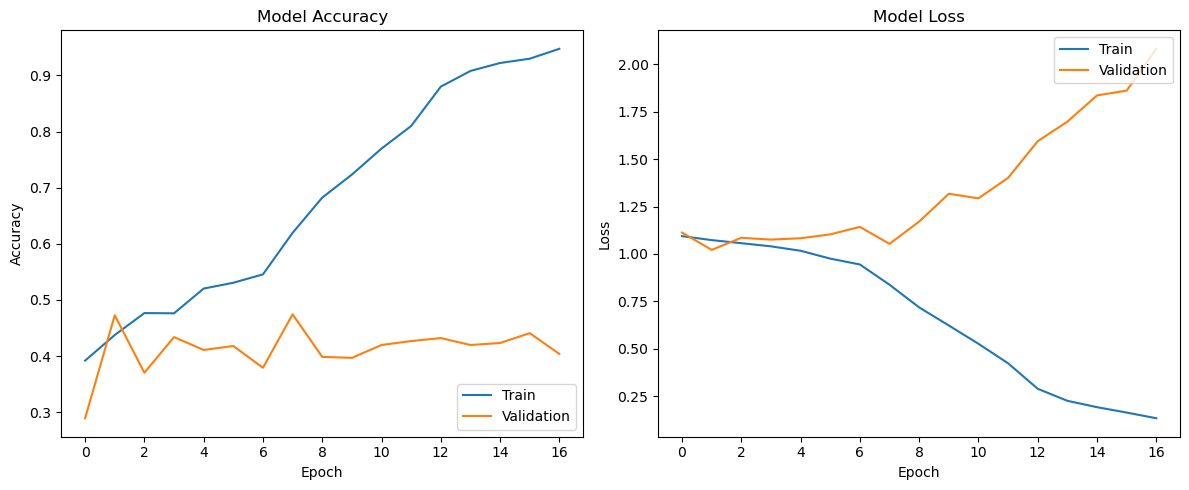


=== Model Evaluation ===
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step 

Test accuracy: 0.4573

Classification Report:
              precision    recall  f1-score   support

        High       0.20      0.13      0.16        90
         Low       0.50      0.74      0.60       263
      Medium       0.44      0.24      0.31       209

    accuracy                           0.46       562
   macro avg       0.38      0.37      0.36       562
weighted avg       0.43      0.46      0.42       562


Confusion Matrix:
[[ 12  58  20]
 [ 24 194  45]
 [ 23 135  51]]


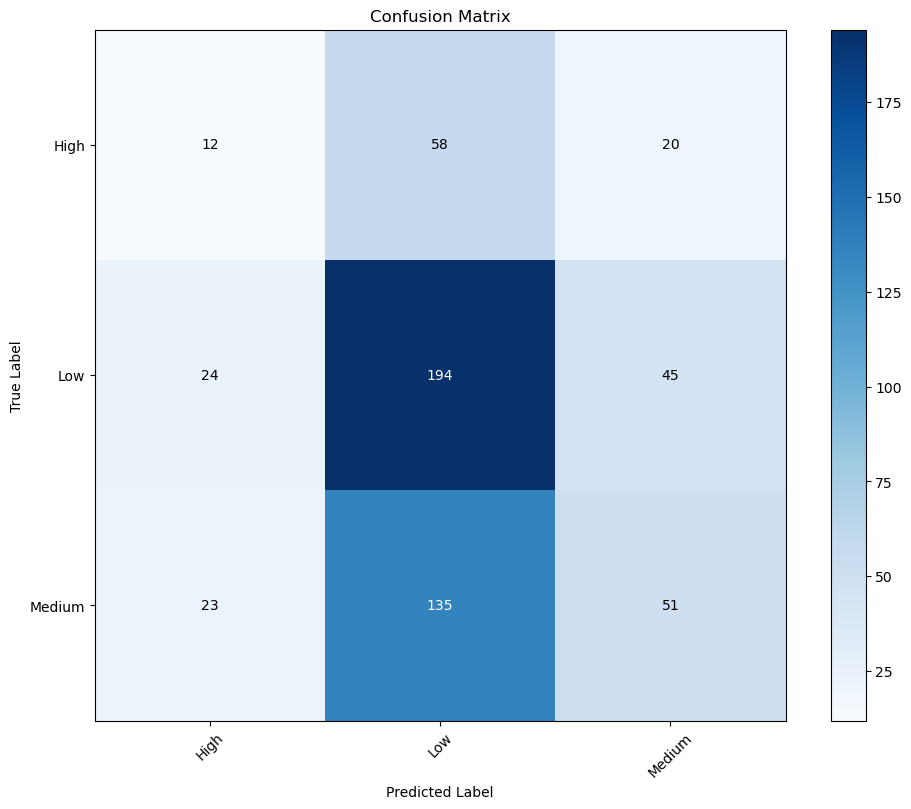


Model saved to 'final_lstm_clarity_model.h5'
Final test accuracy: 0.4573


In [25]:
# LSTM Implementation using 100ms Time-Sliced Features
# Import all required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
import time

# Use your existing TimeSlicingFeatureExtractor class from previous cells
# Assuming you already have these functions defined in previous cells:
# - TimeSlicingFeatureExtractor
# - preprocess_audio
# - process_features
# - prepare_dataset_for_lstm or prepare_dataset_for_hmm

# Define MFCC sorting function
def sort_mfcc_features(features_sequence, n_mfcc=13):
    """Sort only the MFCC portion of features by absolute magnitude"""
    sorted_features = features_sequence.copy()
    
    for i in range(sorted_features.shape[0]):
        mfccs = sorted_features[i, :n_mfcc]
        sorted_indices = np.argsort(-np.abs(mfccs))
        sorted_mfcc_values = mfccs[sorted_indices]
        sorted_features[i, :n_mfcc] = sorted_mfcc_values
    
    return sorted_features

# Prepare data for LSTM
def prepare_lstm_data(train_split, val_split, test_split, audio_dir, max_samples=None, sort_mfccs=True):
    """Prepare data for LSTM model using your existing feature extraction pipeline"""
    # Get data from your existing feature extraction pipeline
    print("Preparing training dataset...")
    X_train, y_train = prepare_dataset_for_hmm(
        train_split, audio_dir, 
        max_samples_per_class=max_samples
    )
    
    print("Preparing validation dataset...")
    X_val, y_val = prepare_dataset_for_hmm(
        val_split, audio_dir,
        max_samples_per_class=max_samples
    )
    
    print("Preparing test dataset...")
    X_test, y_test = prepare_dataset_for_hmm(
        test_split, audio_dir,
        max_samples_per_class=max_samples
    )
    
    # Sort MFCCs if requested
    if sort_mfccs:
        print("Sorting MFCC features...")
        X_train = [sort_mfcc_features(seq) for seq in X_train]
        X_val = [sort_mfcc_features(seq) for seq in X_val]
        X_test = [sort_mfcc_features(seq) for seq in X_test]
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    # Display class distribution
    train_class_counts = Counter(y_train)
    val_class_counts = Counter(y_val)
    test_class_counts = Counter(y_test)
    
    print("\nTraining class distribution:")
    for cls, count in train_class_counts.items():
        print(f"  {cls}: {count} samples")
    
    # Pad sequences to same length
    max_length = max(
        max(len(seq) for seq in X_train),
        max(len(seq) for seq in X_val),
        max(len(seq) for seq in X_test)
    )
    
    print(f"\nMaximum sequence length: {max_length} time slices")
    
    # Pad sequences
    def pad_sequences(sequences, max_length):
        padded_sequences = []
        for seq in sequences:
            if len(seq) < max_length:
                padding = np.zeros((max_length - len(seq), seq.shape[1]))
                padded_seq = np.vstack((seq, padding))
            else:
                padded_seq = seq[:max_length]  # Truncate if longer
            padded_sequences.append(padded_seq)
        return np.array(padded_sequences)
    
    X_train_padded = pad_sequences(X_train, max_length)
    X_val_padded = pad_sequences(X_val, max_length)
    X_test_padded = pad_sequences(X_test, max_length)
    
    print(f"\nPadded shapes:")
    print(f"  Training: {X_train_padded.shape}")
    print(f"  Validation: {X_val_padded.shape}")
    print(f"  Test: {X_test_padded.shape}")
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Convert to categorical
    y_train_categorical = to_categorical(y_train_encoded)
    y_val_categorical = to_categorical(y_val_encoded)
    y_test_categorical = to_categorical(y_test_encoded)
    
    return (X_train_padded, y_train_categorical, 
            X_val_padded, y_val_categorical,
            X_test_padded, y_test_categorical,
            label_encoder)

# Define Bidirectional LSTM model with attention
def build_lstm_model(input_shape, num_classes):
    """Build Bidirectional LSTM model for clarity assessment"""
    # Input layer
    inputs = Input(shape=input_shape)
    
    # First bidirectional LSTM layer
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    dropout1 = Dropout(0.3)(lstm1)
    
    # Second bidirectional LSTM layer
    lstm2 = Bidirectional(LSTM(64, return_sequences=True))(dropout1)
    dropout2 = Dropout(0.3)(lstm2)
    
    # Attention mechanism
    attention = tf.keras.layers.Attention()([dropout2, dropout2])
    
    # Combine attention with LSTM output
    concat = Concatenate()([dropout2, attention])
    
    # Global pooling
    pooled = tf.keras.layers.GlobalMaxPooling1D()(concat)
    
    # Dense layers
    dense1 = Dense(64, activation='relu')(pooled)
    dropout3 = Dropout(0.3)(dense1)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(dropout3)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    model.summary()
    
    return model

# Train LSTM model
def train_lstm_model(X_train, y_train, X_val, y_val):
    """Train LSTM model with class balancing and callbacks"""
    # Build model
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = y_train.shape[1]
    model = build_lstm_model(input_shape, num_classes)
    
    # Calculate class weights
    y_integers = np.argmax(y_train, axis=1)
    class_counts = np.bincount(y_integers)
    total_samples = np.sum(class_counts)
    
    class_weights = {i: total_samples / (len(class_counts) * count) 
                    for i, count in enumerate(class_counts)}
    
    print("Class weights:", class_weights)
    
    # Callbacks
    callbacks = [
        # Early stopping
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        # Learning rate reduction
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        # Save best model
        ModelCheckpoint(
            'best_lstm_clarity_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Train model
    print("\nTraining LSTM model...")
    start_time = time.time()
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Load best model
    model.load_weights('best_lstm_clarity_model.h5')
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return model, history

# Evaluate LSTM model
def evaluate_lstm_model(model, X_test, y_test, label_encoder):
    """Evaluate model performance on test set"""
    # Predict on test set
    y_pred_proba = model.predict(X_test)
    y_pred_encoded = np.argmax(y_pred_proba, axis=1)
    y_test_encoded = np.argmax(y_test, axis=1)
    
    # Convert back to original labels
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    y_true = label_encoder.inverse_transform(y_test_encoded)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nTest accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Add labels
    classes = label_encoder.classes_
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy

# Execute the LSTM pipeline
def run_lstm_classification():
    """Run the entire LSTM classification pipeline"""
    # Paths to data
    train_split = "data_splits/train.csv"
    val_split = "data_splits/validation.csv"
    test_split = "data_splits/test.csv"
    audio_dir = "./extracted_audio_data/Audios and excels/Cleaned_Audios"
    
    # For full dataset, use max_samples=None
    max_samples = None
    
    # Prepare data (using your existing feature extraction)
    print("=== Data Preparation ===")
    (X_train, y_train, 
     X_val, y_val, 
     X_test, y_test, 
     label_encoder) = prepare_lstm_data(
        train_split, val_split, test_split, audio_dir, 
        max_samples=max_samples,
        sort_mfccs=True  # Apply MFCC sorting
    )
    
    # Train model
    print("\n=== Model Training ===")
    model, history = train_lstm_model(X_train, y_train, X_val, y_val)
    
    # Evaluate model
    print("\n=== Model Evaluation ===")
    test_accuracy = evaluate_lstm_model(model, X_test, y_test, label_encoder)
    
    # Save model
    model.save('final_lstm_clarity_model.h5')
    print("\nModel saved to 'final_lstm_clarity_model.h5'")
    
    return model, test_accuracy

# Run the LSTM classification
model, accuracy = run_lstm_classification()
print(f"Final test accuracy: {accuracy:.4f}")

In [41]:
print("alter")

alter


=== Data Preparation ===
Preparing training dataset...
Loaded 2685 entries from data_splits/train.csv
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   0%|                       | 6/2685 [00:00<03:02, 14.71it/s]

Error processing 102_s12.mp3: 


Preparing dataset:   0%|                      | 12/2685 [00:00<02:09, 20.72it/s]

Error processing 255_s1.mp3: name 'segment' is not defined
Error processing 151_s58.mp3: name 'segment' is not defined
Error processing 219_s29.mp3: name 'segment' is not defined


Preparing dataset:   1%|▏                     | 19/2685 [00:00<01:42, 26.11it/s]

Error processing 151_s15.mp3: name 'segment' is not defined
Too many errors. Suppressing further error messages.


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Ca

Successfully processed 2118 files
Files not found: 0
Other errors: 567
Preparing validation dataset...
Loaded 576 entries from data_splits/validation.csv
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


Preparing dataset:   1%|▏                       | 4/576 [00:00<00:19, 29.49it/s]

Error processing 166_s3.mp3: name 'segment' is not defined


Preparing dataset:   3%|▋                      | 16/576 [00:00<00:17, 31.94it/s]

Error processing 241_s2.mp3: name 'segment' is not defined
Error processing 274_s36.mp3: name 'segment' is not defined
Error processing 154_s15.mp3: name 'segment' is not defined
Error processing 224_s28.mp3: name 'segment' is not defined
Too many errors. Suppressing further error messages.


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset: 100%|██████████████████████| 576/576

Successfully processed 449 files
Files not found: 0
Other errors: 127
Preparing test dataset...
Loaded 576 entries from data_splits/test.csv
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


Preparing dataset:   2%|▌                      | 14/576 [00:00<00:21, 25.75it/s]

Error processing 154_s22.mp3: name 'segment' is not defined
Error processing 144_s36.mp3: name 'segment' is not defined
Error processing 137_s26.mp3: name 'segment' is not defined
Error processing 283_s20.mp3: name 'segment' is not defined


Preparing dataset:   4%|▉                      | 23/576 [00:00<00:18, 30.53it/s]

Error processing 153_s45.mp3: name 'segment' is not defined
Too many errors. Suppressing further error messages.


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Ca

Successfully processed 454 files
Files not found: 0
Other errors: 122
Applying SMOTE to balance classes...
Original data: 2118 sequences with 40 features
Original class distribution: Counter({np.str_('Low'): 897, np.str_('Medium'): 847, np.str_('High'): 374})
Resampled data: 2691 sequences
Resampled class distribution: Counter({np.str_('Low'): 897, np.str_('Medium'): 897, np.str_('High'): 897})

=== Model Training ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 20, 128)        │        53,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,987 (226.51 KB)

 Trainable params: 57,987 (226.51 KB)

 Non-trainable params: 0 (0.00 B)


Training simplified LSTM model...
Epoch 1/50
80/85 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3525 - loss: 1.0991 
Epoch 1: val_accuracy improved from -inf to 0.41871, saving model to best_lstm_clarity_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3532 - loss: 1.0988 - val_accuracy: 0.4187 - val_loss: 1.0826 - learning_rate: 5.0000e-04
Epoch 2/50
83/85 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3849 - loss: 1.0870
Epoch 2: val_accuracy did not improve from 0.41871
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3853 - loss: 1.0869 - val_accuracy: 0.3987 - val_loss: 1.0893 - learning_rate: 5.0000e-04
Epoch 3/50
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4230 - loss: 1.0764
Epoch 3: val_accuracy improved from 0.41871 to 0.42316, saving model to best_lstm_clarity_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4233 - loss: 1.0762 - val_accuracy: 0.4232 - val_loss: 1.0761 - learning_rate: 5.0000e-04
Epoch 4/50
81/85 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4608 - loss: 1.0486
Epoch 4: val_accuracy did not improve from 0.42316
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4607 - loss: 1.0482 - val_accuracy: 0.4031 - val_loss: 1.0856 - learning_rate: 5.0000e-04
Epoch 5/50
83/85 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5196 - loss: 0.9889
Epoch 5: val_accuracy did not improve from 0.42316
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5197 - loss: 0.9886 - val_accuracy: 0.4053 - val_loss: 1.1055 - learning_rate: 5.0000e-04
Epoch 6/50
81/85 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5668 - loss: 0.9206
Epoch 6: val_accuracy did not improve from 0.42316
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5667 - loss: 0.9200 - val_accuracy: 0.4098 - val_loss: 1.1104 - learning_rate: 5.0000e-04
Epoch 7/50
83/85

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6069 - loss: 0.8314 - val_accuracy: 0.4298 - val_loss: 1.1571 - learning_rate: 5.0000e-04
Epoch 9/50
82/85 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6621 - loss: 0.7311
Epoch 9: val_accuracy did not improve from 0.42984
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6620 - loss: 0.7311 - val_accuracy: 0.4187 - val_loss: 1.2166 - learning_rate: 2.5000e-04
Epoch 10/50
81/85 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6706 - loss: 0.6987
Epoch 10: val_accuracy did not improve from 0.42984
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6706 - loss: 0.6990 - val_accuracy: 0.4276 - val_loss: 1.2088 - learning_rate: 2.5000e-04
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6800 - loss: 0.6684
Epoch 11: val_accuracy did not improve from 0.42984
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6800 - loss: 0.6686 - val_accuracy: 0.3920 - val_loss: 1.2332 - learning_rate: 2.5000e-04
Epoch 12/50


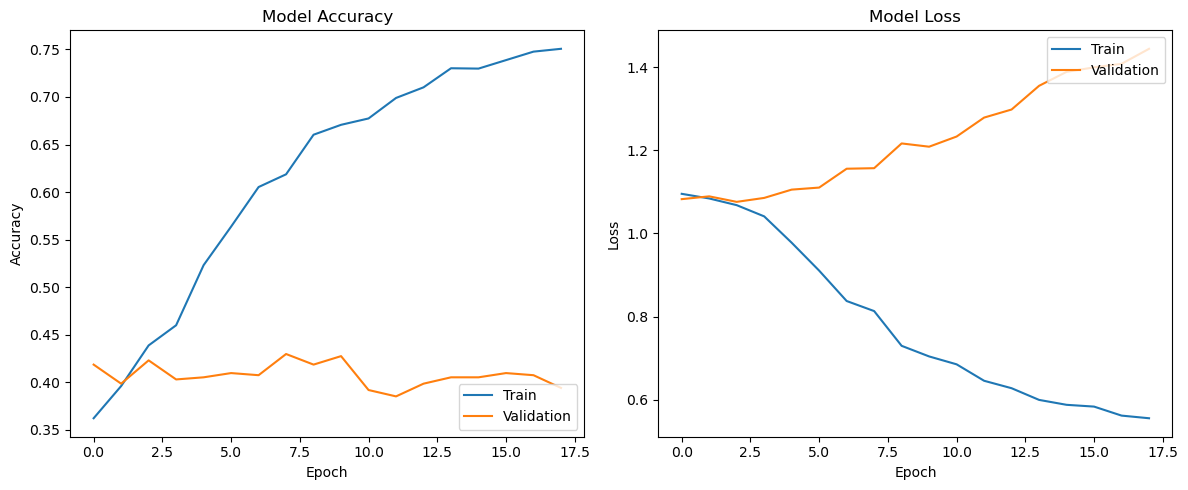


=== Model Evaluation ===
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

Test accuracy: 0.4251

Classification Report:
              precision    recall  f1-score   support

        High       0.22      0.21      0.21        81
         Low       0.48      0.61      0.54       190
      Medium       0.45      0.33      0.38       183

    accuracy                           0.43       454
   macro avg       0.38      0.38      0.38       454
weighted avg       0.42      0.43      0.42       454


Confusion Matrix:
[[ 17  36  28]
 [ 30 116  44]
 [ 32  91  60]]


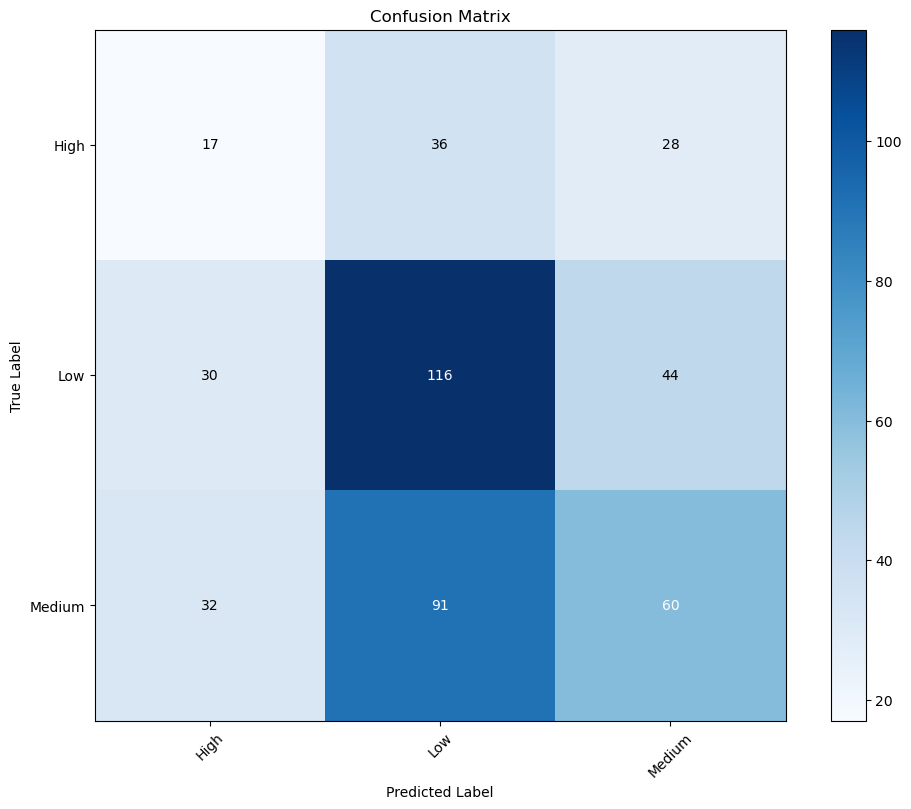


Model saved to 'final_lstm_clarity_model.h5'
Final test accuracy: 0.4251


In [42]:
# Complete Fixed Implementation for Clarity Assessment
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
import time
import librosa
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import os
from scipy.fftpack import dct

# Audio preprocessing functions
def load_audio(file_path, sr=16000):
    """Load an audio file at specified sample rate"""
    y, _ = librosa.load(file_path, sr=sr)
    return y

def normalize_audio(y):
    """Normalize audio amplitude"""
    if np.max(np.abs(y)) > 0:
        return y / np.max(np.abs(y))
    return y

def trim_silence(y, top_db=20):
    """Trim leading and trailing silence"""
    trimmed_y, _ = librosa.effects.trim(y, top_db=top_db)
    return trimmed_y

def standardize_length(y, sr, target_duration_sec, method='pad_clip'):
    """Standardize audio to a fixed duration"""
    target_length = int(sr * target_duration_sec)
    
    if method == 'pad_clip':
        if len(y) < target_length:
            return np.pad(y, (0, target_length - len(segment)))
        elif len(y) > target_length:
            return y[:target_length]
        else:
            return y
    else:
        raise ValueError(f"Unknown method: {method}")

def preprocess_audio(file_path, sr=16000, target_duration_sec=2.0):
    """Complete audio preprocessing pipeline"""
    # Load audio
    y = load_audio(file_path, sr=sr)
    
    # Trim silence
    y = trim_silence(y)
    
    # Normalize
    y = normalize_audio(y)
    
    # Standardize length
    y = standardize_length(y, sr, target_duration_sec)
    
    return y

# Fixed feature extraction class
class TimeSlicingFeatureExtractor:
    def __init__(self, 
                 sr=16000, 
                 time_window_ms=100,
                 n_mfcc=13,
                 lpc_order=14,
                 dct_length=13):
        """
        Initialize feature extractor for time-sliced audio
        """
        self.sr = sr
        self.time_window_ms = time_window_ms
        self.n_mfcc = n_mfcc
        self.lpc_order = lpc_order
        self.dct_length = dct_length
        
        # Calculate number of samples per window
        self.samples_per_window = int(sr * time_window_ms / 1000)
        
        # Calculate total feature dimension per window
        self.features_per_window = n_mfcc + lpc_order + dct_length
        
        print(f"Time-slicing configuration:")
        print(f"- Time window: {time_window_ms}ms")
        print(f"- Samples per window: {self.samples_per_window}")
        print(f"- Features per window: {self.features_per_window}")
    
    def extract_mfcc(self, segment):
        """Extract MFCC features from an audio segment"""
        # Ensure segment is long enough for MFCC extraction
        min_length = 512
        if len(segment) < min_length:
            segment = np.pad(segment, (0, min_length - len(segment)))
        
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(
            y=segment, 
            sr=self.sr, 
            n_mfcc=self.n_mfcc,
            n_fft=min(512, len(segment)),
            hop_length=min(128, len(segment)//4)
        )
        
        # Handle potential dimensionality issues
        if mfccs.shape[1] > 0:
            mfcc_features = np.mean(mfccs, axis=1)
        else:
            mfcc_features = np.zeros(self.n_mfcc)
            
        # Ensure exactly n_mfcc features
        if len(mfcc_features) > self.n_mfcc:
            return mfcc_features[:self.n_mfcc]
        elif len(mfcc_features) < self.n_mfcc:
            return np.pad(mfcc_features, (0, self.n_mfcc - len(mfcc_features)))
        return mfcc_features
    
    def extract_lpc(self, segment):
        """Extract Linear Prediction Coefficients from an audio segment"""
        # Ensure segment has sufficient length for LPC
        if len(segment) <= self.lpc_order:
            segment = np.pad(segment, (0, self.lpc_order + 1 - len(segment)))
        
        # Calculate LPC coefficients
        try:
            lpc = librosa.lpc(segment, order=self.lpc_order)
            lpc_features = lpc[1:]  # Skip the first coefficient
        except Exception:
            lpc_features = np.zeros(self.lpc_order)
            
        # Ensure exactly lpc_order features
        if len(lpc_features) > self.lpc_order:
            return lpc_features[:self.lpc_order]
        elif len(lpc_features) < self.lpc_order:
            return np.pad(lpc_features, (0, self.lpc_order - len(lpc_features)))
        return lpc_features
    
    def extract_dct(self, segment):
        """Extract DCT coefficients from power spectrum"""
        # Calculate power spectrum
        n_fft = min(512, len(segment))
        if len(segment) < n_fft:
            segment = np.pad(segment, (0, n_fft - len(segment)))
        
        try:
            # Get magnitude spectrogram
            S = np.abs(librosa.stft(segment, n_fft=n_fft))
            
            # Convert to power spectrogram
            power = S**2
            
            # Average over frames
            if power.shape[1] > 0:
                mean_power = np.mean(power, axis=1)
            else:
                mean_power = power.flatten()
            
            # Apply DCT
            dct_coef = dct(mean_power, type=2, norm='ortho')
            
            # Take the first dct_length coefficients
            dct_features = dct_coef[:self.dct_length]
        except Exception:
            dct_features = np.zeros(self.dct_length)
            
        # Ensure exactly dct_length features
        if len(dct_features) > self.dct_length:
            return dct_features[:self.dct_length]
        elif len(dct_features) < self.dct_length:
            return np.pad(dct_features, (0, self.dct_length - len(dct_features)))
        return dct_features
    
    def sort_mfcc_features(self, features_sequence):
        """Sort MFCCs by magnitude as recommended by mentor"""
        # Make a copy to avoid modifying the original
        sorted_features = features_sequence.copy()
        
        # For each time slice
        for i in range(sorted_features.shape[0]):
            # Extract MFCC coefficients (the first n_mfcc features)
            mfccs = sorted_features[i, :self.n_mfcc]
            
            # Sort by absolute magnitude (descending)
            sorted_indices = np.argsort(-np.abs(mfccs))
            sorted_mfcc_values = mfccs[sorted_indices]
            
            # Replace with sorted MFCCs
            sorted_features[i, :self.n_mfcc] = sorted_mfcc_values
        
        return sorted_features
    
    def extract_features_from_time_slices(self, audio, sort_mfccs=True):
        """Extract features from each time slice of the audio with fixed dimensions"""
        # Calculate number of time slices
        n_time_slices = len(audio) // self.samples_per_window
        
        # Initialize array to store features
        features_sequence = np.zeros((n_time_slices, self.features_per_window))
        
        # Process each time slice
        for i in range(n_time_slices):
            try:
                # Extract time slice
                start = i * self.samples_per_window
                end = start + self.samples_per_window
                segment = audio[start:end]
                
                # Extract features with guaranteed dimensions
                mfcc_features = self.extract_mfcc(segment)
                lpc_features = self.extract_lpc(segment)
                dct_features = self.extract_dct(segment)
                
                # Concatenate features
                all_features = np.concatenate([mfcc_features, lpc_features, dct_features])
                
                # Double-check dimensions
                if len(all_features) != self.features_per_window:
                    print(f"Warning: Feature length mismatch: {len(all_features)} != {self.features_per_window}")
                    # Fix the dimension
                    if len(all_features) > self.features_per_window:
                        all_features = all_features[:self.features_per_window]
                    else:
                        all_features = np.pad(all_features, (0, self.features_per_window - len(all_features)))
                
                # Store in sequence
                features_sequence[i] = all_features
            except Exception as e:
                print(f"Error processing time slice {i}: {str(e)}")
                # Keep zeros
        
        # Sort MFCC features if requested
        if sort_mfccs:
            features_sequence = self.sort_mfcc_features(features_sequence)
        
        return features_sequence

# Standardize features
def process_features(features_sequence, standardize=True):
    """Process extracted features (normalize, etc.)"""
    # Copy to avoid modifying the original
    features = features_sequence.copy()
    
    # Standardize features
    if standardize:
        scaler = StandardScaler()
        # Reshape to (n_samples, n_features) where n_samples = n_time_slices
        features = scaler.fit_transform(features)
    
    return features

# Prepare dataset for LSTM
def prepare_dataset(data_split_file, audio_dir, sr=16000, duration_sec=2.0, 
                   time_window_ms=100, standardize=True, sort_mfccs=True,
                   max_samples_per_class=None, verbose=True):
    """Prepare dataset with features for LSTM training"""
    # Check if data_split_file exists
    if not os.path.exists(data_split_file):
        raise FileNotFoundError(f"Data split file not found: {data_split_file}")
    
    # Check if audio_dir exists
    if not os.path.exists(audio_dir):
        raise FileNotFoundError(f"Audio directory not found: {audio_dir}")
    
    # Load data split
    df = pd.read_csv(data_split_file)
    print(f"Loaded {len(df)} entries from {data_split_file}")
    
    # Limit samples per class if specified (for testing)
    if max_samples_per_class is not None:
        samples_per_class = {}
        filtered_indices = []
        
        for i, row in df.iterrows():
            label = row['clarity_label']
            current_count = samples_per_class.get(label, 0)
            
            if current_count < max_samples_per_class:
                filtered_indices.append(i)
                samples_per_class[label] = current_count + 1
        
        df = df.iloc[filtered_indices].reset_index(drop=True)
        if verbose:
            print(f"Limited to {max_samples_per_class} samples per class.")
            print(f"Using {len(df)} samples in total.")
    
    # Initialize feature extractor
    feature_extractor = TimeSlicingFeatureExtractor(
        sr=sr,
        time_window_ms=time_window_ms,
        n_mfcc=13,
        lpc_order=14,
        dct_length=13
    )
    
    # Process each audio file
    X_sequences = []
    y = []
    
    # Track errors
    error_count = 0
    file_not_found_count = 0
    
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Preparing dataset"):
        try:
            # Find the audio file
            filename = row['filename']
            file_path = os.path.join(audio_dir, filename)
            
            # Search recursively if not found directly
            if not os.path.exists(file_path):
                found = False
                for root, _, files in os.walk(audio_dir):
                    for file in files:
                        if file == filename:
                            file_path = os.path.join(root, file)
                            found = True
                            break
                    if found:
                        break
                
                if not found:
                    file_not_found_count += 1
                    if verbose and file_not_found_count <= 5:
                        print(f"Warning: Could not find {filename}")
                    if file_not_found_count == 5:
                        print("Too many files not found. Suppressing further warnings.")
                    continue
            
            # Preprocess audio
            processed_audio = preprocess_audio(
                file_path, 
                sr=sr, 
                target_duration_sec=duration_sec
            )
            
            # Extract features with 100ms time slices
            features_sequence = feature_extractor.extract_features_from_time_slices(
                processed_audio, 
                sort_mfccs=sort_mfccs
            )
            
            # Process features (standardize)
            processed_features = process_features(
                features_sequence,
                standardize=standardize
            )
            
            # Add to dataset
            X_sequences.append(processed_features)
            y.append(row['clarity_label'])
            
        except Exception as e:
            error_count += 1
            if verbose and error_count <= 5:
                print(f"Error processing {row.get('filename', 'unknown')}: {str(e)}")
            if error_count == 5:
                print("Too many errors. Suppressing further error messages.")
    
    print(f"Successfully processed {len(X_sequences)} files")
    print(f"Files not found: {file_not_found_count}")
    print(f"Other errors: {error_count}")
    
    return X_sequences, np.array(y)

# Apply SMOTE to balance classes
def apply_smote(X_sequences, y_labels):
    """Apply SMOTE to balance classes for sequential data"""
    print("Applying SMOTE to balance classes...")
    
    # Ensure we're working with numpy arrays
    y_labels = np.array(y_labels)
    
    # Check if X_sequences is empty
    n_samples = len(X_sequences)
    if n_samples == 0:
        raise ValueError("Empty sequence list provided")
    
    # Find the maximum sequence length
    max_length = max(seq.shape[0] for seq in X_sequences)
    n_features = X_sequences[0].shape[1]
    
    print(f"Original data: {n_samples} sequences with {n_features} features")
    print(f"Original class distribution: {Counter(y_labels)}")
    
    # First pad all sequences to the same length
    X_padded = []
    for seq in X_sequences:
        if seq.shape[0] < max_length:
            # Pad with zeros
            padding = np.zeros((max_length - seq.shape[0], n_features))
            padded_seq = np.vstack([seq, padding])
        else:
            padded_seq = seq
        X_padded.append(padded_seq)
    
    # Convert to 3D numpy array
    X_array = np.array(X_padded)
    
    # Flatten for SMOTE (samples, timesteps*features)
    X_flat = X_array.reshape(n_samples, max_length * n_features)
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_flat_resampled, y_resampled = smote.fit_resample(X_flat, y_labels)
    
    # Reshape back to sequences
    n_resampled = X_flat_resampled.shape[0]
    X_resampled = X_flat_resampled.reshape(n_resampled, max_length, n_features)
    
    print(f"Resampled data: {len(X_resampled)} sequences")
    print(f"Resampled class distribution: {Counter(y_resampled)}")
    
    return X_resampled, y_resampled

# Prepare data for model
def prepare_model_data(train_split, val_split, test_split, audio_dir, max_samples=None):
    """Prepare data for LSTM model from all splits"""
    print("Preparing training dataset...")
    X_train, y_train = prepare_dataset(
        train_split, audio_dir, 
        sort_mfccs=True,
        max_samples_per_class=max_samples
    )
    
    print("Preparing validation dataset...")
    X_val, y_val = prepare_dataset(
        val_split, audio_dir,
        sort_mfccs=True,
        max_samples_per_class=max_samples
    )
    
    print("Preparing test dataset...")
    X_test, y_test = prepare_dataset(
        test_split, audio_dir,
        sort_mfccs=True,
        max_samples_per_class=max_samples
    )
    
    # Apply SMOTE only to training data
    X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)
    
    # Find the maximum sequence length
    max_length = max(
        max(len(seq) for seq in X_train_resampled),
        max(len(seq) for seq in X_val),
        max(len(seq) for seq in X_test)
    )
    
    # Pad all sequences to the same length
    def pad_sequences(sequences, max_length):
        padded = []
        for seq in sequences:
            if len(seq) < max_length:
                # Get feature dimension
                n_feat = seq.shape[1]
                # Pad with zeros
                padding = np.zeros((max_length - len(seq), n_feat))
                padded_seq = np.vstack([seq, padding])
            else:
                padded_seq = seq[:max_length]  # Truncate if longer
            padded.append(padded_seq)
        return np.array(padded)
    
    X_train_padded = pad_sequences(X_train_resampled, max_length)
    X_val_padded = pad_sequences(X_val, max_length)
    X_test_padded = pad_sequences(X_test, max_length)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_resampled)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Convert to categorical
    y_train_categorical = to_categorical(y_train_encoded)
    y_val_categorical = to_categorical(y_val_encoded)
    y_test_categorical = to_categorical(y_test_encoded)
    
    return (X_train_padded, y_train_categorical, 
            X_val_padded, y_val_categorical,
            X_test_padded, y_test_categorical,
            label_encoder)

# Simple LSTM model
def build_simple_lstm_model(input_shape, num_classes):
    """Build a simpler LSTM model - SIMPLIFIED ARCHITECTURE"""
    model = Sequential([
        # Input layer
        Input(shape=input_shape),
        
        # Bidirectional LSTM with fewer units
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.5),
        
        # Global pooling (to fix the sequential length)
        tf.keras.layers.GlobalAveragePooling1D(),
        
        # Fewer dense layers
        Dense(32, activation='relu'),
        Dropout(0.5),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile with a lower learning rate
    optimizer = Adam(learning_rate=0.0005)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    model.summary()
    
    return model

# Train model
def train_model(X_train, y_train, X_val, y_val):
    """Train a simple LSTM model with better regularization"""
    # Build model
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = y_train.shape[1]
    model = build_simple_lstm_model(input_shape, num_classes)
    
    # Class weights (already balanced by SMOTE, but adding small weights)
    y_integers = np.argmax(y_train, axis=1)
    class_counts = np.bincount(y_integers)
    total_samples = np.sum(class_counts)
    class_weights = {i: (total_samples / (len(class_counts) * count)) ** 0.5
                    for i, count in enumerate(class_counts)}
    
    # Callbacks
    callbacks = [
        # Early stopping
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        # Learning rate reduction
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        # Save best model
        ModelCheckpoint(
            'best_lstm_clarity_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Train model
    print("\nTraining simplified LSTM model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,  # Fewer epochs
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # Load best model
    model.load_weights('best_lstm_clarity_model.h5')
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return model, history

# Evaluate model
def evaluate_model(model, X_test, y_test, label_encoder):
    """Evaluate the LSTM model"""
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred_encoded = np.argmax(y_pred_proba, axis=1)
    y_test_encoded = np.argmax(y_test, axis=1)
    
    # Convert back to original labels
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    y_true = label_encoder.inverse_transform(y_test_encoded)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nTest accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Add labels
    classes = label_encoder.classes_
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy

# Main function
def run_clarity_classification():
    """Main function to run the entire pipeline"""
    # Set paths
    train_split = "data_splits/train.csv"
    val_split = "data_splits/validation.csv"
    test_split = "data_splits/test.csv"
    audio_dir = "./extracted_audio_data/Audios and excels/Cleaned_Audios"
    
    # For full dataset, use max_samples=None
    max_samples = None
    
    # Prepare data
    print("=== Data Preparation ===")
    (X_train, y_train, 
     X_val, y_val, 
     X_test, y_test, 
     label_encoder) = prepare_model_data(
        train_split, val_split, test_split, audio_dir, 
        max_samples=max_samples
    )
    
    # Train model
    print("\n=== Model Training ===")
    model, history = train_model(X_train, y_train, X_val, y_val)
    
    # Evaluate model
    print("\n=== Model Evaluation ===")
    test_accuracy = evaluate_model(model, X_test, y_test, label_encoder)
    
    # Save model
    model.save('final_lstm_clarity_model.h5')
    print("\nModel saved to 'final_lstm_clarity_model.h5'")
    
    return model, test_accuracy

# Run the pipeline
if __name__ == "__main__":
    model, accuracy = run_clarity_classification()
    print(f"Final test accuracy: {accuracy:.4f}")

In [43]:
print("GRU IMPLEMENTATION")


GRU IMPLEMENTATION


=== Data Preparation ===
Preparing training dataset...
Loaded 2685 entries from data_splits/train.csv
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   0%|                       | 7/2685 [00:00<02:06, 21.25it/s]

Error processing 102_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   2%|▎                     | 43/2685 [00:02<02:01, 21.80it/s]

Error processing 107_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   3%|▊                     | 92/2685 [00:04<01:42, 25.33it/s]

Error processing 108_s43.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   8%|█▋                   | 213/2685 [00:09<01:40, 24.54it/s]

Error processing 108_s31.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  11%|██▎                  | 289/2685 [00:12<01:33, 25.49it/s]

Error processing 108_s50.mp3: 
Too many errors. Suppressing further error messages.


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Ca

Successfully processed 2610 files
Files not found: 0
Other errors: 75
Preparing validation dataset...
Loaded 576 entries from data_splits/validation.csv
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  16%|███▋                   | 91/576 [00:03<00:21, 23.07it/s]

Error processing 108_s30.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  32%|███████               | 184/576 [00:08<00:19, 19.97it/s]

Error processing 106_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  40%|████████▊             | 230/576 [00:10<00:17, 20.16it/s]

Error processing 102_s18.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error processing 102_s10.mp3: 
Error processing 107_s29.mp3: 
Too many errors. Suppressing further error messages.


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset: 100%|██████████████████████| 576/576 [00:26<00:00, 21.78it/s]


Successfully processed 567 files
Files not found: 0
Other errors: 9
Preparing test dataset...
Loaded 576 entries from data_splits/test.csv
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   6%|█▎                     | 33/576 [00:01<00:20, 27.05it/s]

Error processing 107_s20.mp3: 
Error processing 108_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  16%|███▊                   | 94/576 [00:03<00:18, 25.47it/s]

Error processing 108_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  35%|███████▋              | 200/576 [00:08<00:14, 26.06it/s]

Error processing 108_s37.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  39%|████████▌             | 225/576 [00:09<00:13, 25.80it/s]

Error processing 108_s20.mp3: 
Too many errors. Suppressing further error messages.


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset: 100%|██████████████████████| 576/576

Successfully processed 562 files
Files not found: 0
Other errors: 14
Applying SMOTE to balance classes...
Original data: 2610 sequences with 40 features
Original class distribution: Counter({np.str_('Low'): 1213, np.str_('Medium'): 977, np.str_('High'): 420})
Resampled data: 3639 sequences
Resampled class distribution: Counter({np.str_('Low'): 1213, np.str_('Medium'): 1213, np.str_('High'): 1213})

=== GRU Model Training ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 20, 96)         │        39,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 48)             │        21,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,843 (249.39 KB)

 Trainable params: 63,555 (248.26 KB)

 Non-trainable params: 288 (1.12 KB)


Training GRU model...
Epoch 1/70
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3430 - loss: 1.4544
Epoch 1: val_accuracy improved from -inf to 0.37213, saving model to best_gru_clarity_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.3429 - loss: 1.4540 - val_accuracy: 0.3721 - val_loss: 1.1525 - learning_rate: 3.0000e-04
Epoch 2/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3445 - loss: 1.3256
Epoch 2: val_accuracy did not improve from 0.37213
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.3445 - loss: 1.3256 - val_accuracy: 0.3545 - val_loss: 1.1542 - learning_rate: 3.0000e-04
Epoch 3/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3580 - loss: 1.2756
Epoch 3: val_accuracy did not improve from 0.37213
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.3579 - loss: 1.2756 - val_accuracy: 0.3721 - val_loss: 1.1598 - learning_rate: 3.0000e-04
Epoch 4/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3417 - loss: 1.2743
Epoch 4: val_accuracy improved from 0.37213 to 0.37566, saving model to best_gru_clarity_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.3418 - loss: 1.2742 - val_accuracy: 0.3757 - val_loss: 1.1444 - learning_rate: 3.0000e-04
Epoch 5/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3674 - loss: 1.2320
Epoch 5: val_accuracy improved from 0.37566 to 0.39859, saving model to best_gru_clarity_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.3675 - loss: 1.2319 - val_accuracy: 0.3986 - val_loss: 1.1363 - learning_rate: 3.0000e-04
Epoch 6/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3702 - loss: 1.2064
Epoch 6: val_accuracy improved from 0.39859 to 0.40741, saving model to best_gru_clarity_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.3701 - loss: 1.2063 - val_accuracy: 0.4074 - val_loss: 1.1288 - learning_rate: 3.0000e-04
Epoch 7/70
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3691 - loss: 1.1805
Epoch 7: val_accuracy improved from 0.40741 to 0.41093, saving model to best_gru_clarity_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.3691 - loss: 1.1805 - val_accuracy: 0.4109 - val_loss: 1.1252 - learning_rate: 3.0000e-04
Epoch 8/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3751 - loss: 1.1701
Epoch 8: val_accuracy improved from 0.41093 to 0.41270, saving model to best_gru_clarity_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3752 - loss: 1.1699 - val_accuracy: 0.4127 - val_loss: 1.1267 - learning_rate: 3.0000e-04
Epoch 9/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3712 - loss: 1.1723
Epoch 9: val_accuracy improved from 0.41270 to 0.41623, saving model to best_gru_clarity_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.3712 - loss: 1.1722 - val_accuracy: 0.4162 - val_loss: 1.1252 - learning_rate: 3.0000e-04
Epoch 10/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3802 - loss: 1.1512
Epoch 10: val_accuracy improved from 0.41623 to 0.42328, saving model to best_gru_clarity_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3801 - loss: 1.1512 - val_accuracy: 0.4233 - val_loss: 1.1269 - learning_rate: 3.0000e-04
Epoch 11/70
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3920 - loss: 1.1596
Epoch 11: val_accuracy improved from 0.42328 to 0.42504, saving model to best_gru_clarity_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3921 - loss: 1.1595 - val_accuracy: 0.4250 - val_loss: 1.1214 - learning_rate: 3.0000e-04
Epoch 12/70
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3854 - loss: 1.1448
Epoch 12: val_accuracy improved from 0.42504 to 0.42857, saving model to best_gru_clarity_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3856 - loss: 1.1446 - val_accuracy: 0.4286 - val_loss: 1.1273 - learning_rate: 3.0000e-04
Epoch 13/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3915 - loss: 1.1360
Epoch 13: val_accuracy improved from 0.42857 to 0.43563, saving model to best_gru_clarity_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3915 - loss: 1.1359 - val_accuracy: 0.4356 - val_loss: 1.1244 - learning_rate: 3.0000e-04
Epoch 14/70
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4079 - loss: 1.1309
Epoch 14: val_accuracy did not improve from 0.43563
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4079 - loss: 1.1309 - val_accuracy: 0.4145 - val_loss: 1.1188 - learning_rate: 3.0000e-04
Epoch 15/70
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4073 - loss: 1.1269
Epoch 15: val_accuracy did not improve from 0.43563
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4072 - loss: 1.1270 - val_accuracy: 0.4109 - val_loss: 1.1184 - learning_rate: 3.0000e-04
Epoch 16/70
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3952 - loss: 1.1243
Epoch 16: val_accuracy did not improve from 0.43563
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.3953 - loss: 1.1243 - val_accuracy: 0.4162 - val_loss: 1.1184 - learning_rate: 3.0000e

114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4381 - loss: 1.0805 - val_accuracy: 0.4550 - val_loss: 1.1092 - learning_rate: 3.0000e-04
Epoch 25/70
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4521 - loss: 1.0806
Epoch 25: val_accuracy did not improve from 0.45503
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4521 - loss: 1.0806 - val_accuracy: 0.4427 - val_loss: 1.1158 - learning_rate: 3.0000e-04
Epoch 26/70
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4364 - loss: 1.0784
Epoch 26: val_accuracy did not improve from 0.45503
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4365 - loss: 1.0784 - val_accuracy: 0.4480 - val_loss: 1.1064 - learning_rate: 3.0000e-04
Epoch 27/70
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4605 - loss: 1.0640
Epoch 27: val_accuracy did not improve from 0.45503
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4604 - loss: 1.0641 - val_accuracy: 0.4374 - val_loss: 1.1125 - learning_rate: 3.0000e

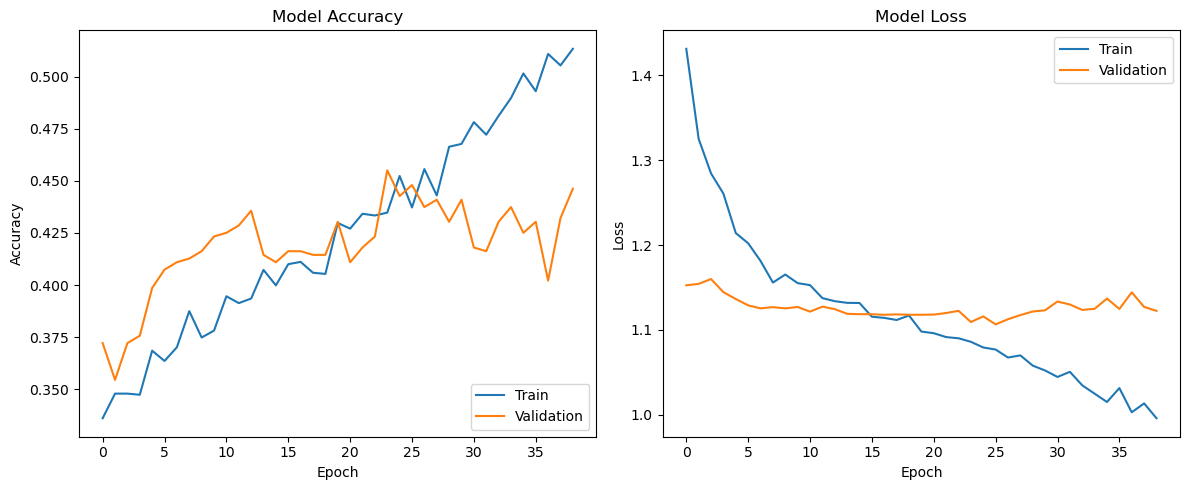


=== GRU Model Evaluation ===
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step 

Test accuracy: 0.4377

Classification Report:
              precision    recall  f1-score   support

        High       0.22      0.41      0.28        90
         Low       0.58      0.54      0.56       263
      Medium       0.46      0.33      0.38       209

    accuracy                           0.44       562
   macro avg       0.42      0.42      0.41       562
weighted avg       0.48      0.44      0.45       562


Confusion Matrix:
[[ 37  30  23]
 [ 64 141  58]
 [ 70  71  68]]


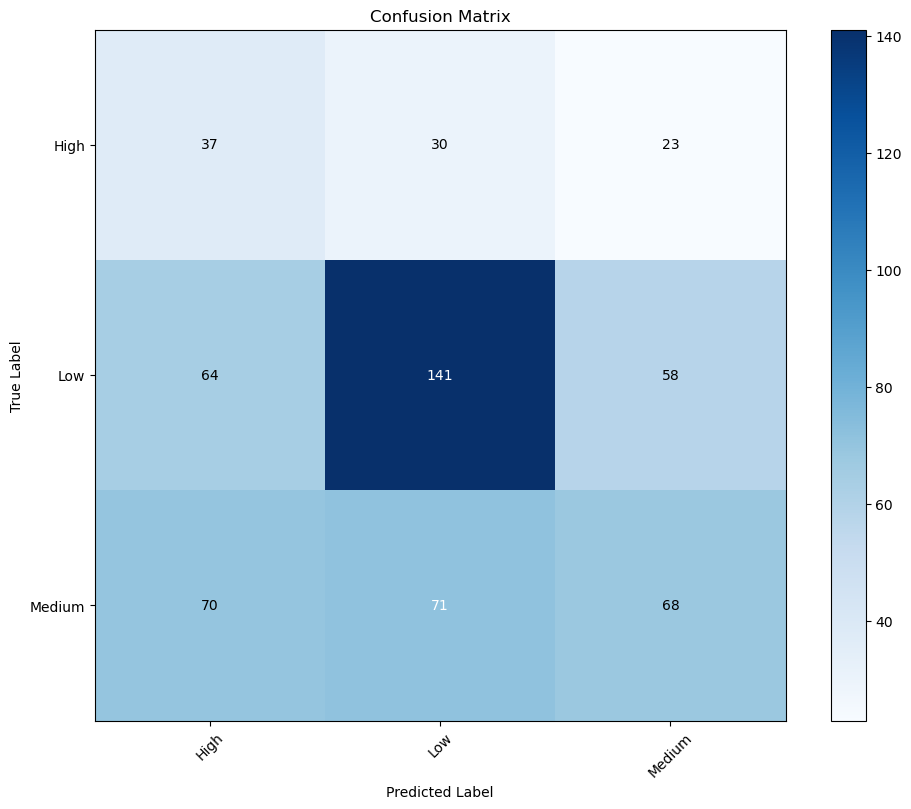


Model saved to 'final_gru_clarity_model.h5'
Final GRU test accuracy: 0.4377


In [44]:
# Complete GRU Implementation for Clarity Assessment
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
import time
import librosa
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import os
from scipy.fftpack import dct

# Audio preprocessing functions
def load_audio(file_path, sr=16000):
    """Load an audio file at specified sample rate"""
    y, _ = librosa.load(file_path, sr=sr)
    return y

def normalize_audio(y):
    """Normalize audio amplitude"""
    if np.max(np.abs(y)) > 0:
        return y / np.max(np.abs(y))
    return y

def trim_silence(y, top_db=20):
    """Trim leading and trailing silence"""
    trimmed_y, _ = librosa.effects.trim(y, top_db=top_db)
    return trimmed_y

def standardize_length(y, sr, target_duration_sec, method='pad_clip'):
    """Standardize audio to a fixed duration"""
    target_length = int(sr * target_duration_sec)
    
    if method == 'pad_clip':
        if len(y) < target_length:
            return np.pad(y, (0, target_length - len(y)))
        elif len(y) > target_length:
            return y[:target_length]
        else:
            return y
    else:
        raise ValueError(f"Unknown method: {method}")

def preprocess_audio(file_path, sr=16000, target_duration_sec=2.0):
    """Complete audio preprocessing pipeline"""
    # Load audio
    y = load_audio(file_path, sr=sr)
    
    # Trim silence
    y = trim_silence(y)
    
    # Normalize
    y = normalize_audio(y)
    
    # Standardize length
    y = standardize_length(y, sr, target_duration_sec)
    
    return y

# Fixed feature extraction class
class TimeSlicingFeatureExtractor:
    def __init__(self, 
                 sr=16000, 
                 time_window_ms=100,
                 n_mfcc=13,
                 lpc_order=14,
                 dct_length=13):
        """
        Initialize feature extractor for time-sliced audio
        """
        self.sr = sr
        self.time_window_ms = time_window_ms
        self.n_mfcc = n_mfcc
        self.lpc_order = lpc_order
        self.dct_length = dct_length
        
        # Calculate number of samples per window
        self.samples_per_window = int(sr * time_window_ms / 1000)
        
        # Calculate total feature dimension per window
        self.features_per_window = n_mfcc + lpc_order + dct_length
        
        print(f"Time-slicing configuration:")
        print(f"- Time window: {time_window_ms}ms")
        print(f"- Samples per window: {self.samples_per_window}")
        print(f"- Features per window: {self.features_per_window}")
    
    def extract_mfcc(self, segment):
        """Extract MFCC features from an audio segment"""
        # Ensure segment is long enough for MFCC extraction
        min_length = 512
        if len(segment) < min_length:
            segment = np.pad(segment, (0, min_length - len(segment)))
        
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(
            y=segment, 
            sr=self.sr, 
            n_mfcc=self.n_mfcc,
            n_fft=min(512, len(segment)),
            hop_length=min(128, len(segment)//4)
        )
        
        # Handle potential dimensionality issues
        if mfccs.shape[1] > 0:
            mfcc_features = np.mean(mfccs, axis=1)
        else:
            mfcc_features = np.zeros(self.n_mfcc)
            
        # Ensure exactly n_mfcc features
        if len(mfcc_features) > self.n_mfcc:
            return mfcc_features[:self.n_mfcc]
        elif len(mfcc_features) < self.n_mfcc:
            return np.pad(mfcc_features, (0, self.n_mfcc - len(mfcc_features)))
        return mfcc_features
    
    def extract_lpc(self, segment):
        """Extract Linear Prediction Coefficients from an audio segment"""
        # Ensure segment has sufficient length for LPC
        if len(segment) <= self.lpc_order:
            segment = np.pad(segment, (0, self.lpc_order + 1 - len(segment)))
        
        # Calculate LPC coefficients
        try:
            lpc = librosa.lpc(segment, order=self.lpc_order)
            lpc_features = lpc[1:]  # Skip the first coefficient
        except Exception:
            lpc_features = np.zeros(self.lpc_order)
            
        # Ensure exactly lpc_order features
        if len(lpc_features) > self.lpc_order:
            return lpc_features[:self.lpc_order]
        elif len(lpc_features) < self.lpc_order:
            return np.pad(lpc_features, (0, self.lpc_order - len(lpc_features)))
        return lpc_features
    
    def extract_dct(self, segment):
        """Extract DCT coefficients from power spectrum"""
        # Calculate power spectrum
        n_fft = min(512, len(segment))
        if len(segment) < n_fft:
            segment = np.pad(segment, (0, n_fft - len(segment)))
        
        try:
            # Get magnitude spectrogram
            S = np.abs(librosa.stft(segment, n_fft=n_fft))
            
            # Convert to power spectrogram
            power = S**2
            
            # Average over frames
            if power.shape[1] > 0:
                mean_power = np.mean(power, axis=1)
            else:
                mean_power = power.flatten()
            
            # Apply DCT
            dct_coef = dct(mean_power, type=2, norm='ortho')
            
            # Take the first dct_length coefficients
            dct_features = dct_coef[:self.dct_length]
        except Exception:
            dct_features = np.zeros(self.dct_length)
            
        # Ensure exactly dct_length features
        if len(dct_features) > self.dct_length:
            return dct_features[:self.dct_length]
        elif len(dct_features) < self.dct_length:
            return np.pad(dct_features, (0, self.dct_length - len(dct_features)))
        return dct_features
    
    def sort_mfcc_features(self, features_sequence):
        """Sort MFCCs by magnitude as recommended by mentor"""
        # Make a copy to avoid modifying the original
        sorted_features = features_sequence.copy()
        
        # For each time slice
        for i in range(sorted_features.shape[0]):
            # Extract MFCC coefficients (the first n_mfcc features)
            mfccs = sorted_features[i, :self.n_mfcc]
            
            # Sort by absolute magnitude (descending)
            sorted_indices = np.argsort(-np.abs(mfccs))
            sorted_mfcc_values = mfccs[sorted_indices]
            
            # Replace with sorted MFCCs
            sorted_features[i, :self.n_mfcc] = sorted_mfcc_values
        
        return sorted_features
    
    def extract_features_from_time_slices(self, audio, sort_mfccs=True):
        """Extract features from each time slice of the audio with fixed dimensions"""
        # Calculate number of time slices
        n_time_slices = len(audio) // self.samples_per_window
        
        # Initialize array to store features
        features_sequence = np.zeros((n_time_slices, self.features_per_window))
        
        # Process each time slice
        for i in range(n_time_slices):
            try:
                # Extract time slice
                start = i * self.samples_per_window
                end = start + self.samples_per_window
                segment = audio[start:end]
                
                # Extract features with guaranteed dimensions
                mfcc_features = self.extract_mfcc(segment)
                lpc_features = self.extract_lpc(segment)
                dct_features = self.extract_dct(segment)
                
                # Concatenate features
                all_features = np.concatenate([mfcc_features, lpc_features, dct_features])
                
                # Double-check dimensions
                if len(all_features) != self.features_per_window:
                    print(f"Warning: Feature length mismatch: {len(all_features)} != {self.features_per_window}")
                    # Fix the dimension
                    if len(all_features) > self.features_per_window:
                        all_features = all_features[:self.features_per_window]
                    else:
                        all_features = np.pad(all_features, (0, self.features_per_window - len(all_features)))
                
                # Store in sequence
                features_sequence[i] = all_features
            except Exception as e:
                print(f"Error processing time slice {i}: {str(e)}")
                # Keep zeros
        
        # Sort MFCC features if requested
        if sort_mfccs:
            features_sequence = self.sort_mfcc_features(features_sequence)
        
        return features_sequence

# Standardize features
def process_features(features_sequence, standardize=True):
    """Process extracted features (normalize, etc.)"""
    # Copy to avoid modifying the original
    features = features_sequence.copy()
    
    # Standardize features
    if standardize:
        scaler = StandardScaler()
        # Reshape to (n_samples, n_features) where n_samples = n_time_slices
        features = scaler.fit_transform(features)
    
    return features

# Prepare dataset for GRU
def prepare_dataset(data_split_file, audio_dir, sr=16000, duration_sec=2.0, 
                   time_window_ms=100, standardize=True, sort_mfccs=True,
                   max_samples_per_class=None, verbose=True):
    """Prepare dataset with features for GRU training"""
    # Check if data_split_file exists
    if not os.path.exists(data_split_file):
        raise FileNotFoundError(f"Data split file not found: {data_split_file}")
    
    # Check if audio_dir exists
    if not os.path.exists(audio_dir):
        raise FileNotFoundError(f"Audio directory not found: {audio_dir}")
    
    # Load data split
    df = pd.read_csv(data_split_file)
    print(f"Loaded {len(df)} entries from {data_split_file}")
    
    # Limit samples per class if specified (for testing)
    if max_samples_per_class is not None:
        samples_per_class = {}
        filtered_indices = []
        
        for i, row in df.iterrows():
            label = row['clarity_label']
            current_count = samples_per_class.get(label, 0)
            
            if current_count < max_samples_per_class:
                filtered_indices.append(i)
                samples_per_class[label] = current_count + 1
        
        df = df.iloc[filtered_indices].reset_index(drop=True)
        if verbose:
            print(f"Limited to {max_samples_per_class} samples per class.")
            print(f"Using {len(df)} samples in total.")
    
    # Initialize feature extractor
    feature_extractor = TimeSlicingFeatureExtractor(
        sr=sr,
        time_window_ms=time_window_ms,
        n_mfcc=13,
        lpc_order=14,
        dct_length=13
    )
    
    # Process each audio file
    X_sequences = []
    y = []
    
    # Track errors
    error_count = 0
    file_not_found_count = 0
    
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Preparing dataset"):
        try:
            # Find the audio file
            filename = row['filename']
            file_path = os.path.join(audio_dir, filename)
            
            # Search recursively if not found directly
            if not os.path.exists(file_path):
                found = False
                for root, _, files in os.walk(audio_dir):
                    for file in files:
                        if file == filename:
                            file_path = os.path.join(root, file)
                            found = True
                            break
                    if found:
                        break
                
                if not found:
                    file_not_found_count += 1
                    if verbose and file_not_found_count <= 5:
                        print(f"Warning: Could not find {filename}")
                    if file_not_found_count == 5:
                        print("Too many files not found. Suppressing further warnings.")
                    continue
            
            # Preprocess audio
            processed_audio = preprocess_audio(
                file_path, 
                sr=sr, 
                target_duration_sec=duration_sec
            )
            
            # Extract features with 100ms time slices
            features_sequence = feature_extractor.extract_features_from_time_slices(
                processed_audio, 
                sort_mfccs=sort_mfccs
            )
            
            # Process features (standardize)
            processed_features = process_features(
                features_sequence,
                standardize=standardize
            )
            
            # Add to dataset
            X_sequences.append(processed_features)
            y.append(row['clarity_label'])
            
        except Exception as e:
            error_count += 1
            if verbose and error_count <= 5:
                print(f"Error processing {row.get('filename', 'unknown')}: {str(e)}")
            if error_count == 5:
                print("Too many errors. Suppressing further error messages.")
    
    print(f"Successfully processed {len(X_sequences)} files")
    print(f"Files not found: {file_not_found_count}")
    print(f"Other errors: {error_count}")
    
    return X_sequences, np.array(y)

# Apply SMOTE to balance classes
def apply_smote(X_sequences, y_labels):
    """Apply SMOTE to balance classes for sequential data"""
    print("Applying SMOTE to balance classes...")
    
    # Ensure we're working with numpy arrays
    y_labels = np.array(y_labels)
    
    # Check if X_sequences is empty
    n_samples = len(X_sequences)
    if n_samples == 0:
        raise ValueError("Empty sequence list provided")
    
    # Find the maximum sequence length
    max_length = max(seq.shape[0] for seq in X_sequences)
    n_features = X_sequences[0].shape[1]
    
    print(f"Original data: {n_samples} sequences with {n_features} features")
    print(f"Original class distribution: {Counter(y_labels)}")
    
    # First pad all sequences to the same length
    X_padded = []
    for seq in X_sequences:
        if seq.shape[0] < max_length:
            # Pad with zeros
            padding = np.zeros((max_length - seq.shape[0], n_features))
            padded_seq = np.vstack([seq, padding])
        else:
            padded_seq = seq
        X_padded.append(padded_seq)
    
    # Convert to 3D numpy array
    X_array = np.array(X_padded)
    
    # Flatten for SMOTE (samples, timesteps*features)
    X_flat = X_array.reshape(n_samples, max_length * n_features)
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_flat_resampled, y_resampled = smote.fit_resample(X_flat, y_labels)
    
    # Reshape back to sequences
    n_resampled = X_flat_resampled.shape[0]
    X_resampled = X_flat_resampled.reshape(n_resampled, max_length, n_features)
    
    print(f"Resampled data: {len(X_resampled)} sequences")
    print(f"Resampled class distribution: {Counter(y_resampled)}")
    
    return X_resampled, y_resampled

# Prepare data for model
def prepare_model_data(train_split, val_split, test_split, audio_dir, max_samples=None):
    """Prepare data for GRU model from all splits"""
    print("Preparing training dataset...")
    X_train, y_train = prepare_dataset(
        train_split, audio_dir, 
        sort_mfccs=True,
        max_samples_per_class=max_samples
    )
    
    print("Preparing validation dataset...")
    X_val, y_val = prepare_dataset(
        val_split, audio_dir,
        sort_mfccs=True,
        max_samples_per_class=max_samples
    )
    
    print("Preparing test dataset...")
    X_test, y_test = prepare_dataset(
        test_split, audio_dir,
        sort_mfccs=True,
        max_samples_per_class=max_samples
    )
    
    # Apply SMOTE only to training data
    X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)
    
    # Find the maximum sequence length
    max_length = max(
        max(len(seq) for seq in X_train_resampled),
        max(len(seq) for seq in X_val),
        max(len(seq) for seq in X_test)
    )
    
    # Pad all sequences to the same length
    def pad_sequences(sequences, max_length):
        padded = []
        for seq in sequences:
            if len(seq) < max_length:
                # Get feature dimension
                n_feat = seq.shape[1]
                # Pad with zeros
                padding = np.zeros((max_length - len(seq), n_feat))
                padded_seq = np.vstack([seq, padding])
            else:
                padded_seq = seq[:max_length]  # Truncate if longer
            padded.append(padded_seq)
        return np.array(padded)
    
    X_train_padded = pad_sequences(X_train_resampled, max_length)
    X_val_padded = pad_sequences(X_val, max_length)
    X_test_padded = pad_sequences(X_test, max_length)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_resampled)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Convert to categorical
    y_train_categorical = to_categorical(y_train_encoded)
    y_val_categorical = to_categorical(y_val_encoded)
    y_test_categorical = to_categorical(y_test_encoded)
    
    return (X_train_padded, y_train_categorical, 
            X_val_padded, y_val_categorical,
            X_test_padded, y_test_categorical,
            label_encoder)

# GRU model
def build_gru_model(input_shape, num_classes):
    """
    Build a GRU-based model for clarity assessment
    
    Args:
        input_shape: Shape of input data (time_slices, features)
        num_classes: Number of output classes
        
    Returns:
        Compiled model
    """
    model = Sequential([
        # Input layer
        Input(shape=input_shape),
        
        # First GRU layer with more units
        GRU(96, return_sequences=True, 
            dropout=0.3, recurrent_dropout=0.3),
        tf.keras.layers.BatchNormalization(),
        
        # Second GRU layer
        GRU(48, return_sequences=False,
            dropout=0.3, recurrent_dropout=0.3),
        tf.keras.layers.BatchNormalization(),
        
        # Dense layers
        Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.4),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile with a lower learning rate
    optimizer = Adam(learning_rate=0.0003)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    model.summary()
    
    return model

# Train GRU model
def train_gru_model(X_train, y_train, X_val, y_val):
    """Train a GRU model with better regularization"""
    # Build model
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = y_train.shape[1]
    model = build_gru_model(input_shape, num_classes)
    
    # Class weights (already balanced by SMOTE, but adding small weights)
    y_integers = np.argmax(y_train, axis=1)
    class_counts = np.bincount(y_integers)
    total_samples = np.sum(class_counts)
    class_weights = {i: (total_samples / (len(class_counts) * count)) ** 0.5
                    for i, count in enumerate(class_counts)}
    
    # Callbacks
    callbacks = [
        # Early stopping
        EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        # Learning rate reduction
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        # Save best model
        ModelCheckpoint(
            'best_gru_clarity_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Train model
    print("\nTraining GRU model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=70,  # More epochs with early stopping
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # Load best model
    model.load_weights('best_gru_clarity_model.h5')
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return model, history

# Evaluate GRU model
def evaluate_model(model, X_test, y_test, label_encoder):
    """Evaluate the GRU model"""
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred_encoded = np.argmax(y_pred_proba, axis=1)
    y_test_encoded = np.argmax(y_test, axis=1)
    
    # Convert back to original labels
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    y_true = label_encoder.inverse_transform(y_test_encoded)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nTest accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Add labels
    classes = label_encoder.classes_
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy

# Main function for GRU
def run_gru_clarity_classification():
    """Main function to run the GRU pipeline"""
    # Set paths
    train_split = "data_splits/train.csv"
    val_split = "data_splits/validation.csv"
    test_split = "data_splits/test.csv"
    audio_dir = "./extracted_audio_data/Audios and excels/Cleaned_Audios"
    
    # For full dataset, use max_samples=None
    max_samples = None
    
    # Prepare data
    print("=== Data Preparation ===")
    (X_train, y_train, 
     X_val, y_val, 
     X_test, y_test, 
     label_encoder) = prepare_model_data(
        train_split, val_split, test_split, audio_dir, 
        max_samples=max_samples
    )
    
    # Train model
    print("\n=== GRU Model Training ===")
    model, history = train_gru_model(X_train, y_train, X_val, y_val)
    
    # Evaluate model
    print("\n=== GRU Model Evaluation ===")
    test_accuracy = evaluate_model(model, X_test, y_test, label_encoder)
    
    # Save model
    model.save('final_gru_clarity_model.h5')
    print("\nModel saved to 'final_gru_clarity_model.h5'")
    
    return model, test_accuracy

# Run the GRU pipeline
if __name__ == "__main__":
    model_gru, accuracy_gru = run_gru_clarity_classification()
    print(f"Final GRU test accuracy: {accuracy_gru:.4f}")

Loading test and validation data...
Loaded 100 entries from temp_val.csv
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s28.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  36%|████████▎              | 36/100 [00:03<00:03, 18.77it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s18.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  81%|██████████████████▋    | 81/100 [00:05<00:00, 20.68it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s29.mp3: 


Preparing dataset: 100%|██████████████████████| 100/100 [00:06<00:00, 15.79it/s]


Successfully processed 100 files
Loaded 576 entries from data_splits/test.csv
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   5%|█▏                     | 31/576 [00:01<00:23, 23.03it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s20.mp3: 
Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  16%|███▊                   | 94/576 [00:04<00:19, 24.12it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  35%|███████▌              | 199/576 [00:08<00:16, 23.54it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s37.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  39%|████████▌             | 223/576 [00:09<00:14, 24.06it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  53%|███████████▋          | 307/576 [00:13<00:11, 24.08it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s48.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  55%|████████████          | 316/576 [00:14<00:12, 21.04it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s28.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  61%|█████████████▍        | 352/576 [00:16<00:09, 23.29it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  79%|█████████████████▎    | 454/576 [00:20<00:05, 23.03it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  81%|█████████████████▉    | 469/576 [00:21<00:04, 22.43it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  83%|██████████████████▎   | 478/576 [00:21<00:04, 22.81it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s22.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  85%|██████████████████▋   | 490/576 [00:22<00:03, 22.47it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/105_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  87%|███████████████████▏  | 502/576 [00:22<00:03, 22.18it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s33.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  94%|████████████████████▋ | 540/576 [00:24<00:01, 23.79it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s18.mp3: 


Preparing dataset: 100%|██████████████████████| 576/576 [00:26<00:00, 22.02it/s]


Successfully processed 576 files

Loading pre-trained models...
LSTM model loaded from best_lstm_clarity_model.h5


GRU model loaded from best_gru_clarity_model.h5

Evaluating individual models...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
LSTM Test Accuracy: 0.4375
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
GRU Test Accuracy: 0.4288

LSTM Classification Report:
              precision    recall  f1-score   support

        High       0.17      0.20      0.18        91
         Low       0.53      0.62      0.57       272
      Medium       0.43      0.30      0.35       213

    accuracy                           0.44       576
   macro avg       0.38      0.37      0.37       576
weighted avg       0.44      0.44      0.43       576


GRU Classification Report:
              precision    recall  f1-score   support

        High       0.21      0.42      0.28        91
         Low       0.58      0.52      0.55       272
      Medium       0.46      0.32      0.38       213

    accuracy                           0.43       576
   macro avg       0.41      0.42      0.40       576
weighted avg       0

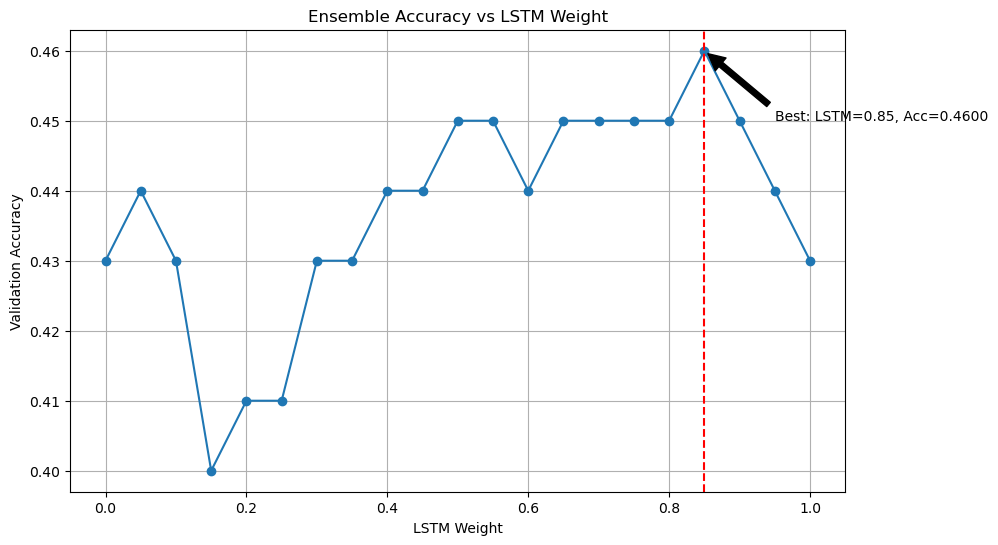


Evaluating ensemble on test set...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Ensemble test accuracy: 0.4358

Classification Report:
              precision    recall  f1-score   support

        High       0.16      0.19      0.17        91
         Low       0.52      0.63      0.57       272
      Medium       0.43      0.29      0.35       213

    accuracy                           0.44       576
   macro avg       0.37      0.37      0.37       576
weighted avg       0.43      0.44      0.43       576


Confusion Matrix:
[[ 17  44  30]
 [ 49 172  51]
 [ 39 112  62]]


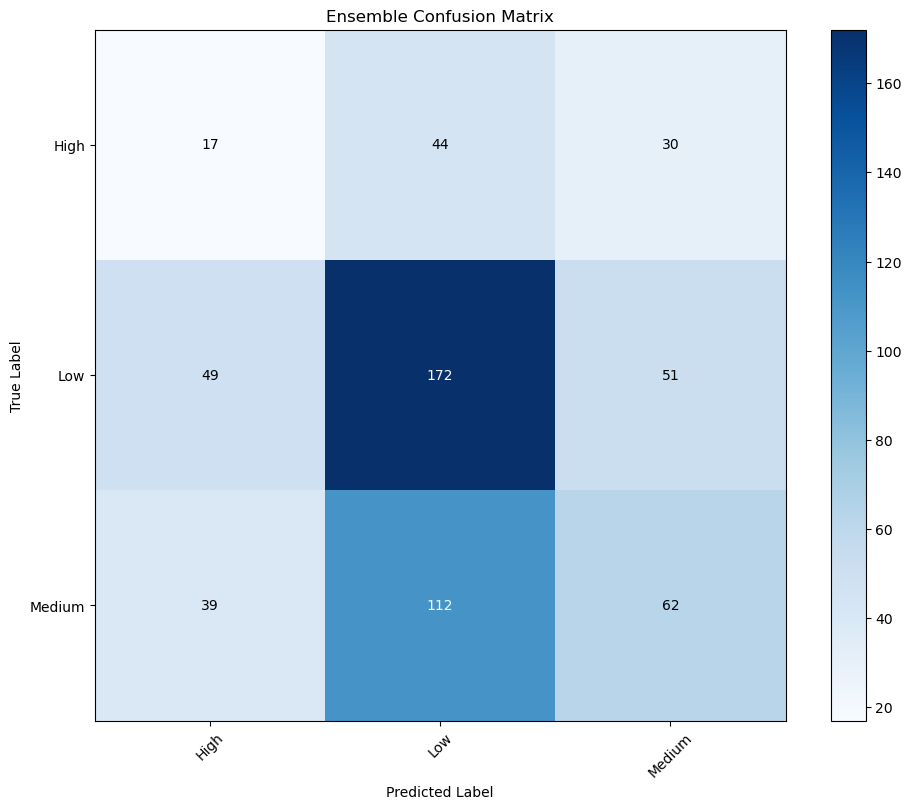


=== Performance Summary ===
LSTM Accuracy: 0.4375
GRU Accuracy: 0.4288
Ensemble Accuracy: 0.4358
Improvement: -0.0017 (+-0.40%)


In [46]:
# Complete Self-Contained Ensemble Implementation
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
from tqdm import tqdm
from scipy.fftpack import dct
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

#=====================================================
# Feature Extraction Functions
#=====================================================

def load_audio(file_path, sr=16000):
    """Load an audio file at specified sample rate"""
    try:
        y, _ = librosa.load(file_path, sr=sr)
        return y
    except Exception as e:
        print(f"Error loading audio {file_path}: {e}")
        return np.zeros(sr)  # Return silence if loading fails

def normalize_audio(y):
    """Normalize audio amplitude"""
    if np.max(np.abs(y)) > 0:
        return y / np.max(np.abs(y))
    return y

def trim_silence(y, top_db=20):
    """Trim leading and trailing silence"""
    try:
        trimmed_y, _ = librosa.effects.trim(y, top_db=top_db)
        return trimmed_y
    except Exception:
        return y  # Return original if trimming fails

def standardize_length(y, sr, target_duration_sec, method='pad_clip'):
    """Standardize audio to a fixed duration"""
    target_length = int(sr * target_duration_sec)
    
    if method == 'pad_clip':
        if len(y) < target_length:
            return np.pad(y, (0, target_length - len(y)))
        elif len(y) > target_length:
            return y[:target_length]
        else:
            return y
    else:
        raise ValueError(f"Unknown method: {method}")

def preprocess_audio(file_path, sr=16000, target_duration_sec=2.0):
    """Complete audio preprocessing pipeline"""
    # Load audio
    y = load_audio(file_path, sr=sr)
    
    # Trim silence
    y = trim_silence(y)
    
    # Normalize
    y = normalize_audio(y)
    
    # Standardize length
    y = standardize_length(y, sr, target_duration_sec)
    
    return y

class TimeSlicingFeatureExtractor:
    def __init__(self, 
                 sr=16000, 
                 time_window_ms=100,
                 n_mfcc=13,
                 lpc_order=14,
                 dct_length=13):
        """Initialize feature extractor for time-sliced audio"""
        self.sr = sr
        self.time_window_ms = time_window_ms
        self.n_mfcc = n_mfcc
        self.lpc_order = lpc_order
        self.dct_length = dct_length
        
        # Calculate number of samples per window
        self.samples_per_window = int(sr * time_window_ms / 1000)
        
        # Calculate total feature dimension per window
        self.features_per_window = n_mfcc + lpc_order + dct_length
        
        print(f"Time-slicing configuration:")
        print(f"- Time window: {time_window_ms}ms")
        print(f"- Samples per window: {self.samples_per_window}")
        print(f"- Features per window: {self.features_per_window}")
    
    def extract_mfcc(self, segment):
        """Extract MFCC features from an audio segment"""
        min_length = 512
        if len(segment) < min_length:
            segment = np.pad(segment, (0, min_length - len(segment)))
        
        try:
            mfccs = librosa.feature.mfcc(
                y=segment, 
                sr=self.sr, 
                n_mfcc=self.n_mfcc,
                n_fft=min(512, len(segment)),
                hop_length=min(128, len(segment)//4)
            )
            
            if mfccs.shape[1] > 0:
                features = np.mean(mfccs, axis=1)
            else:
                features = np.zeros(self.n_mfcc)
        except Exception:
            features = np.zeros(self.n_mfcc)
            
        # Ensure exact dimension
        if len(features) > self.n_mfcc:
            return features[:self.n_mfcc]
        elif len(features) < self.n_mfcc:
            return np.pad(features, (0, self.n_mfcc - len(features)))
        return features
    
    def extract_lpc(self, segment):
        """Extract LPC features from an audio segment"""
        if len(segment) <= self.lpc_order:
            segment = np.pad(segment, (0, self.lpc_order + 1 - len(segment)))
        
        try:
            lpc = librosa.lpc(segment, order=self.lpc_order)
            features = lpc[1:]
        except Exception:
            features = np.zeros(self.lpc_order)
            
        # Ensure exact dimension
        if len(features) > self.lpc_order:
            return features[:self.lpc_order]
        elif len(features) < self.lpc_order:
            return np.pad(features, (0, self.lpc_order - len(features)))
        return features
    
    def extract_dct(self, segment):
        """Extract DCT features from an audio segment"""
        n_fft = min(512, len(segment))
        if len(segment) < n_fft:
            segment = np.pad(segment, (0, n_fft - len(segment)))
        
        try:
            S = np.abs(librosa.stft(segment, n_fft=n_fft))
            power = S**2
            
            if power.shape[1] > 0:
                mean_power = np.mean(power, axis=1)
            else:
                mean_power = power.flatten()
            
            dct_coef = dct(mean_power, type=2, norm='ortho')
            features = dct_coef[:self.dct_length]
        except Exception:
            features = np.zeros(self.dct_length)
            
        # Ensure exact dimension
        if len(features) > self.dct_length:
            return features[:self.dct_length]
        elif len(features) < self.dct_length:
            return np.pad(features, (0, self.dct_length - len(features)))
        return features
    
    def sort_mfcc_features(self, features_sequence):
        """Sort MFCCs by magnitude as recommended by mentor"""
        sorted_features = features_sequence.copy()
        
        for i in range(sorted_features.shape[0]):
            mfccs = sorted_features[i, :self.n_mfcc]
            sorted_indices = np.argsort(-np.abs(mfccs))
            sorted_mfcc_values = mfccs[sorted_indices]
            sorted_features[i, :self.n_mfcc] = sorted_mfcc_values
        
        return sorted_features
    
    def extract_features_from_time_slices(self, audio, sort_mfccs=True):
        """Extract features from each time slice of the audio"""
        n_time_slices = len(audio) // self.samples_per_window
        features_sequence = np.zeros((n_time_slices, self.features_per_window))
        
        for i in range(n_time_slices):
            try:
                start = i * self.samples_per_window
                end = start + self.samples_per_window
                segment = audio[start:end]
                
                mfcc_features = self.extract_mfcc(segment)
                lpc_features = self.extract_lpc(segment)
                dct_features = self.extract_dct(segment)
                
                all_features = np.concatenate([mfcc_features, lpc_features, dct_features])
                
                if len(all_features) != self.features_per_window:
                    if len(all_features) > self.features_per_window:
                        all_features = all_features[:self.features_per_window]
                    else:
                        all_features = np.pad(all_features, (0, self.features_per_window - len(all_features)))
                
                features_sequence[i] = all_features
            except Exception:
                pass  # Keep zeros for this slice
        
        if sort_mfccs:
            features_sequence = self.sort_mfcc_features(features_sequence)
        
        return features_sequence

def process_features(features_sequence, standardize=True):
    """Process extracted features (normalize, etc.)"""
    features = features_sequence.copy()
    
    if standardize:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    
    return features

def prepare_dataset(data_split_file, audio_dir, sr=16000, duration_sec=2.0,
                   time_window_ms=100, standardize=True, sort_mfccs=True):
    """Prepare dataset with features for model training"""
    # Check files exist
    if not os.path.exists(data_split_file):
        raise FileNotFoundError(f"Data split file not found: {data_split_file}")
    
    if not os.path.exists(audio_dir):
        raise FileNotFoundError(f"Audio directory not found: {audio_dir}")
    
    # Load data split
    df = pd.read_csv(data_split_file)
    print(f"Loaded {len(df)} entries from {data_split_file}")
    
    # Initialize feature extractor
    feature_extractor = TimeSlicingFeatureExtractor(
        sr=sr,
        time_window_ms=time_window_ms,
        n_mfcc=13,
        lpc_order=14,
        dct_length=13
    )
    
    # Process each audio file
    X_sequences = []
    y = []
    
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Preparing dataset"):
        try:
            # Find the audio file
            filename = row['filename']
            file_path = os.path.join(audio_dir, filename)
            
            # Search recursively if not found directly
            if not os.path.exists(file_path):
                found = False
                for root, _, files in os.walk(audio_dir):
                    for file in files:
                        if file == filename:
                            file_path = os.path.join(root, file)
                            found = True
                            break
                    if found:
                        break
                
                if not found:
                    continue
            
            # Preprocess audio
            processed_audio = preprocess_audio(
                file_path, 
                sr=sr, 
                target_duration_sec=duration_sec
            )
            
            # Extract features
            features_sequence = feature_extractor.extract_features_from_time_slices(
                processed_audio, 
                sort_mfccs=sort_mfccs
            )
            
            # Process features
            processed_features = process_features(
                features_sequence,
                standardize=standardize
            )
            
            # Add to dataset
            X_sequences.append(processed_features)
            y.append(row['clarity_label'])
            
        except Exception:
            continue
    
    print(f"Successfully processed {len(X_sequences)} files")
    
    return X_sequences, np.array(y)

#=====================================================
# Ensemble Model
#=====================================================

class ClarityEnsemble:
    """Ensemble model combining LSTM and GRU predictions"""
    
    def __init__(self, lstm_model=None, gru_model=None):
        self.lstm_model = lstm_model
        self.gru_model = gru_model
        self.weights = [0.5, 0.5]  # Default equal weights
    
    def load_models(self, lstm_path='best_lstm_clarity_model.h5', gru_path='best_gru_clarity_model.h5'):
        """Load pre-trained models"""
        try:
            self.lstm_model = load_model(lstm_path)
            print(f"LSTM model loaded from {lstm_path}")
        except Exception as e:
            print(f"Error loading LSTM model: {e}")
        
        try:
            self.gru_model = load_model(gru_path)
            print(f"GRU model loaded from {gru_path}")
        except Exception as e:
            print(f"Error loading GRU model: {e}")
    
    def set_weights(self, lstm_weight=0.5, gru_weight=0.5):
        """Set ensemble weights"""
        total = lstm_weight + gru_weight
        self.weights = [lstm_weight/total, gru_weight/total]
        print(f"Ensemble weights set to: LSTM={self.weights[0]:.2f}, GRU={self.weights[1]:.2f}")
    
    def predict(self, X):
        """Generate ensemble predictions"""
        if self.lstm_model is None or self.gru_model is None:
            raise ValueError("Models not loaded. Call load_models() first.")
        
        # Get predictions from both models
        lstm_preds = self.lstm_model.predict(X)
        gru_preds = self.gru_model.predict(X)
        
        # Weighted average of predictions
        ensemble_preds = (self.weights[0] * lstm_preds) + (self.weights[1] * gru_preds)
        
        return ensemble_preds
    
    def evaluate(self, X_test, y_test, label_encoder):
        """Evaluate ensemble model performance"""
        # Get ensemble predictions
        ensemble_preds = self.predict(X_test)
        y_pred_encoded = np.argmax(ensemble_preds, axis=1)
        y_test_encoded = np.argmax(y_test, axis=1)
        
        # Convert back to original labels
        y_pred = label_encoder.inverse_transform(y_pred_encoded)
        y_true = label_encoder.inverse_transform(y_test_encoded)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_true, y_pred)
        print(f"\nEnsemble test accuracy: {accuracy:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        print("\nConfusion Matrix:")
        print(cm)
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Ensemble Confusion Matrix')
        plt.colorbar()
        
        # Add labels
        classes = label_encoder.classes_
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        return accuracy, y_pred, ensemble_preds
    
    def optimize_weights(self, X_val, y_val, verbose=True):
        """Find optimal weights for ensemble using validation set"""
        if self.lstm_model is None or self.gru_model is None:
            raise ValueError("Models not loaded. Call load_models() first.")
        
        # Get base predictions
        lstm_preds = self.lstm_model.predict(X_val)
        gru_preds = self.gru_model.predict(X_val)
        
        # Try different weight combinations
        best_accuracy = 0
        best_weights = [0.5, 0.5]
        
        # Convert y_val to class indices
        y_val_indices = np.argmax(y_val, axis=1)
        
        print("Optimizing ensemble weights...")
        results = []
        
        for lstm_weight in np.linspace(0, 1, 21):  # 0.0, 0.05, 0.1, ..., 1.0
            gru_weight = 1 - lstm_weight
            
            # Weighted average
            ensemble_preds = (lstm_weight * lstm_preds) + (gru_weight * gru_preds)
            y_pred = np.argmax(ensemble_preds, axis=1)
            
            # Calculate accuracy
            accuracy = accuracy_score(y_val_indices, y_pred)
            results.append((lstm_weight, gru_weight, accuracy))
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_weights = [lstm_weight, gru_weight]
        
        # Set the optimal weights
        self.weights = best_weights
        
        if verbose:
            print(f"Optimal weights: LSTM={self.weights[0]:.2f}, GRU={self.weights[1]:.2f}")
            print(f"Validation accuracy with optimal weights: {best_accuracy:.4f}")
            
            # Plot weight vs accuracy
            weights = [r[0] for r in results]
            accuracies = [r[2] for r in results]
            
            plt.figure(figsize=(10, 6))
            plt.plot(weights, accuracies, 'o-')
            plt.axvline(x=best_weights[0], color='r', linestyle='--')
            plt.title('Ensemble Accuracy vs LSTM Weight')
            plt.xlabel('LSTM Weight')
            plt.ylabel('Validation Accuracy')
            plt.grid(True)
            plt.annotate(f'Best: LSTM={best_weights[0]:.2f}, Acc={best_accuracy:.4f}',
                        xy=(best_weights[0], best_accuracy),
                        xytext=(best_weights[0]+0.1, best_accuracy-0.01),
                        arrowprops=dict(facecolor='black', shrink=0.05))
            plt.show()
        
        return best_weights, best_accuracy

# Evaluate individual models
def evaluate_individual_models(X_test, y_test, lstm_model, gru_model, label_encoder):
    """Evaluate individual LSTM and GRU models on test set"""
    # LSTM evaluation
    lstm_preds = lstm_model.predict(X_test)
    lstm_pred_classes = np.argmax(lstm_preds, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    lstm_accuracy = accuracy_score(y_test_classes, lstm_pred_classes)
    print(f"LSTM Test Accuracy: {lstm_accuracy:.4f}")
    
    # GRU evaluation
    gru_preds = gru_model.predict(X_test)
    gru_pred_classes = np.argmax(gru_preds, axis=1)
    
    gru_accuracy = accuracy_score(y_test_classes, gru_pred_classes)
    print(f"GRU Test Accuracy: {gru_accuracy:.4f}")
    
    # Calculate confusion matrices
    lstm_cm = confusion_matrix(y_test_classes, lstm_pred_classes)
    gru_cm = confusion_matrix(y_test_classes, gru_pred_classes)
    
    # Convert class indices to labels
    y_test_labels = label_encoder.inverse_transform(y_test_classes)
    lstm_pred_labels = label_encoder.inverse_transform(lstm_pred_classes)
    gru_pred_labels = label_encoder.inverse_transform(gru_pred_classes)
    
    # Print classification reports
    print("\nLSTM Classification Report:")
    print(classification_report(y_test_labels, lstm_pred_labels))
    
    print("\nGRU Classification Report:")
    print(classification_report(y_test_labels, gru_pred_labels))
    
    return lstm_accuracy, gru_accuracy, lstm_cm, gru_cm

# Main function to run the ensemble
def run_ensemble_with_data_loading():
    """Complete pipeline that loads data and evaluates ensemble"""
    # Paths
    train_split = "data_splits/train.csv"
    val_split = "data_splits/validation.csv"
    test_split = "data_splits/test.csv"
    audio_dir = "./extracted_audio_data/Audios and excels/Cleaned_Audios"
    
    # Load and prepare data (smaller subset for faster processing)
    print("Loading test and validation data...")
    
    # For validation, we can use a smaller subset
    val_df = pd.read_csv(val_split)
    val_df = val_df.sample(min(100, len(val_df)), random_state=42)
    val_df.to_csv("temp_val.csv", index=False)
    
    X_val, y_val = prepare_dataset("temp_val.csv", audio_dir)
    
    # For test, we need all data for proper evaluation
    X_test, y_test = prepare_dataset(test_split, audio_dir)
    
    # Pad sequences to the same length
    max_length = max(
        max(len(seq) for seq in X_val),
        max(len(seq) for seq in X_test)
    )
    
    def pad_sequences(sequences, max_length):
        padded = []
        for seq in sequences:
            if len(seq) < max_length:
                # Get feature dimension
                n_feat = seq.shape[1]
                # Pad with zeros
                padding = np.zeros((max_length - len(seq), n_feat))
                padded_seq = np.vstack([seq, padding])
            else:
                padded_seq = seq[:max_length]  # Truncate if longer
            padded.append(padded_seq)
        return np.array(padded)
    
    X_val_padded = pad_sequences(X_val, max_length)
    X_test_padded = pad_sequences(X_test, max_length)
    
    # Encode labels
    label_encoder = LabelEncoder()
    label_encoder.fit(['High', 'Medium', 'Low'])  # Ensure consistent mapping
    
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)
    
    y_val_categorical = to_categorical(y_val_encoded)
    y_test_categorical = to_categorical(y_test_encoded)
    
    # Load models
    print("\nLoading pre-trained models...")
    ensemble = ClarityEnsemble()
    ensemble.load_models()
    
    # Evaluate individual models
    print("\nEvaluating individual models...")
    lstm_acc, gru_acc, lstm_cm, gru_cm = evaluate_individual_models(
        X_test_padded, y_test_categorical, 
        ensemble.lstm_model, ensemble.gru_model, 
        label_encoder
    )
    
    # Optimize ensemble weights
    print("\nOptimizing ensemble weights...")
    best_weights, val_acc = ensemble.optimize_weights(X_val_padded, y_val_categorical)
    
    # Evaluate ensemble on test set
    print("\nEvaluating ensemble on test set...")
    ensemble_acc, _, _ = ensemble.evaluate(X_test_padded, y_test_categorical, label_encoder)
    
    # Print summary
    print("\n=== Performance Summary ===")
    print(f"LSTM Accuracy: {lstm_acc:.4f}")
    print(f"GRU Accuracy: {gru_acc:.4f}")
    print(f"Ensemble Accuracy: {ensemble_acc:.4f}")
    
    # Calculate improvement
    best_individual = max(lstm_acc, gru_acc)
    improvement = ensemble_acc - best_individual
    improvement_percent = (improvement / best_individual) * 100 if best_individual > 0 else 0
    
    print(f"Improvement: {improvement:.4f} (+{improvement_percent:.2f}%)")
    
    # Clean up temporary files
    if os.path.exists("temp_val.csv"):
        os.remove("temp_val.csv")
    
    return ensemble, ensemble_acc

# Run the complete ensemble pipeline
ensemble, accuracy = run_ensemble_with_data_loading()

Starting Clarity Assessment Stacking Ensemble Pipeline
=== Data Preparation ===
Preparing training dataset...
Loaded 2685 entries from data_splits/train.csv
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   0%|                       | 5/2685 [00:00<02:41, 16.55it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   2%|▎                     | 42/2685 [00:02<02:06, 20.83it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   3%|▋                     | 89/2685 [00:04<01:52, 23.00it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s43.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   8%|█▋                   | 212/2685 [00:09<01:51, 22.21it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s31.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  11%|██▎                  | 290/2685 [00:13<01:44, 23.00it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s50.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  11%|██▎                  | 301/2685 [00:13<02:07, 18.63it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  12%|██▌                  | 321/2685 [00:14<01:50, 21.43it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s18.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  19%|███▉                 | 498/2685 [00:22<01:32, 23.58it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s26.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  24%|████▉                | 638/2685 [00:29<01:35, 21.52it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s8.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  26%|█████▌               | 707/2685 [00:32<01:28, 22.29it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/105_s21.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  33%|██████▉              | 893/2685 [00:40<01:16, 23.52it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s25.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  34%|███████▏             | 914/2685 [00:41<01:15, 23.47it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s52.mp3: 
Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s40.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  35%|███████▍             | 953/2685 [00:42<01:12, 23.74it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  36%|███████▋             | 976/2685 [00:44<01:26, 19.67it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s21.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  37%|███████▊             | 997/2685 [00:45<01:14, 22.55it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s27.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  37%|███████▍            | 1006/2685 [00:45<01:21, 20.57it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  38%|███████▋            | 1024/2685 [00:46<01:09, 23.74it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s10.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  39%|███████▉            | 1060/2685 [00:47<01:06, 24.43it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  40%|███████▉            | 1069/2685 [00:48<01:22, 19.54it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  44%|████████▋           | 1174/2685 [00:53<01:12, 20.72it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  45%|████████▉           | 1198/2685 [00:54<01:08, 21.57it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  46%|█████████▎          | 1248/2685 [00:56<01:00, 23.63it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s23.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  47%|█████████▎          | 1254/2685 [00:56<01:05, 21.83it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s36.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  47%|█████████▍          | 1272/2685 [00:57<01:04, 22.06it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s26.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  49%|█████████▉          | 1326/2685 [01:00<01:03, 21.29it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s31.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  51%|██████████          | 1358/2685 [01:02<01:06, 19.94it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/105_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  51%|██████████▏         | 1376/2685 [01:02<00:59, 22.06it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  52%|██████████▍         | 1400/2685 [01:04<01:09, 18.46it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  52%|██████████▍         | 1405/2685 [01:04<01:03, 20.23it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s30.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  53%|██████████▌         | 1411/2685 [01:04<00:59, 21.50it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s47.mp3: 
Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s34.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  53%|██████████▌         | 1423/2685 [01:05<00:54, 23.01it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s11.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  54%|██████████▊         | 1453/2685 [01:06<00:58, 20.97it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s41.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  55%|██████████▉         | 1465/2685 [01:07<00:56, 21.61it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s9.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s19.mp3: 
Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  56%|███████████▏        | 1507/2685 [01:09<00:48, 24.30it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  57%|███████████▍        | 1531/2685 [01:10<00:52, 21.85it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s35.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  57%|███████████▍        | 1543/2685 [01:10<00:53, 21.21it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s8.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  58%|███████████▌        | 1555/2685 [01:11<00:53, 21.07it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s51.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  60%|████████████        | 1617/2685 [01:14<00:50, 21.31it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s27.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  61%|████████████▏       | 1632/2685 [01:15<00:49, 21.18it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s54.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  61%|████████████▏       | 1644/2685 [01:15<00:48, 21.46it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  64%|████████████▊       | 1725/2685 [01:19<00:41, 22.96it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s10.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  65%|█████████████       | 1752/2685 [01:20<00:40, 23.04it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  66%|█████████████▏      | 1764/2685 [01:21<00:39, 23.20it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s18.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  67%|█████████████▎      | 1788/2685 [01:22<00:42, 21.03it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s23.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  67%|█████████████▍      | 1797/2685 [01:22<00:40, 21.73it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s9.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  67%|█████████████▍      | 1803/2685 [01:22<00:40, 21.74it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/105_s22.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  69%|█████████████▊      | 1857/2685 [01:25<00:37, 22.17it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  72%|██████████████▎     | 1926/2685 [01:28<00:32, 23.14it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s53.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  73%|██████████████▌     | 1947/2685 [01:29<00:33, 22.09it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s32.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s16.mp3: 
Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s21.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  76%|███████████████▏    | 2034/2685 [01:33<00:27, 23.33it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s16.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  76%|███████████████▏    | 2046/2685 [01:33<00:28, 22.21it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s49.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  77%|███████████████▍    | 2067/2685 [01:34<00:29, 21.04it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  79%|███████████████▊    | 2115/2685 [01:36<00:26, 21.79it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s38.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  82%|████████████████▎   | 2190/2685 [01:40<00:21, 23.49it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s16.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  82%|████████████████▍   | 2211/2685 [01:41<00:21, 22.48it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  83%|████████████████▋   | 2232/2685 [01:42<00:18, 24.27it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s11.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  84%|████████████████▊   | 2250/2685 [01:42<00:18, 23.12it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s16.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  86%|█████████████████▏  | 2307/2685 [01:45<00:16, 23.61it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s22.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  89%|█████████████████▊  | 2390/2685 [01:49<00:15, 19.52it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s39.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  89%|█████████████████▊  | 2396/2685 [01:49<00:13, 20.93it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  90%|█████████████████▉  | 2410/2685 [01:50<00:13, 20.98it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s46.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  92%|██████████████████▎ | 2457/2685 [01:52<00:10, 22.29it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s25.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  92%|██████████████████▍ | 2475/2685 [01:53<00:09, 22.57it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s9.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  94%|██████████████████▊ | 2529/2685 [01:56<00:06, 22.75it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  95%|██████████████████▉ | 2550/2685 [01:57<00:06, 21.45it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s44.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  95%|███████████████████ | 2556/2685 [01:57<00:06, 21.45it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s45.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  98%|███████████████████▌| 2619/2685 [02:00<00:02, 22.33it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/105_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  98%|███████████████████▋| 2637/2685 [02:01<00:02, 21.35it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s29.mp3: 


Preparing dataset: 100%|████████████████████| 2685/2685 [02:03<00:00, 21.78it/s]


Successfully processed 2685 files
Preparing validation dataset...
Loaded 576 entries from data_splits/validation.csv
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  16%|███▌                   | 90/576 [00:03<00:22, 21.85it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s30.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  32%|██████▉               | 183/576 [00:08<00:18, 21.71it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  40%|████████▊             | 231/576 [00:10<00:15, 22.60it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s18.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s10.mp3: 
Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s29.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  49%|██████████▉           | 285/576 [00:12<00:13, 21.99it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s28.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  80%|█████████████████▌    | 459/576 [00:20<00:05, 21.92it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/105_s23.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  83%|██████████████████▏   | 477/576 [00:21<00:04, 22.40it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s11.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  92%|████████████████████▏ | 528/576 [00:23<00:01, 24.28it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s42.mp3: 


Preparing dataset: 100%|██████████████████████| 576/576 [00:25<00:00, 22.33it/s]


Successfully processed 576 files
Preparing test dataset...
Loaded 576 entries from data_splits/test.csv
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s20.mp3: 
Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  16%|███▋                   | 93/576 [00:04<00:20, 23.69it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  34%|███████▌              | 198/576 [00:08<00:15, 23.82it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s37.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  39%|████████▍             | 222/576 [00:09<00:14, 23.85it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  53%|███████████▊          | 308/576 [00:13<00:10, 24.43it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s48.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  55%|████████████          | 317/576 [00:14<00:11, 22.55it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s28.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  61%|█████████████▍        | 353/576 [00:15<00:09, 23.93it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  79%|█████████████████▍    | 455/576 [00:20<00:05, 21.47it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  81%|█████████████████▊    | 467/576 [00:21<00:05, 21.74it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  83%|██████████████████▎   | 479/576 [00:22<00:04, 22.60it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s22.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  85%|██████████████████▊   | 491/576 [00:22<00:03, 23.62it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/105_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  87%|███████████████████▏  | 503/576 [00:23<00:03, 23.35it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s33.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  94%|████████████████████▌ | 539/576 [00:24<00:01, 24.17it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s18.mp3: 


Preparing dataset: 100%|██████████████████████| 576/576 [00:26<00:00, 22.01it/s]


Successfully processed 576 files
Applying SMOTE to balance classes...
Original data: 2685 sequences with 40 features
Original class distribution: Counter({np.str_('Low'): 1268, np.str_('Medium'): 993, np.str_('High'): 424})
Resampled data: 3804 sequences
Resampled class distribution: Counter({np.str_('Low'): 1268, np.str_('Medium'): 1268, np.str_('High'): 1268})

=== Creating Stacking Ensemble ===
Loading pre-trained LSTM model...


LSTM model loaded from best_lstm_clarity_model.h5


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 64)         │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 5, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,915 (808.26 KB)

 Trainable params: 206,019 (804.76 KB)

 Non-trainable params: 896 (3.50 KB)


Training CNN model...
Epoch 1/50
118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3462 - loss: 2.0763 
Epoch 1: val_accuracy improved from -inf to 0.41840, saving model to best_cnn_clarity_model.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3465 - loss: 2.0727 - val_accuracy: 0.4184 - val_loss: 1.3496 - learning_rate: 5.0000e-04
Epoch 2/50
117/119 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3929 - loss: 1.5125 
Epoch 2: val_accuracy improved from 0.41840 to 0.42882, saving model to best_cnn_clarity_model.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3928 - loss: 1.5117 - val_accuracy: 0.4288 - val_loss: 1.3459 - learning_rate: 5.0000e-04
Epoch 3/50
117/119 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4237 - loss: 1.3880 
Epoch 3: val_accuracy did not improve from 0.42882
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4236 - loss: 1.3880 - val_accuracy: 0.4288 - val_loss: 1.3390 - learning_rate: 5.0000e-04
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4174 - loss: 1.3632 
Epoch 4: val_accuracy improved from 0.42882 to 0.43056, saving model to best_cnn_clarity_model.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4174 - loss: 1.3631 - val_accuracy: 0.4306 - val_loss: 1.3409 - learning_rate: 5.0000e-04
Epoch 5/50
116/119 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4458 - loss: 1.3135
Epoch 5: val_accuracy improved from 0.43056 to 0.44271, saving model to best_cnn_clarity_model.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4457 - loss: 1.3136 - val_accuracy: 0.4427 - val_loss: 1.3252 - learning_rate: 5.0000e-04
Epoch 6/50
117/119 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4389 - loss: 1.2919 
Epoch 6: val_accuracy did not improve from 0.44271
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4390 - loss: 1.2919 - val_accuracy: 0.4288 - val_loss: 1.3279 - learning_rate: 5.0000e-04
Epoch 7/50
112/119 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4549 - loss: 1.2807 
Epoch 7: val_accuracy did not improve from 0.44271
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4550 - loss: 1.2806 - val_accuracy: 0.4132 - val_loss: 1.3218 - learning_rate: 5.0000e-04
Epoch 8/50
115/119 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4531 - loss: 1.2781 
Epoch 8: val_accuracy did not improve from 0.44271
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4535 - loss: 1.2777 - val_accuracy: 0.4062 - val_loss: 1.3347 - learning_rate: 5.0000e-04
Epoch

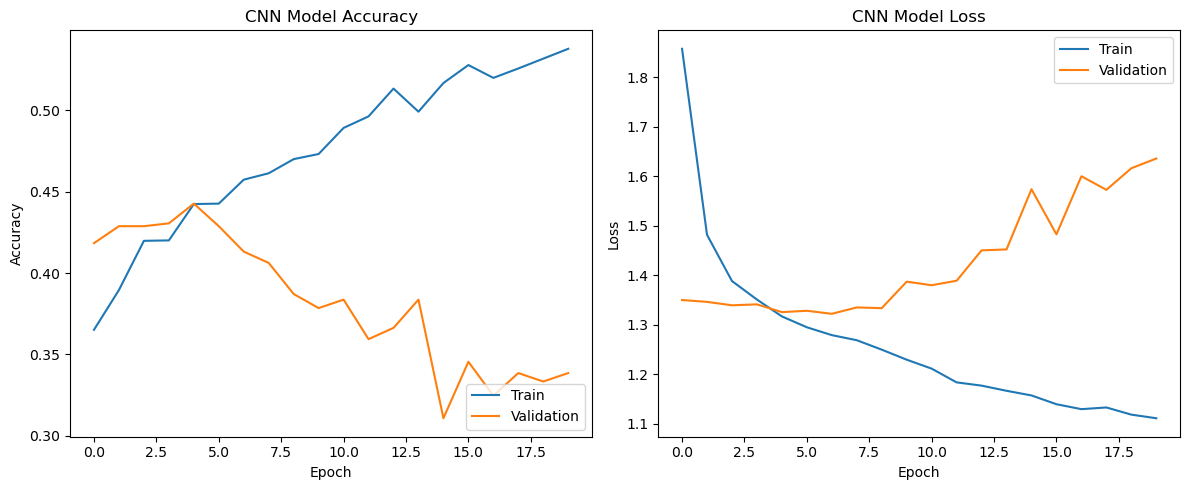

Training Random Forest with 800 features...
Random Forest training complete

Generating base predictions for meta-model training...
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Training meta-model with 9 features...
Meta-model training complete

=== Stacking Ensemble Evaluation ===
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Stacking Ensemble test accuracy: 0.4497

Classification Report:
              precision    recall  f1-score   support

        High       0.15      0.03      0.05        91
         Low       0.62      0.34      0.44       272
      Medium       0.40      0.77      0.53       213

    accuracy                           0.45       576
   macro avg       0.39      0.38      0.34       576
weighted avg       0.46      0.45      0.41       576


Confusion Matrix:
[[  3  12  76]
 [ 13  92 167]
 [  4  45 164]]


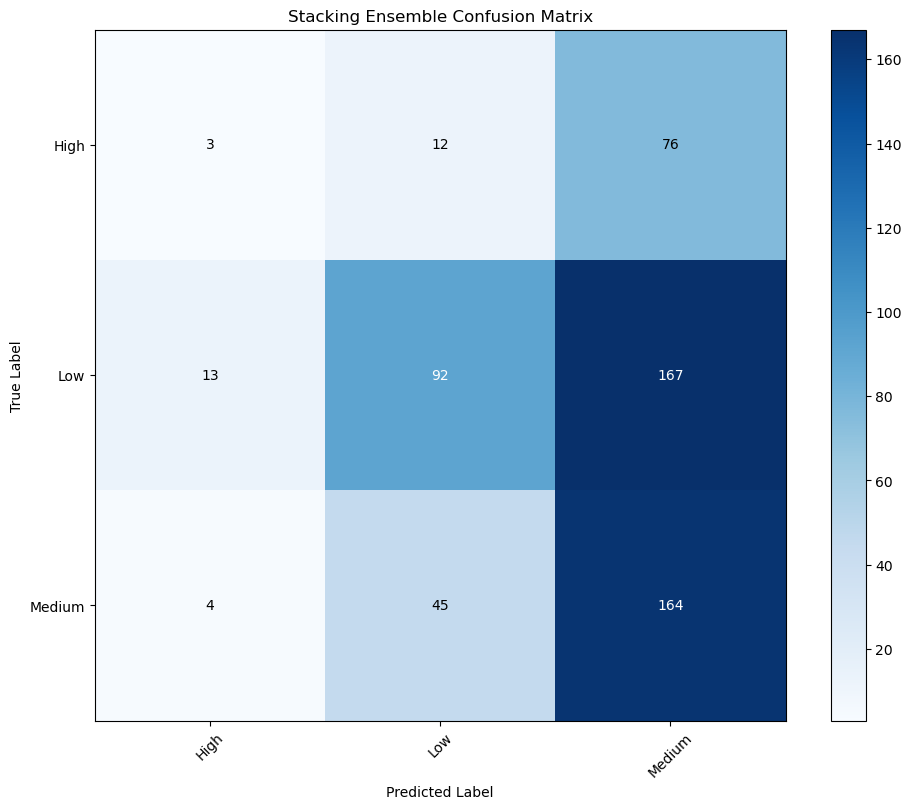


Base Model Performances:
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Accuracy: 0.4375
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
CNN Accuracy: 0.3941
Random Forest Accuracy: 0.4705

Final stacking ensemble accuracy: 0.4497
Final stacking ensemble accuracy: 0.4497


In [48]:
# Complete Stacking Ensemble with Data Preparation
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
from tqdm import tqdm
from scipy.fftpack import dct
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

#=====================================================
# Data Preparation Functions (Same as your previous code)
#=====================================================

def load_audio(file_path, sr=16000):
    """Load an audio file at specified sample rate"""
    try:
        y, _ = librosa.load(file_path, sr=sr)
        return y
    except Exception as e:
        print(f"Error loading audio {file_path}: {e}")
        return np.zeros(sr)  # Return silence if loading fails

def normalize_audio(y):
    """Normalize audio amplitude"""
    if np.max(np.abs(y)) > 0:
        return y / np.max(np.abs(y))
    return y

def trim_silence(y, top_db=20):
    """Trim leading and trailing silence"""
    try:
        trimmed_y, _ = librosa.effects.trim(y, top_db=top_db)
        return trimmed_y
    except Exception:
        return y  # Return original if trimming fails

def standardize_length(y, sr, target_duration_sec, method='pad_clip'):
    """Standardize audio to a fixed duration"""
    target_length = int(sr * target_duration_sec)
    
    if method == 'pad_clip':
        if len(y) < target_length:
            return np.pad(y, (0, target_length - len(y)))
        elif len(y) > target_length:
            return y[:target_length]
        else:
            return y
    else:
        raise ValueError(f"Unknown method: {method}")

def preprocess_audio(file_path, sr=16000, target_duration_sec=2.0):
    """Complete audio preprocessing pipeline"""
    # Load audio
    y = load_audio(file_path, sr=sr)
    
    # Trim silence
    y = trim_silence(y)
    
    # Normalize
    y = normalize_audio(y)
    
    # Standardize length
    y = standardize_length(y, sr, target_duration_sec)
    
    return y

class TimeSlicingFeatureExtractor:
    def __init__(self, 
                 sr=16000, 
                 time_window_ms=100,
                 n_mfcc=13,
                 lpc_order=14,
                 dct_length=13):
        """Initialize feature extractor for time-sliced audio"""
        self.sr = sr
        self.time_window_ms = time_window_ms
        self.n_mfcc = n_mfcc
        self.lpc_order = lpc_order
        self.dct_length = dct_length
        
        # Calculate number of samples per window
        self.samples_per_window = int(sr * time_window_ms / 1000)
        
        # Calculate total feature dimension per window
        self.features_per_window = n_mfcc + lpc_order + dct_length
        
        print(f"Time-slicing configuration:")
        print(f"- Time window: {time_window_ms}ms")
        print(f"- Samples per window: {self.samples_per_window}")
        print(f"- Features per window: {self.features_per_window}")
    
    def extract_mfcc(self, segment):
        """Extract MFCC features from an audio segment"""
        min_length = 512
        if len(segment) < min_length:
            segment = np.pad(segment, (0, min_length - len(segment)))
        
        try:
            mfccs = librosa.feature.mfcc(
                y=segment, 
                sr=self.sr, 
                n_mfcc=self.n_mfcc,
                n_fft=min(512, len(segment)),
                hop_length=min(128, len(segment)//4)
            )
            
            if mfccs.shape[1] > 0:
                features = np.mean(mfccs, axis=1)
            else:
                features = np.zeros(self.n_mfcc)
        except Exception:
            features = np.zeros(self.n_mfcc)
            
        # Ensure exact dimension
        if len(features) > self.n_mfcc:
            return features[:self.n_mfcc]
        elif len(features) < self.n_mfcc:
            return np.pad(features, (0, self.n_mfcc - len(features)))
        return features
    
    def extract_lpc(self, segment):
        """Extract LPC features from an audio segment"""
        if len(segment) <= self.lpc_order:
            segment = np.pad(segment, (0, self.lpc_order + 1 - len(segment)))
        
        try:
            lpc = librosa.lpc(segment, order=self.lpc_order)
            features = lpc[1:]
        except Exception:
            features = np.zeros(self.lpc_order)
            
        # Ensure exact dimension
        if len(features) > self.lpc_order:
            return features[:self.lpc_order]
        elif len(features) < self.lpc_order:
            return np.pad(features, (0, self.lpc_order - len(features)))
        return features
    
    def extract_dct(self, segment):
        """Extract DCT features from an audio segment"""
        n_fft = min(512, len(segment))
        if len(segment) < n_fft:
            segment = np.pad(segment, (0, n_fft - len(segment)))
        
        try:
            S = np.abs(librosa.stft(segment, n_fft=n_fft))
            power = S**2
            
            if power.shape[1] > 0:
                mean_power = np.mean(power, axis=1)
            else:
                mean_power = power.flatten()
            
            dct_coef = dct(mean_power, type=2, norm='ortho')
            features = dct_coef[:self.dct_length]
        except Exception:
            features = np.zeros(self.dct_length)
            
        # Ensure exact dimension
        if len(features) > self.dct_length:
            return features[:self.dct_length]
        elif len(features) < self.dct_length:
            return np.pad(features, (0, self.dct_length - len(features)))
        return features
    
    def sort_mfcc_features(self, features_sequence):
        """Sort MFCCs by magnitude as recommended by mentor"""
        sorted_features = features_sequence.copy()
        
        for i in range(sorted_features.shape[0]):
            mfccs = sorted_features[i, :self.n_mfcc]
            sorted_indices = np.argsort(-np.abs(mfccs))
            sorted_mfcc_values = mfccs[sorted_indices]
            sorted_features[i, :self.n_mfcc] = sorted_mfcc_values
        
        return sorted_features
    
    def extract_features_from_time_slices(self, audio, sort_mfccs=True):
        """Extract features from each time slice of the audio"""
        n_time_slices = len(audio) // self.samples_per_window
        features_sequence = np.zeros((n_time_slices, self.features_per_window))
        
        for i in range(n_time_slices):
            try:
                start = i * self.samples_per_window
                end = start + self.samples_per_window
                segment = audio[start:end]
                
                mfcc_features = self.extract_mfcc(segment)
                lpc_features = self.extract_lpc(segment)
                dct_features = self.extract_dct(segment)
                
                all_features = np.concatenate([mfcc_features, lpc_features, dct_features])
                
                if len(all_features) != self.features_per_window:
                    if len(all_features) > self.features_per_window:
                        all_features = all_features[:self.features_per_window]
                    else:
                        all_features = np.pad(all_features, (0, self.features_per_window - len(all_features)))
                
                features_sequence[i] = all_features
            except Exception:
                pass  # Keep zeros for this slice
        
        if sort_mfccs:
            features_sequence = self.sort_mfcc_features(features_sequence)
        
        return features_sequence

def process_features(features_sequence, standardize=True):
    """Process extracted features (normalize, etc.)"""
    features = features_sequence.copy()
    
    if standardize:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    
    return features

def prepare_dataset(data_split_file, audio_dir, sr=16000, duration_sec=2.0,
                    time_window_ms=100, standardize=True, sort_mfccs=True):
    """Prepare dataset with features for model training"""
    # Check files exist
    if not os.path.exists(data_split_file):
        raise FileNotFoundError(f"Data split file not found: {data_split_file}")
    
    if not os.path.exists(audio_dir):
        raise FileNotFoundError(f"Audio directory not found: {audio_dir}")
    
    # Load data split
    df = pd.read_csv(data_split_file)
    print(f"Loaded {len(df)} entries from {data_split_file}")
    
    # Initialize feature extractor
    feature_extractor = TimeSlicingFeatureExtractor(
        sr=sr,
        time_window_ms=time_window_ms,
        n_mfcc=13,
        lpc_order=14,
        dct_length=13
    )
    
    # Process each audio file
    X_sequences = []
    y = []
    
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Preparing dataset"):
        try:
            # Find the audio file
            filename = row['filename']
            file_path = os.path.join(audio_dir, filename)
            
            # Search recursively if not found directly
            if not os.path.exists(file_path):
                found = False
                for root, _, files in os.walk(audio_dir):
                    for file in files:
                        if file == filename:
                            file_path = os.path.join(root, file)
                            found = True
                            break
                    if found:
                        break
                
                if not found:
                    continue
            
            # Preprocess audio
            processed_audio = preprocess_audio(
                file_path, 
                sr=sr, 
                target_duration_sec=duration_sec
            )
            
            # Extract features
            features_sequence = feature_extractor.extract_features_from_time_slices(
                processed_audio, 
                sort_mfccs=sort_mfccs
            )
            
            # Process features
            processed_features = process_features(
                features_sequence,
                standardize=standardize
            )
            
            # Add to dataset
            X_sequences.append(processed_features)
            y.append(row['clarity_label'])
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            continue
    
    print(f"Successfully processed {len(X_sequences)} files")
    
    return X_sequences, np.array(y)

def apply_smote(X_sequences, y_labels):
    """Apply SMOTE to balance classes for sequential data"""
    print("Applying SMOTE to balance classes...")
    
    # Ensure we're working with numpy arrays
    y_labels = np.array(y_labels)
    
    # Find the maximum sequence length
    max_length = max(seq.shape[0] for seq in X_sequences)
    n_features = X_sequences[0].shape[1]
    
    print(f"Original data: {len(X_sequences)} sequences with {n_features} features")
    print(f"Original class distribution: {Counter(y_labels)}")
    
    # Pad sequences to same length before flattening
    X_padded = []
    for seq in X_sequences:
        if seq.shape[0] < max_length:
            # Pad with zeros
            padding = np.zeros((max_length - seq.shape[0], n_features))
            padded_seq = np.vstack([seq, padding])
        else:
            padded_seq = seq
        X_padded.append(padded_seq)
    
    # Convert to numpy array
    X_array = np.array(X_padded)
    
    # Reshape for SMOTE (samples, timesteps*features)
    n_samples = len(X_array)
    X_flat = X_array.reshape(n_samples, max_length * n_features)
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_flat_resampled, y_resampled = smote.fit_resample(X_flat, y_labels)
    
    # Reshape back to 3D (samples, timesteps, features)
    n_resampled = X_flat_resampled.shape[0]
    X_resampled = X_flat_resampled.reshape(n_resampled, max_length, n_features)
    
    print(f"Resampled data: {len(X_resampled)} sequences")
    print(f"Resampled class distribution: {Counter(y_resampled)}")
    
    return X_resampled, y_resampled

def prepare_model_data(train_split, val_split, test_split, audio_dir, max_samples=None):
    """Prepare data for all models from all splits"""
    print("Preparing training dataset...")
    X_train, y_train = prepare_dataset(
        train_split, audio_dir, 
        sort_mfccs=True
    )
    
    print("Preparing validation dataset...")
    X_val, y_val = prepare_dataset(
        val_split, audio_dir,
        sort_mfccs=True
    )
    
    print("Preparing test dataset...")
    X_test, y_test = prepare_dataset(
        test_split, audio_dir,
        sort_mfccs=True
    )
    
    # Apply SMOTE only to training data
    X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)
    
    # Find the maximum sequence length
    max_length = max(
        max(len(seq) for seq in X_train_resampled),
        max(len(seq) for seq in X_val),
        max(len(seq) for seq in X_test)
    )
    
    # Pad all sequences to the same length
    def pad_sequences(sequences, max_length):
        padded = []
        for seq in sequences:
            if len(seq) < max_length:
                # Get feature dimension
                n_feat = seq.shape[1]
                # Pad with zeros
                padding = np.zeros((max_length - len(seq), n_feat))
                padded_seq = np.vstack([seq, padding])
            else:
                padded_seq = seq[:max_length]  # Truncate if longer
            padded.append(padded_seq)
        return np.array(padded)
    
    X_train_padded = pad_sequences(X_train_resampled, max_length)
    X_val_padded = pad_sequences(X_val, max_length)
    X_test_padded = pad_sequences(X_test, max_length)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_resampled)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Convert to categorical
    y_train_categorical = to_categorical(y_train_encoded)
    y_val_categorical = to_categorical(y_val_encoded)
    y_test_categorical = to_categorical(y_test_encoded)
    
    return (X_train_padded, y_train_categorical, 
            X_val_padded, y_val_categorical,
            X_test_padded, y_test_categorical,
            label_encoder)

#=====================================================
# Stacking Ensemble Model
#=====================================================

class ClarityStackingEnsemble:
    """
    Stacking ensemble for clarity assessment that combines:
    1. LSTM model (sequential patterns)
    2. CNN model (spectral patterns)
    3. RandomForest (non-sequential patterns)
    """
    
    def __init__(self):
        # Base models
        self.lstm_model = None
        self.cnn_model = None
        self.rf_model = None
        
        # Meta-model
        self.meta_model = None
        
        # Label encoder
        self.label_encoder = None
    
    def load_base_models(self, lstm_path='best_lstm_clarity_model.h5'):
        """Load pre-trained base models"""
        # Load LSTM model
        try:
            self.lstm_model = load_model(lstm_path)
            print(f"LSTM model loaded from {lstm_path}")
        except Exception as e:
            print(f"Error loading LSTM model: {e}")
            self.lstm_model = None
    
    def build_cnn_model(self, input_shape, num_classes):
        """Build a CNN model for clarity assessment"""
        model = Sequential([
            # Input layer
            Input(shape=input_shape),
            
            # First Conv1D block
            Conv1D(64, kernel_size=3, activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),
            
            # Second Conv1D block
            Conv1D(128, kernel_size=3, activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),
            
            # Third Conv1D block
            Conv1D(256, kernel_size=3, activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),
            
            # Flatten and Dense layers
            Flatten(),
            Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dropout(0.5),
            Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dropout(0.4),
            
            # Output layer
            Dense(num_classes, activation='softmax')
        ])
        
        # Compile model with learning rate reduction
        optimizer = Adam(learning_rate=0.0005)
        model.compile(
            loss='categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy']
        )
        
        model.summary()
        
        return model
    
    def train_cnn_model(self, X_train, y_train, X_val, y_val):
        """Train a CNN model for the ensemble"""
        # Get input shape and number of classes
        input_shape = (X_train.shape[1], X_train.shape[2])
        num_classes = y_train.shape[1]
        
        # Build model
        model = self.build_cnn_model(input_shape, num_classes)
        
        # Class weights for imbalance
        y_integers = np.argmax(y_train, axis=1)
        class_counts = np.bincount(y_integers)
        total_samples = np.sum(class_counts)
        class_weights = {i: (total_samples / (len(class_counts) * count)) ** 0.5
                        for i, count in enumerate(class_counts)}
        
        # Callbacks
        callbacks = [
            # Early stopping
            EarlyStopping(
                monitor='val_accuracy',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            # Learning rate reduction
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            ),
            # Save best model
            ModelCheckpoint(
                'best_cnn_clarity_model.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]
        
        # Train model
        print("\nTraining CNN model...")
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=32,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Load best model
        model.load_weights('best_cnn_clarity_model.h5')
        
        # Plot training history
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('CNN Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('CNN Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        
        plt.tight_layout()
        plt.show()
        
        return model
    
    def train_rf_model(self, X_train, y_train):
        """Train a Random Forest model for the ensemble"""
        # Flatten the sequential features
        X_train_flat = np.array([x.flatten() for x in X_train])
        y_train_classes = np.argmax(y_train, axis=1)
        
        print(f"Training Random Forest with {X_train_flat.shape[1]} features...")
        
        # Train Random Forest
        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            bootstrap=True,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        
        rf.fit(X_train_flat, y_train_classes)
        print("Random Forest training complete")
        
        return rf
    
    def train_meta_model(self, base_predictions, y_true):
        """Train meta-model to combine base predictions"""
        # Combine all base predictions
        X_meta = np.hstack(base_predictions)
        y_meta = np.argmax(y_true, axis=1)
        
        print(f"Training meta-model with {X_meta.shape[1]} features...")
        
        # Train meta model (Gradient Boosting)
        meta_model = GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,
            min_samples_split=10,
            min_samples_leaf=5,
            subsample=0.8,
            random_state=42
        )
        
        meta_model.fit(X_meta, y_meta)
        print("Meta-model training complete")
        
        return meta_model
    
    def get_base_predictions(self, X, flatten_for_rf=True):
        """Get predictions from all base models"""
        # Check if models are loaded
        if self.lstm_model is None or self.cnn_model is None or self.rf_model is None:
            raise ValueError("Models not loaded. Train or load models first.")
        
        # Get predictions from LSTM
        lstm_preds = self.lstm_model.predict(X)
        
        # Get predictions from CNN
        cnn_preds = self.cnn_model.predict(X)
        
        # Get predictions from RF (requires flattened features)
        if flatten_for_rf:
            X_flat = np.array([x.flatten() for x in X])
            rf_preds = self.rf_model.predict_proba(X_flat)
        else:
            # If X is already flattened
            rf_preds = self.rf_model.predict_proba(X)
        
        return [lstm_preds, cnn_preds, rf_preds]
    
    def train(self, X_train, y_train, X_val, y_val):
        """Train the full stacking ensemble"""
        # Train CNN model
        self.cnn_model = self.train_cnn_model(X_train, y_train, X_val, y_val)
        
        # Train Random Forest model
        self.rf_model = self.train_rf_model(X_train, y_train)
        
        # Generate base predictions for meta-model training
        print("Generating base predictions for meta-model training...")
        train_preds = self.get_base_predictions(X_train)
        
        # Train meta-model
        self.meta_model = self.train_meta_model(train_preds, y_train)
        
        return self
    
    def predict(self, X):
        """Generate stacked ensemble predictions"""
        # Get base predictions
        base_preds = self.get_base_predictions(X)
        
        # Stack predictions for meta-model
        X_meta = np.hstack(base_preds)
        
        # Meta-model prediction
        y_pred = self.meta_model.predict(X_meta)
        
        # Convert to one-hot encoding if needed
        if self.label_encoder is not None:
            y_pred = self.label_encoder.inverse_transform(y_pred)
        
        return y_pred
    
    def predict_proba(self, X):
        """Generate probability predictions from the ensemble"""
        # Get base predictions
        base_preds = self.get_base_predictions(X)
        
        # Stack predictions for meta-model
        X_meta = np.hstack(base_preds)
        
        # Meta-model probability prediction
        y_pred_proba = self.meta_model.predict_proba(X_meta)
        
        return y_pred_proba
    
    def evaluate(self, X_test, y_test, label_encoder=None):
        """Evaluate stacking ensemble performance"""
        self.label_encoder = label_encoder
        
        # Get ensemble predictions
        if label_encoder is not None:
            y_test_encoded = np.argmax(y_test, axis=1)
            
            # Get probability predictions
            y_pred_proba = self.predict_proba(X_test)
            
            # Get class predictions
            y_pred_encoded = np.argmax(y_pred_proba, axis=1)
            
            # Convert to original labels
            y_pred = label_encoder.inverse_transform(y_pred_encoded)
            y_true = label_encoder.inverse_transform(y_test_encoded)
        else:
            # Assume y_test is already class indices
            y_pred_proba = self.predict_proba(X_test)
            y_pred_encoded = np.argmax(y_pred_proba, axis=1)
            y_pred = y_pred_encoded
            y_true = np.argmax(y_test, axis=1)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_true, y_pred)
        print(f"\nStacking Ensemble test accuracy: {accuracy:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        print("\nConfusion Matrix:")
        print(cm)
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Stacking Ensemble Confusion Matrix')
        plt.colorbar()
        
        # Add labels
        if label_encoder is not None:
            classes = label_encoder.classes_
        else:
            classes = [f"Class {i}" for i in range(len(np.unique(y_true)))]
            
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Evaluate individual base models
        print("\nBase Model Performances:")
        
        # LSTM
        lstm_preds = self.lstm_model.predict(X_test)
        lstm_pred_classes = np.argmax(lstm_preds, axis=1)
        lstm_accuracy = accuracy_score(y_test_encoded, lstm_pred_classes)
        print(f"LSTM Accuracy: {lstm_accuracy:.4f}")
        
        # CNN
        cnn_preds = self.cnn_model.predict(X_test)
        cnn_pred_classes = np.argmax(cnn_preds, axis=1)
        cnn_accuracy = accuracy_score(y_test_encoded, cnn_pred_classes)
        print(f"CNN Accuracy: {cnn_accuracy:.4f}")
        
        # RF
        X_test_flat = np.array([x.flatten() for x in X_test])
        rf_pred_classes = self.rf_model.predict(X_test_flat)
        rf_accuracy = accuracy_score(y_test_encoded, rf_pred_classes)
        print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
        
        return accuracy, y_pred, y_pred_proba

#=====================================================
# Main Execution Function
#=====================================================

def run_stacking_ensemble_pipeline():
   """Run the complete stacking ensemble pipeline with data preparation"""
   # Define paths
   train_split = "data_splits/train.csv"
   val_split = "data_splits/validation.csv"
   test_split = "data_splits/test.csv"
   audio_dir = "./extracted_audio_data/Audios and excels/Cleaned_Audios"
   
   # Prepare data
   print("=== Data Preparation ===")
   X_train, y_train, X_val, y_val, X_test, y_test, label_encoder = prepare_model_data(
       train_split, val_split, test_split, audio_dir
   )
   
   # Create and train stacking ensemble
   print("\n=== Creating Stacking Ensemble ===")
   ensemble = ClarityStackingEnsemble()
   
   # Load pre-trained LSTM model
   print("Loading pre-trained LSTM model...")
   ensemble.load_base_models()
   
   if ensemble.lstm_model is None:
       print("Error: Could not load pre-trained LSTM model. Exiting.")
       return None, 0
   
   # Train CNN model
   ensemble.cnn_model = ensemble.train_cnn_model(X_train, y_train, X_val, y_val)
   
   # Train Random Forest model
   ensemble.rf_model = ensemble.train_rf_model(X_train, y_train)
   
   # Generate base predictions for meta-model training
   print("\nGenerating base predictions for meta-model training...")
   train_preds = ensemble.get_base_predictions(X_train)
   
   # Train meta-model
   ensemble.meta_model = ensemble.train_meta_model(train_preds, y_train)
   
   # Evaluate stacking ensemble
   print("\n=== Stacking Ensemble Evaluation ===")
   accuracy, _, _ = ensemble.evaluate(X_test, y_test, label_encoder)
   
   print(f"\nFinal stacking ensemble accuracy: {accuracy:.4f}")
   
   return ensemble, accuracy

# Run the complete pipeline
if __name__ == "__main__":
   print("Starting Clarity Assessment Stacking Ensemble Pipeline")
   print("========================================================")
   
   ensemble, accuracy = run_stacking_ensemble_pipeline()
   
   print("========================================================")
   print(f"Final stacking ensemble accuracy: {accuracy:.4f}")

In [49]:
print("TRYING WITH ML MODELS<")

TRYING WITH ML MODELS<


Starting ML Model Evaluation for Clarity Assessment
=== Data Preparation for ML Models ===
Loading and extracting features...

Processing training set...
Loaded 2685 entries from data_splits/train.csv
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   0%|                       | 7/2685 [00:00<02:25, 18.39it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   2%|▎                     | 42/2685 [00:02<02:01, 21.72it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   3%|▋                     | 90/2685 [00:04<01:47, 24.20it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s43.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   8%|█▋                   | 213/2685 [00:09<01:46, 23.16it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s31.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  11%|██▎                  | 288/2685 [00:13<01:41, 23.65it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s50.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  11%|██▎                  | 300/2685 [00:13<01:42, 23.22it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  12%|██▌                  | 321/2685 [00:14<01:44, 22.53it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s18.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  18%|███▉                 | 496/2685 [00:22<01:34, 23.07it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s26.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  24%|████▉                | 639/2685 [00:29<01:33, 21.77it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s8.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  26%|█████▌               | 708/2685 [00:32<01:26, 22.81it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/105_s21.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  33%|██████▉              | 891/2685 [00:40<01:13, 24.30it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s25.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  34%|███████▏             | 915/2685 [00:41<01:13, 23.93it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  35%|███████▍             | 948/2685 [00:42<01:12, 24.10it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s52.mp3: 
Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s40.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  36%|███████▍             | 954/2685 [00:43<01:12, 23.97it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  36%|███████▌             | 974/2685 [00:44<01:26, 19.87it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s21.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  37%|███████▊             | 998/2685 [00:45<01:15, 22.22it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s27.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  38%|███████▌            | 1007/2685 [00:45<01:17, 21.69it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s17.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  38%|███████▌            | 1022/2685 [00:46<01:09, 23.84it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s10.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  40%|███████▉            | 1061/2685 [00:48<01:11, 22.86it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  40%|███████▉            | 1067/2685 [00:48<01:12, 22.42it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  44%|████████▊           | 1175/2685 [00:53<01:03, 23.83it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  45%|████████▉           | 1196/2685 [00:54<01:06, 22.25it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  46%|█████████▎          | 1247/2685 [00:56<00:58, 24.50it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s23.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  47%|█████████▎          | 1253/2685 [00:56<01:03, 22.47it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s36.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  47%|█████████▍          | 1271/2685 [00:57<01:07, 20.97it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s26.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s31.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  51%|██████████▏         | 1360/2685 [01:01<00:59, 22.32it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/105_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  51%|██████████▎         | 1378/2685 [01:02<00:57, 22.76it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s17.mp3: 
Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s30.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  53%|██████████▌         | 1411/2685 [01:03<00:54, 23.17it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s47.mp3: 
Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s34.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  53%|██████████▌         | 1423/2685 [01:04<00:53, 23.63it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s11.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  54%|██████████▊         | 1453/2685 [01:05<00:54, 22.46it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s41.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  55%|██████████▉         | 1465/2685 [01:06<00:54, 22.50it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s9.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s19.mp3: 
Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  56%|███████████▏        | 1507/2685 [01:08<00:47, 25.01it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  57%|███████████▍        | 1531/2685 [01:09<00:49, 23.48it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s35.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  57%|███████████▍        | 1543/2685 [01:09<00:48, 23.55it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s8.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  58%|███████████▌        | 1555/2685 [01:10<00:47, 23.57it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s51.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  60%|████████████        | 1618/2685 [01:12<00:44, 23.81it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s27.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  61%|████████████▏       | 1633/2685 [01:13<00:46, 22.52it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s54.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  61%|████████████▎       | 1645/2685 [01:14<00:45, 22.78it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  64%|████████████▊       | 1726/2685 [01:17<00:41, 23.01it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s10.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  65%|█████████████       | 1753/2685 [01:18<00:41, 22.57it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  66%|█████████████       | 1762/2685 [01:19<00:41, 22.50it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s18.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  67%|█████████████▎      | 1789/2685 [01:20<00:40, 21.91it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s23.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  67%|█████████████▎      | 1795/2685 [01:20<00:41, 21.56it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s9.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  67%|█████████████▍      | 1804/2685 [01:21<00:39, 22.21it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/105_s22.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  69%|█████████████▊      | 1858/2685 [01:23<00:35, 23.17it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s15.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  72%|██████████████▎     | 1927/2685 [01:26<00:31, 23.71it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s53.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  72%|██████████████▍     | 1945/2685 [01:27<00:32, 22.53it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s32.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s16.mp3: 
Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s21.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  76%|███████████████▏    | 2035/2685 [01:31<00:27, 23.51it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s16.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  76%|███████████████▏    | 2047/2685 [01:31<00:26, 23.66it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s49.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  77%|███████████████▍    | 2068/2685 [01:32<00:28, 21.97it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  79%|███████████████▊    | 2115/2685 [01:35<00:29, 19.24it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s38.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  82%|████████████████▎   | 2190/2685 [01:38<00:20, 23.59it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s16.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  82%|████████████████▍   | 2211/2685 [01:39<00:20, 23.12it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  83%|████████████████▋   | 2235/2685 [01:40<00:18, 24.92it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s11.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  84%|████████████████▊   | 2250/2685 [01:41<00:18, 23.53it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s16.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  86%|█████████████████▏  | 2307/2685 [01:43<00:15, 24.31it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s22.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  89%|█████████████████▊  | 2391/2685 [01:47<00:12, 23.27it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s39.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  89%|█████████████████▊  | 2397/2685 [01:47<00:12, 23.52it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s13.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  90%|█████████████████▉  | 2412/2685 [01:48<00:11, 23.07it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s46.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  92%|██████████████████▎ | 2457/2685 [01:50<00:09, 23.88it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s25.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  92%|██████████████████▍ | 2475/2685 [01:50<00:08, 23.55it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s9.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  94%|██████████████████▊ | 2529/2685 [01:53<00:06, 23.59it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  95%|██████████████████▉ | 2550/2685 [01:54<00:05, 22.51it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s44.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  95%|███████████████████ | 2556/2685 [01:54<00:05, 22.38it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s45.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  98%|███████████████████▌| 2619/2685 [01:57<00:02, 22.98it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/105_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  98%|███████████████████▋| 2637/2685 [01:57<00:02, 22.50it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s29.mp3: 


Preparing dataset: 100%|████████████████████| 2685/2685 [01:59<00:00, 22.40it/s]


Successfully processed 2685 files

Processing validation set...
Loaded 576 entries from data_splits/validation.csv
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  16%|███▌                   | 90/576 [00:03<00:21, 22.86it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s30.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  32%|██████▉               | 183/576 [00:07<00:17, 22.85it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/106_s12.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  40%|████████▊             | 231/576 [00:09<00:15, 22.94it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s18.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s10.mp3: 
Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s29.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  49%|██████████▉           | 285/576 [00:12<00:12, 22.63it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s28.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  80%|█████████████████▌    | 459/576 [00:19<00:05, 22.49it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/105_s23.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  83%|██████████████████▏   | 477/576 [00:20<00:04, 23.41it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s11.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  92%|████████████████████▏ | 528/576 [00:22<00:01, 24.89it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s42.mp3: 


Preparing dataset: 100%|██████████████████████| 576/576 [00:24<00:00, 23.09it/s]


Successfully processed 576 files

Processing test set...
Loaded 576 entries from data_splits/test.csv
Time-slicing configuration:
- Time window: 100ms
- Samples per window: 1600
- Features per window: 40


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:   5%|█▏                     | 31/576 [00:01<00:22, 24.13it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s20.mp3: 
Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  16%|███▋                   | 91/576 [00:03<00:20, 23.46it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  34%|███████▌              | 198/576 [00:08<00:15, 24.18it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s37.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  39%|████████▍             | 222/576 [00:09<00:15, 22.34it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  53%|███████████▋          | 307/576 [00:13<00:10, 24.89it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s48.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  55%|████████████▏         | 319/576 [00:14<00:11, 22.48it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s28.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  61%|█████████████▍        | 352/576 [00:15<00:08, 25.24it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s14.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  79%|█████████████████▎    | 454/576 [00:20<00:05, 23.72it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/102_s20.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  81%|█████████████████▉    | 469/576 [00:20<00:04, 23.14it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/107_s19.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  83%|██████████████████▎   | 478/576 [00:21<00:04, 23.51it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s22.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  86%|██████████████████▊   | 493/576 [00:21<00:03, 24.55it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/105_s24.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  87%|███████████████████▏  | 502/576 [00:22<00:03, 24.20it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s33.mp3: 


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
Preparing dataset:  94%|████████████████████▋ | 541/576 [00:23<00:01, 24.94it/s]

Error loading audio ./extracted_audio_data/Audios and excels/Cleaned_Audios/108_s18.mp3: 


Preparing dataset: 100%|██████████████████████| 576/576 [00:25<00:00, 22.77it/s]


Successfully processed 576 files

Flattening features...
Flattened feature shapes:
- Training: (2685, 800)
- Validation: (576, 800)
- Test: (576, 800)

Encoding labels...

Applying SMOTE for class balancing...
Original class distribution: [ 424 1268  993]
Resampled class distribution: [1268 1268 1268]

=== Training and Evaluating ML Models ===

--- Training Random Forest ---
Validation accuracy: 0.5087
Test accuracy: 0.4826
Training time: 4.48 seconds

Classification Report:
              precision    recall  f1-score   support

        High       0.10      0.01      0.02        91
         Low       0.53      0.63      0.58       272
      Medium       0.43      0.50      0.46       213

    accuracy                           0.48       576
   macro avg       0.36      0.38      0.35       576
weighted avg       0.43      0.48      0.45       576


Confusion Matrix:
[[  1  43  47]
 [  8 171  93]
 [  1 106 106]]


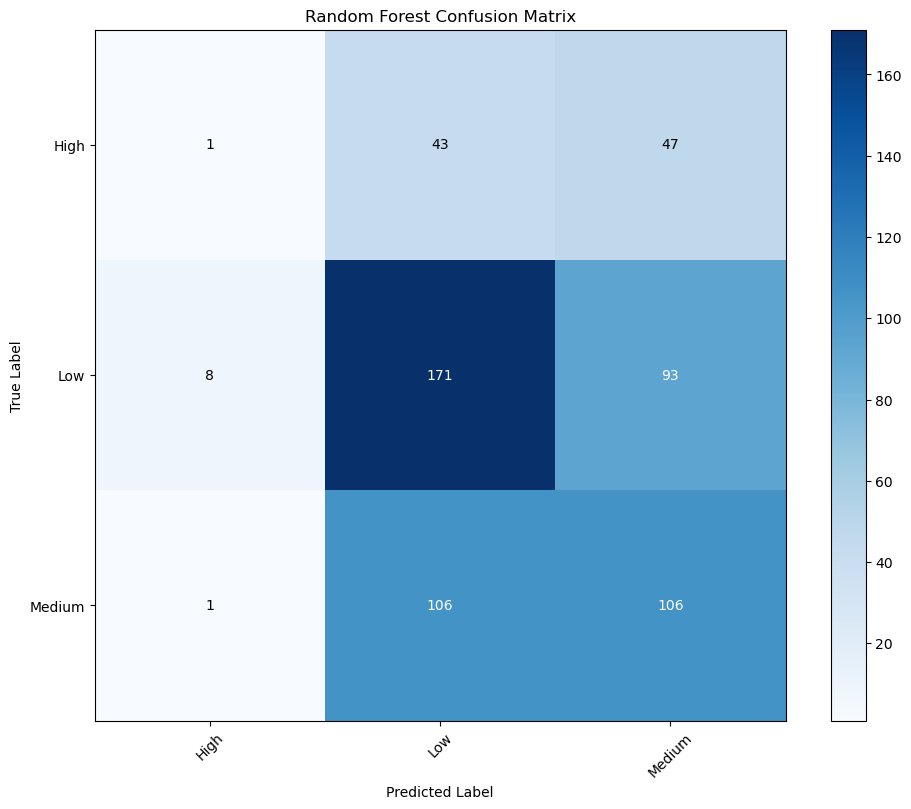


--- Training Gradient Boosting ---
Validation accuracy: 0.4826
Test accuracy: 0.5035
Training time: 943.04 seconds

Classification Report:
              precision    recall  f1-score   support

        High       0.25      0.03      0.06        91
         Low       0.57      0.68      0.62       272
      Medium       0.43      0.47      0.45       213

    accuracy                           0.50       576
   macro avg       0.42      0.40      0.38       576
weighted avg       0.47      0.50      0.47       576


Confusion Matrix:
[[  3  35  53]
 [  5 186  81]
 [  4 108 101]]


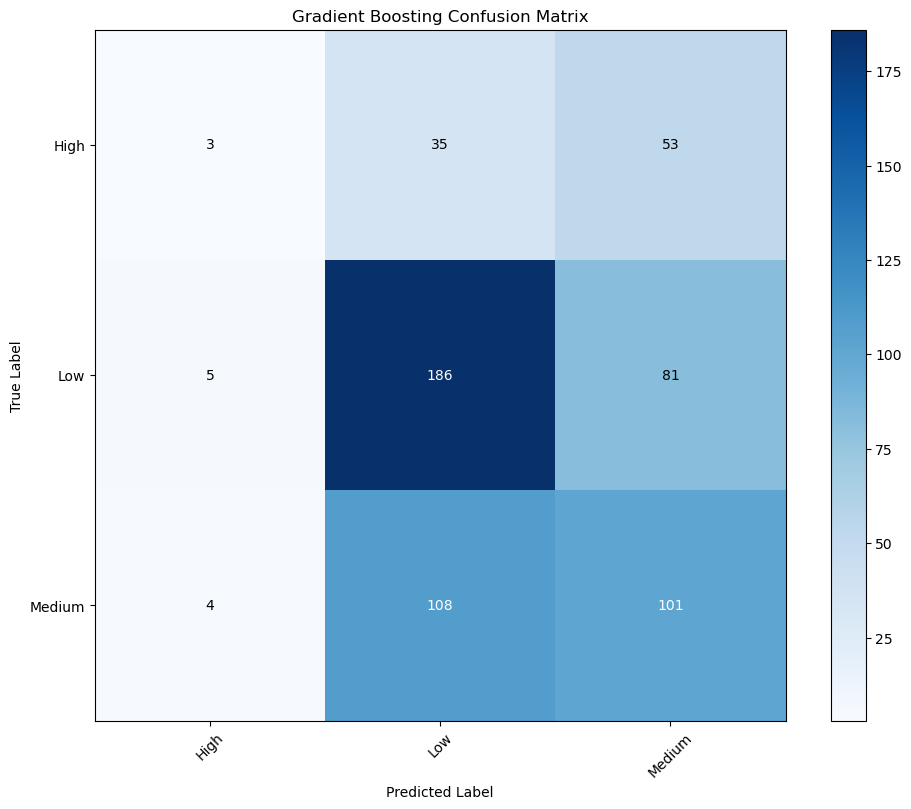


--- Training AdaBoost ---
Validation accuracy: 0.4740
Test accuracy: 0.3698
Training time: 59.21 seconds

--- Training SVM ---
Validation accuracy: 0.4774
Test accuracy: 0.4288
Training time: 63.23 seconds

--- Training K-Nearest Neighbors ---
Validation accuracy: 0.1910
Test accuracy: 0.2066
Training time: 0.25 seconds

--- Training Logistic Regression ---
Validation accuracy: 0.3993
Test accuracy: 0.3542
Training time: 13.89 seconds

--- Training Neural Network ---
Validation accuracy: 0.4358
Test accuracy: 0.4358
Training time: 35.58 seconds

=== Model Performance Comparison ===


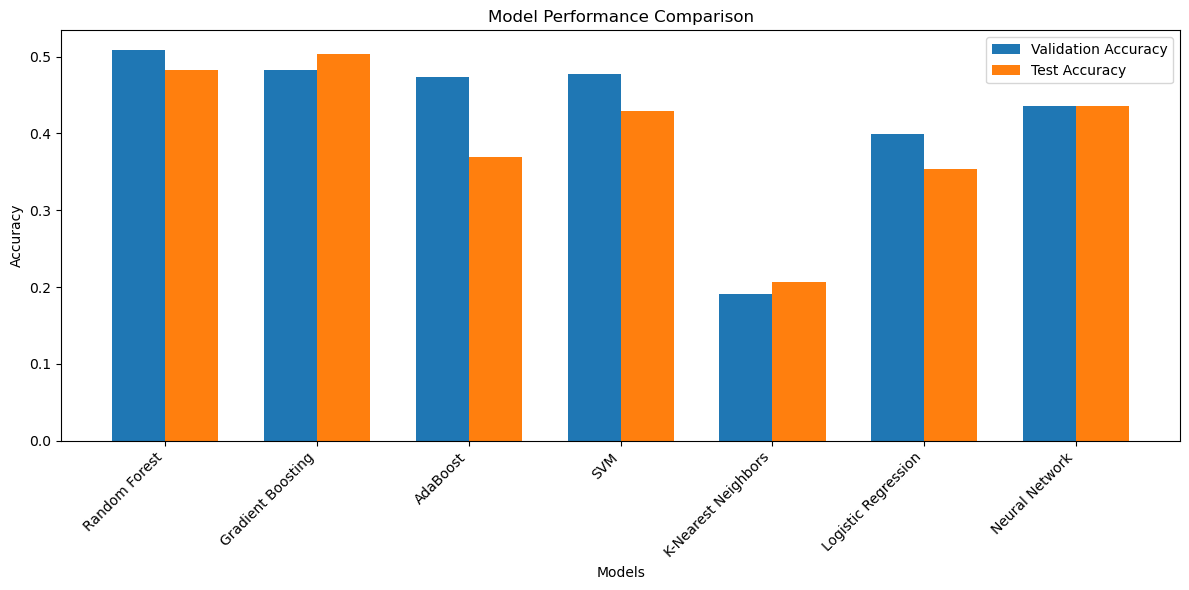


Model Performance Summary:
Random Forest:
  - Validation accuracy: 0.5087
  - Test accuracy: 0.4826
  - Training time: 4.48 seconds
Gradient Boosting:
  - Validation accuracy: 0.4826
  - Test accuracy: 0.5035
  - Training time: 943.04 seconds
AdaBoost:
  - Validation accuracy: 0.4740
  - Test accuracy: 0.3698
  - Training time: 59.21 seconds
SVM:
  - Validation accuracy: 0.4774
  - Test accuracy: 0.4288
  - Training time: 63.23 seconds
K-Nearest Neighbors:
  - Validation accuracy: 0.1910
  - Test accuracy: 0.2066
  - Training time: 0.25 seconds
Logistic Regression:
  - Validation accuracy: 0.3993
  - Test accuracy: 0.3542
  - Training time: 13.89 seconds
Neural Network:
  - Validation accuracy: 0.4358
  - Test accuracy: 0.4358
  - Training time: 35.58 seconds

Best model: Gradient Boosting with test accuracy: 0.5035
Best model: Gradient Boosting


In [51]:
# Complete ML Models for Clarity Assessment with Data Preparation
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import time
import warnings
import os
import librosa
from tqdm import tqdm
from scipy.fftpack import dct
from tensorflow.keras.utils import to_categorical

# Suppress warnings
warnings.filterwarnings('ignore')

#=====================================================
# Data Preparation Functions
#=====================================================

def load_audio(file_path, sr=16000):
    """Load an audio file at specified sample rate"""
    try:
        y, _ = librosa.load(file_path, sr=sr)
        return y
    except Exception as e:
        print(f"Error loading audio {file_path}: {e}")
        return np.zeros(sr)  # Return silence if loading fails

def normalize_audio(y):
    """Normalize audio amplitude"""
    if np.max(np.abs(y)) > 0:
        return y / np.max(np.abs(y))
    return y

def trim_silence(y, top_db=20):
    """Trim leading and trailing silence"""
    try:
        trimmed_y, _ = librosa.effects.trim(y, top_db=top_db)
        return trimmed_y
    except Exception:
        return y  # Return original if trimming fails

def standardize_length(y, sr, target_duration_sec, method='pad_clip'):
    """Standardize audio to a fixed duration"""
    target_length = int(sr * target_duration_sec)
    
    if method == 'pad_clip':
        if len(y) < target_length:
            return np.pad(y, (0, target_length - len(y)))
        elif len(y) > target_length:
            return y[:target_length]
        else:
            return y
    else:
        raise ValueError(f"Unknown method: {method}")

def preprocess_audio(file_path, sr=16000, target_duration_sec=2.0):
    """Complete audio preprocessing pipeline"""
    # Load audio
    y = load_audio(file_path, sr=sr)
    
    # Trim silence
    y = trim_silence(y)
    
    # Normalize
    y = normalize_audio(y)
    
    # Standardize length
    y = standardize_length(y, sr, target_duration_sec)
    
    return y

class TimeSlicingFeatureExtractor:
    def __init__(self, 
                 sr=16000, 
                 time_window_ms=100,
                 n_mfcc=13,
                 lpc_order=14,
                 dct_length=13):
        """Initialize feature extractor for time-sliced audio"""
        self.sr = sr
        self.time_window_ms = time_window_ms
        self.n_mfcc = n_mfcc
        self.lpc_order = lpc_order
        self.dct_length = dct_length
        
        # Calculate number of samples per window
        self.samples_per_window = int(sr * time_window_ms / 1000)
        
        # Calculate total feature dimension per window
        self.features_per_window = n_mfcc + lpc_order + dct_length
        
        print(f"Time-slicing configuration:")
        print(f"- Time window: {time_window_ms}ms")
        print(f"- Samples per window: {self.samples_per_window}")
        print(f"- Features per window: {self.features_per_window}")
    
    def extract_mfcc(self, segment):
        """Extract MFCC features from an audio segment"""
        min_length = 512
        if len(segment) < min_length:
            segment = np.pad(segment, (0, min_length - len(segment)))
        
        try:
            mfccs = librosa.feature.mfcc(
                y=segment, 
                sr=self.sr, 
                n_mfcc=self.n_mfcc,
                n_fft=min(512, len(segment)),
                hop_length=min(128, len(segment)//4)
            )
            
            if mfccs.shape[1] > 0:
                features = np.mean(mfccs, axis=1)
            else:
                features = np.zeros(self.n_mfcc)
        except Exception:
            features = np.zeros(self.n_mfcc)
            
        # Ensure exact dimension
        if len(features) > self.n_mfcc:
            return features[:self.n_mfcc]
        elif len(features) < self.n_mfcc:
            return np.pad(features, (0, self.n_mfcc - len(features)))
        return features
    
    def extract_lpc(self, segment):
        """Extract LPC features from an audio segment"""
        if len(segment) <= self.lpc_order:
            segment = np.pad(segment, (0, self.lpc_order + 1 - len(segment)))
        
        try:
            lpc = librosa.lpc(segment, order=self.lpc_order)
            features = lpc[1:]
        except Exception:
            features = np.zeros(self.lpc_order)
            
        # Ensure exact dimension
        if len(features) > self.lpc_order:
            return features[:self.lpc_order]
        elif len(features) < self.lpc_order:
            return np.pad(features, (0, self.lpc_order - len(features)))
        return features
    
    def extract_dct(self, segment):
        """Extract DCT features from an audio segment"""
        n_fft = min(512, len(segment))
        if len(segment) < n_fft:
            segment = np.pad(segment, (0, n_fft - len(segment)))
        
        try:
            S = np.abs(librosa.stft(segment, n_fft=n_fft))
            power = S**2
            
            if power.shape[1] > 0:
                mean_power = np.mean(power, axis=1)
            else:
                mean_power = power.flatten()
            
            dct_coef = dct(mean_power, type=2, norm='ortho')
            features = dct_coef[:self.dct_length]
        except Exception:
            features = np.zeros(self.dct_length)
            
        # Ensure exact dimension
        if len(features) > self.dct_length:
            return features[:self.dct_length]
        elif len(features) < self.dct_length:
            return np.pad(features, (0, self.dct_length - len(features)))
        return features
    
    def sort_mfcc_features(self, features_sequence):
        """Sort MFCCs by magnitude as recommended by mentor"""
        sorted_features = features_sequence.copy()
        
        for i in range(sorted_features.shape[0]):
            mfccs = sorted_features[i, :self.n_mfcc]
            sorted_indices = np.argsort(-np.abs(mfccs))
            sorted_mfcc_values = mfccs[sorted_indices]
            sorted_features[i, :self.n_mfcc] = sorted_mfcc_values
        
        return sorted_features
    
    def extract_features_from_time_slices(self, audio, sort_mfccs=True):
        """Extract features from each time slice of the audio"""
        n_time_slices = len(audio) // self.samples_per_window
        features_sequence = np.zeros((n_time_slices, self.features_per_window))
        
        for i in range(n_time_slices):
            try:
                start = i * self.samples_per_window
                end = start + self.samples_per_window
                segment = audio[start:end]
                
                mfcc_features = self.extract_mfcc(segment)
                lpc_features = self.extract_lpc(segment)
                dct_features = self.extract_dct(segment)
                
                all_features = np.concatenate([mfcc_features, lpc_features, dct_features])
                
                if len(all_features) != self.features_per_window:
                    if len(all_features) > self.features_per_window:
                        all_features = all_features[:self.features_per_window]
                    else:
                        all_features = np.pad(all_features, (0, self.features_per_window - len(all_features)))
                
                features_sequence[i] = all_features
            except Exception:
                pass  # Keep zeros for this slice
        
        if sort_mfccs:
            features_sequence = self.sort_mfcc_features(features_sequence)
        
        return features_sequence

def process_features(features_sequence, standardize=True):
    """Process extracted features (normalize, etc.)"""
    features = features_sequence.copy()
    
    if standardize:
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    
    return features

def prepare_dataset(data_split_file, audio_dir, sr=16000, duration_sec=2.0,
                    time_window_ms=100, standardize=True, sort_mfccs=True):
    """Prepare dataset with features for model training"""
    # Check files exist
    if not os.path.exists(data_split_file):
        raise FileNotFoundError(f"Data split file not found: {data_split_file}")
    
    if not os.path.exists(audio_dir):
        raise FileNotFoundError(f"Audio directory not found: {audio_dir}")
    
    # Load data split
    df = pd.read_csv(data_split_file)
    print(f"Loaded {len(df)} entries from {data_split_file}")
    
    # Initialize feature extractor
    feature_extractor = TimeSlicingFeatureExtractor(
        sr=sr,
        time_window_ms=time_window_ms,
        n_mfcc=13,
        lpc_order=14,
        dct_length=13
    )
    
    # Process each audio file
    X_sequences = []
    y = []
    
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Preparing dataset"):
        try:
            # Find the audio file
            filename = row['filename']
            file_path = os.path.join(audio_dir, filename)
            
            # Search recursively if not found directly
            if not os.path.exists(file_path):
                found = False
                for root, _, files in os.walk(audio_dir):
                    for file in files:
                        if file == filename:
                            file_path = os.path.join(root, file)
                            found = True
                            break
                    if found:
                        break
                
                if not found:
                    continue
            
            # Preprocess audio
            processed_audio = preprocess_audio(
                file_path, 
                sr=sr, 
                target_duration_sec=duration_sec
            )
            
            # Extract features
            features_sequence = feature_extractor.extract_features_from_time_slices(
                processed_audio, 
                sort_mfccs=sort_mfccs
            )
            
            # Process features
            processed_features = process_features(
                features_sequence,
                standardize=standardize
            )
            
            # Add to dataset
            X_sequences.append(processed_features)
            y.append(row['clarity_label'])
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            continue
    
    print(f"Successfully processed {len(X_sequences)} files")
    
    return X_sequences, np.array(y)

#=====================================================
# Traditional ML Models
#=====================================================

def prepare_data_for_ml_models(train_split, val_split, test_split, audio_dir):
    """Prepare data for ML models"""
    # Load and extract features
    print("Loading and extracting features...")
    print("\nProcessing training set...")
    X_train_seq, y_train = prepare_dataset(train_split, audio_dir)
    
    print("\nProcessing validation set...")
    X_val_seq, y_val = prepare_dataset(val_split, audio_dir)
    
    print("\nProcessing test set...")
    X_test_seq, y_test = prepare_dataset(test_split, audio_dir)
    
    # Flatten features
    print("\nFlattening features...")
    X_train_flat = np.array([x.flatten() for x in X_train_seq])
    X_val_flat = np.array([x.flatten() for x in X_val_seq])
    X_test_flat = np.array([x.flatten() for x in X_test_seq])
    
    print(f"Flattened feature shapes:")
    print(f"- Training: {X_train_flat.shape}")
    print(f"- Validation: {X_val_flat.shape}")
    print(f"- Test: {X_test_flat.shape}")
    
    # Encode labels
    print("\nEncoding labels...")
    label_encoder = LabelEncoder()
    y_train_enc = label_encoder.fit_transform(y_train)
    y_val_enc = label_encoder.transform(y_val)
    y_test_enc = label_encoder.transform(y_test)
    
    # Convert to categorical for reporting
    y_train_cat = to_categorical(y_train_enc)
    y_val_cat = to_categorical(y_val_enc)
    y_test_cat = to_categorical(y_test_enc)
    
    # Apply SMOTE
    print("\nApplying SMOTE for class balancing...")
    print(f"Original class distribution: {np.bincount(y_train_enc)}")
    
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train_enc)
    
    print(f"Resampled class distribution: {np.bincount(y_train_resampled)}")
    
    return (X_train_resampled, y_train_resampled, 
            X_val_flat, y_val_enc, 
            X_test_flat, y_test_enc,
            label_encoder)

def train_and_evaluate_ml_models(X_train, y_train, X_val, y_val, X_test, y_test, label_encoder):
    """Train and evaluate multiple traditional ML models"""
    # Define models to evaluate
    models = {
        "Random Forest": RandomForestClassifier(
            n_estimators=200, 
            max_depth=15, 
            min_samples_split=5, 
            min_samples_leaf=2, 
            max_features='sqrt', 
            class_weight='balanced', 
            n_jobs=-1, 
            random_state=42
        ),
        "Gradient Boosting": GradientBoostingClassifier(
            n_estimators=200, 
            learning_rate=0.05, 
            max_depth=5, 
            min_samples_split=5, 
            min_samples_leaf=2, 
            subsample=0.8, 
            random_state=42
        ),
        "AdaBoost": AdaBoostClassifier(
            n_estimators=100, 
            learning_rate=0.1, 
            random_state=42
        ),
        "SVM": SVC(
            C=10, 
            gamma='scale', 
            probability=True, 
            class_weight='balanced', 
            random_state=42
        ),
        "K-Nearest Neighbors": KNeighborsClassifier(
            n_neighbors=7, 
            weights='distance', 
            n_jobs=-1
        ),
        "Logistic Regression": LogisticRegression(
            C=1.0, 
            max_iter=1000, 
            class_weight='balanced', 
            multi_class='multinomial', 
            solver='lbfgs', 
            n_jobs=-1, 
            random_state=42
        ),
        "Neural Network": MLPClassifier(
            hidden_layer_sizes=(256, 128, 64), 
            activation='relu', 
            solver='adam', 
            alpha=0.0001, 
            batch_size=64, 
            learning_rate='adaptive', 
            max_iter=300, 
            early_stopping=True, 
            validation_fraction=0.1, 
            random_state=42
        )
    }
    
    # Results dictionary
    results = {}
    best_model = None
    best_accuracy = 0
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        start_time = time.time()
        
        # Train model
        model.fit(X_train, y_train)
        
        # Evaluate on validation set
        val_preds = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_preds)
        
        # Evaluate on test set
        test_preds = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, test_preds)
        
        # Save results
        results[name] = {
            'model': model,
            'val_accuracy': val_accuracy,
            'test_accuracy': test_accuracy,
            'training_time': time.time() - start_time
        }
        
        print(f"Validation accuracy: {val_accuracy:.4f}")
        print(f"Test accuracy: {test_accuracy:.4f}")
        print(f"Training time: {results[name]['training_time']:.2f} seconds")
        
        # Check if this is the best model so far
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = name
            
            # Print detailed evaluation for best model
            y_pred = test_preds
            y_true = y_test
            
            # Convert indices to labels
            y_pred_labels = label_encoder.inverse_transform(y_pred)
            y_true_labels = label_encoder.inverse_transform(y_true)
            
            print("\nClassification Report:")
            print(classification_report(y_true_labels, y_pred_labels))
            
            print("\nConfusion Matrix:")
            cm = confusion_matrix(y_true, y_pred)
            print(cm)
            
            # Plot confusion matrix
            plt.figure(figsize=(10, 8))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title(f'{name} Confusion Matrix')
            plt.colorbar()
            
            # Add labels
            classes = label_encoder.classes_
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)
            
            # Add text annotations
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    plt.text(j, i, format(cm[i, j], 'd'),
                            ha="center", va="center",
                            color="white" if cm[i, j] > thresh else "black")
            
            plt.tight_layout()
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
    
    # Compare all models
    print("\n=== Model Performance Comparison ===")
    model_names = list(results.keys())
    val_accuracies = [results[name]['val_accuracy'] for name in model_names]
    test_accuracies = [results[name]['test_accuracy'] for name in model_names]
    
    # Plot accuracies
    plt.figure(figsize=(12, 6))
    x = np.arange(len(model_names))
    width = 0.35
    
    plt.bar(x - width/2, val_accuracies, width, label='Validation Accuracy')
    plt.bar(x + width/2, test_accuracies, width, label='Test Accuracy')
    
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nModel Performance Summary:")
    for name in model_names:
        print(f"{name}:")
        print(f"  - Validation accuracy: {results[name]['val_accuracy']:.4f}")
        print(f"  - Test accuracy: {results[name]['test_accuracy']:.4f}")
        print(f"  - Training time: {results[name]['training_time']:.2f} seconds")
    
    print(f"\nBest model: {best_model} with test accuracy: {best_accuracy:.4f}")
    
    return results, best_model

def run_full_ml_pipeline():
    """Run the complete ML pipeline with data preparation"""
    # Define paths
    train_split = "data_splits/train.csv"
    val_split = "data_splits/validation.csv"
    test_split = "data_splits/test.csv"
    audio_dir = "./extracted_audio_data/Audios and excels/Cleaned_Audios"
    
    # Prepare data
    print("=== Data Preparation for ML Models ===")
    (X_train, y_train, 
     X_val, y_val, 
     X_test, y_test,
     label_encoder) = prepare_data_for_ml_models(
        train_split, val_split, test_split, audio_dir
    )
    
    # Train and evaluate models
    print("\n=== Training and Evaluating ML Models ===")
    results, best_model = train_and_evaluate_ml_models(
        X_train, y_train, 
        X_val, y_val, 
        X_test, y_test,
        label_encoder
    )
    
    return results, best_model, label_encoder

# Run the complete ML pipeline
print("Starting ML Model Evaluation for Clarity Assessment")
print("==================================================")
results, best_model, label_encoder = run_full_ml_pipeline()
print("==================================================")
print(f"Best model: {best_model}")